# Notes

* Data viz
    * You can treat Survived as either a categorical variable (use it for semantic mapping or faceting) or as a numeric variable (proportion), which means you can estimate mean and variability
* Data analysis - hypothesis tests, confidence intervals, p-values?
* Parch = parents or children. Is this a useful feature on its own? Before trying to split into parents/children (e.g. by checking for family names), see if parch is statistically significant.
* Sibsp = siblings or spouses
* Would it be useful to create a categorical variable from "Age" that denotes child, teen, young adult, etc.?
* Is it useful to split the data by "Survived" and check for statistical significance between the distributions?
* Besides correlation, are there ways to analyze categorical-categorical relationships? What about categorical-numerical relationships?
    * I think you need to make a distinction b/w ordinal and nominal attributes as well. I don't think you can use correlation for nominal attributes.
* Does it make sense to take the most promising features based on univariate analysis and look more closely at the multivariate analysis?
* Calculate survival rate by age after histogram binning? This is like converting numerical to categorical. Is this useful for feature engineering or just visualization? Statistical testing?
* You don't need to bin for decision trees - they do that already
* Feature selection/feature extraction - yes, you can do EDA/statistical tests, but you also need to check performance in training and evaluation. Feature importance for decision trees, feature permutation tests. Feature selection algorithms. Are there feature extraction algorithms?
    * I think you should spend less time on the statistical testing and instead use EDA to get an intuitive feel for how the features affect the label. Then use training/eval to confirm your intuition and refine your feature selection/feature engineering.
    * Train-test distribution doesn't seem that different
    * We chose to engineer TotalFam - remember, trees have trouble with modeling additive relationships. 
    * **Did you make any bad assumptions in your preprocessing?**
    * **Is there additional EDA you should be trying?**
    * Single-category survival estimate (overall survival confidence interval?)
    * **Multiple regression as a baseline?**
    * **For discrete/categorical variables, I wonder if there is a benefit to combining bins with small number of observations. Does it depend on the model?**
    * **Feature importance, feature selection, feature extraction, permutation importance/shap/lime**
    * **Apply EDA to age imputation - visualize the strongest predictors of Age. Hypothesis testing before/after age imputation for mean age per group.**
    * **Check model performance across different groups of people. I bet you can use EDA to visualize model predictions (e.g. replacing or augmenting the Survived attribute)**
    * **Use dimensionality reduction to visualize the dataset and, if possible, the decision boundary**
* Which samples is the model getting wrong? I checked with no data preparation (except TotalFam): Sex, Fare, Age, Pclass, TotalFam
    * For predict_proba <= 0.2 (model thinks they should have died but they survived) - I think it makes sense. A lot of these samples are men, no family, lowerclass, ages 15-35. The one male child seems to be an outlier (and there don't seem to be a ton of samples here anyway - male children with large family size).
    * For predict_proba >= 0.7, the misclassified samples all make sense. They're all women, with higher probability of survival for higher Pclass.
* Create transformation pipeline with the ability to try different data preparation steps, models, and evaluation
    * Using original features
    * Using feature engineering
    * Using different methods of handling missing values
* Dimensionality reduction

# Load libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score
import re

df_train = pd.read_csv("./dataset/train.csv")
df = df_train
df_test = pd.read_csv("./dataset/test.csv")

sns.set_style("whitegrid")

In [2]:
import custom_transformers
from importlib import reload
reload(custom_transformers)

<module 'custom_transformers' from '/home/ryanwtsai/repos/ml_ai_portfolio/titanic/custom_transformers.py'>

In [11]:
from custom_transformers import FamilySizeExtractor, TitleExtractor, DeckExtractor, SexPclassAgeExtractor, FareTransformer

to_drop = ["Survived", "PassengerId", "Ticket"]
to_drop = ["Survived", "PassengerId", "Ticket", "Cabin", "Parch", "SibSp", "Embarked"]
to_drop = ["Survived", "PassengerId", "Ticket", "Parch", "SibSp", "Embarked"]
fam_extractor = FamilySizeExtractor(max_famsize=4)
# fam_extractor = FamilySizeExtractor(max_famsize=3, to_drop=to_drop)
title_extractor = TitleExtractor()
# title_extractor = TitleExtractor(valid=["Mr", "Mrs", "Miss", "Master"])
deck_extractor = DeckExtractor()
# deck_extractor = DeckExtractor(to_replace={"C": "B", "D": "B", "E": "B", "G": "F"})
# deck_extractor = DeckExtractor(to_replace={"A": "A", "B": "A", "C": "A", "D": "A", "E": "A", "F": "A", "G": "A"})
sex_pclass_age_extractor = SexPclassAgeExtractor()

fare_transformer = FareTransformer()

data_prep = Pipeline([
    ("fam", fam_extractor),
    ("title", title_extractor),
    ("deck", deck_extractor),
    ("sex_pclass_age", sex_pclass_age_extractor),
    ("fare", fare_transformer),
])

df_out = data_prep.fit_transform(df.drop("Survived", axis=1, errors="ignore"))
df_out = pd.concat((df_out, df[["Survived"]]), axis=1)
df_out["AgeMissing"] = df_out.Age.isna()
# df_out[["Pclass", "Embarked", "Sex", "Title", "Deck", "AgeMissing", "FamilySize"]] = df_out[["Pclass", "Embarked", "Sex", "Title", "Deck", "AgeMissing", "FamilySize"]].astype("category")
df_out["AgeBin"] = ((np.floor(df_out["Age"]/5)+1)*5).astype("category")
df_out["FareBin"] = ((np.floor(df_out["Fare"]/10)+1)*10).astype("category")
# df_out = df_out.apply(sex_pclass_age_feature, axis=1)
# df_out["CabinMissing"] = df_out.Cabin.isna()

print(df_out.dtypes)
df_out.head()

PassengerId           int64
Pclass                int64
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Embarked             object
FamilySize            int64
Title                object
Deck                 object
SexPclassAge         object
FareTransformed     float64
Survived              int64
AgeMissing             bool
AgeBin             category
FareBin            category
dtype: object


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title,Deck,SexPclassAge,FareTransformed,Survived,AgeMissing,AgeBin,FareBin
0,1,3,male,22.0,1,0,A/5 21171,7.2500,S,1,Mr,U,"Male, P3, Age>15",0.860338,0,False,25.0,10.0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C,1,Mrs,C,Other,1.852988,1,False,40.0,80.0
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,Miss,U,Other,0.898999,1,False,30.0,10.0
3,4,1,female,35.0,1,0,113803,53.1000,S,1,Mrs,C,Other,1.725095,1,False,40.0,60.0
4,5,3,male,35.0,0,0,373450,8.0500,S,0,Mr,U,"Male, P3, Age>15",0.905796,0,False,40.0,10.0


In [975]:
from custom_transformers import DynamicDataPrepPipeline

data_prep_pipe = DynamicDataPrepPipeline(
    extract_fam=True, fam_kwargs={"max_famsize": 4},
    extract_deck=True, deck_kwargs={"to_replace": {"G": "F"}},
    extract_title=True, title_kwargs={"valid": ["Mr", "Miss", "Mrs", "Master", "Rev"]},
    extract_sexpclassage=True,
    transform_fare=True,
)

X_in = df.drop("Survived", axis=1, errors="ignore")
data_prep_pipe.fit(X_in)
X = data_prep_pipe.transform(X_in)
print(data_prep_pipe.get_feature_names_out())
print(X.shape)

['num__Age' 'num__Pclass' 'num__Fare' 'num__FamilySize'
 'num__FareTransformed' 'onehot__Title_Master' 'onehot__Title_Miss'
 'onehot__Title_Mr' 'onehot__Title_Mrs' 'onehot__Title_Rev'
 'onehot__Title_Unknown' 'onehot__SexPclassAge_Male, P3, 5<Age<=15'
 'onehot__SexPclassAge_Male, P3, Age<=5'
 'onehot__SexPclassAge_Male, P3, Age>15' 'onehot__SexPclassAge_Other'
 'ord_sex__Sex' 'ord_deck__Deck']
(891, 17)


# Univariate

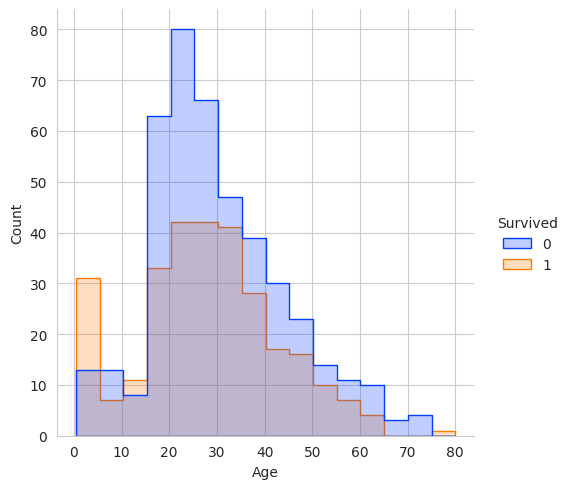

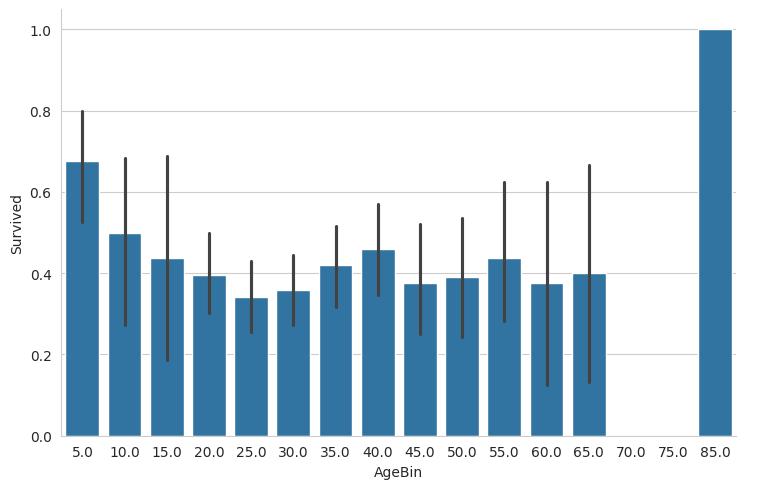

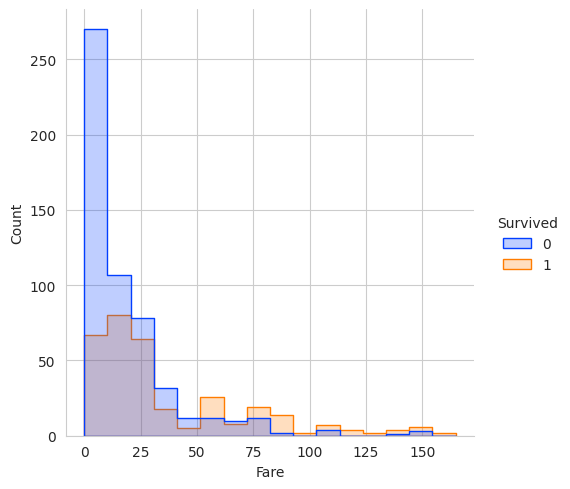

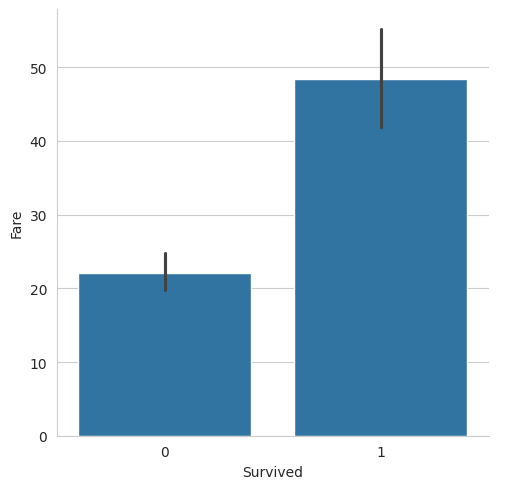

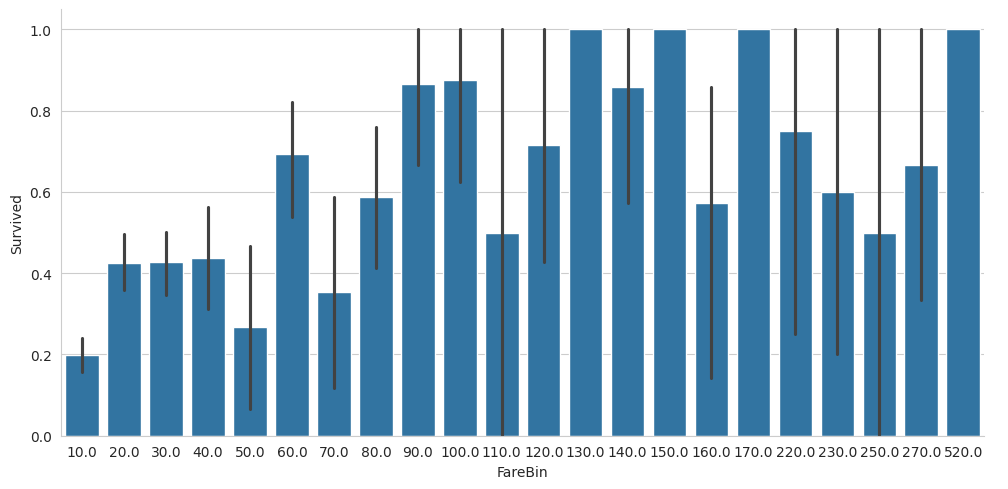

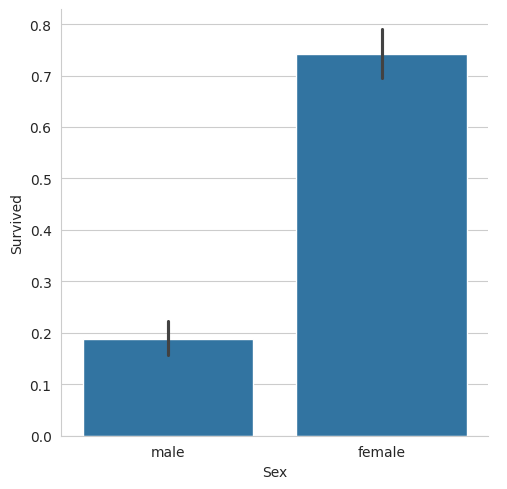

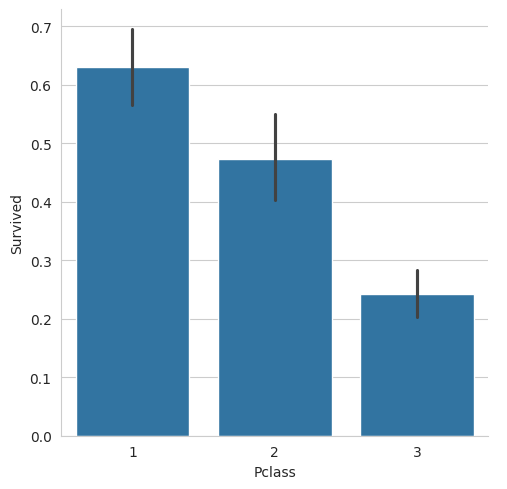

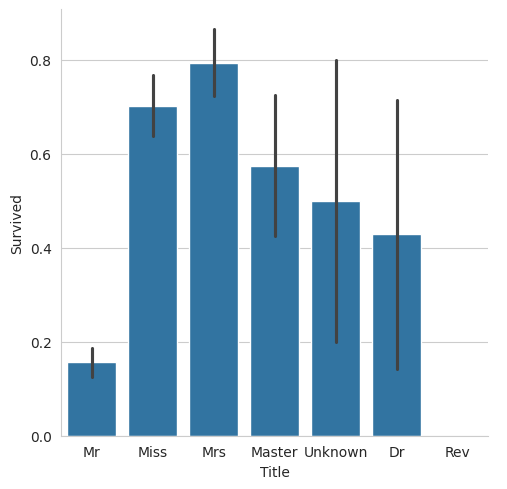

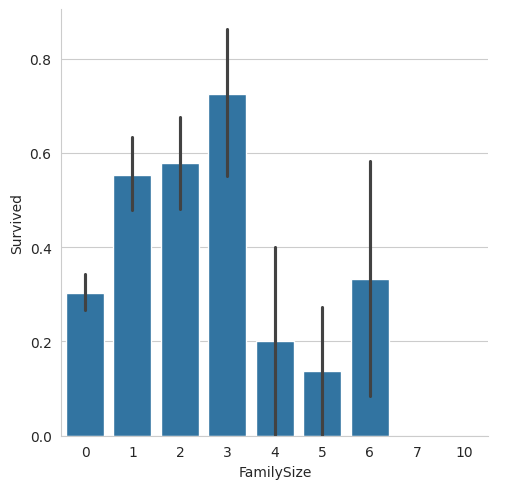

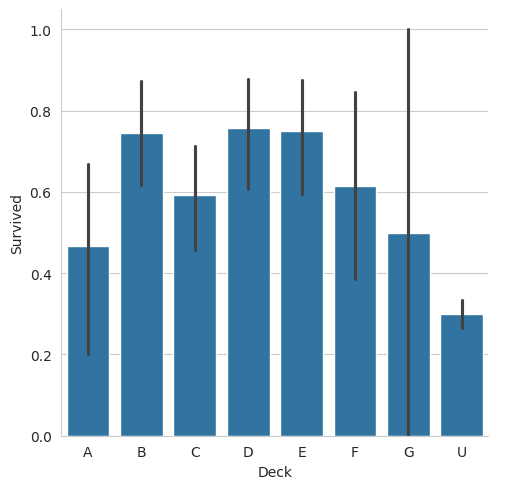

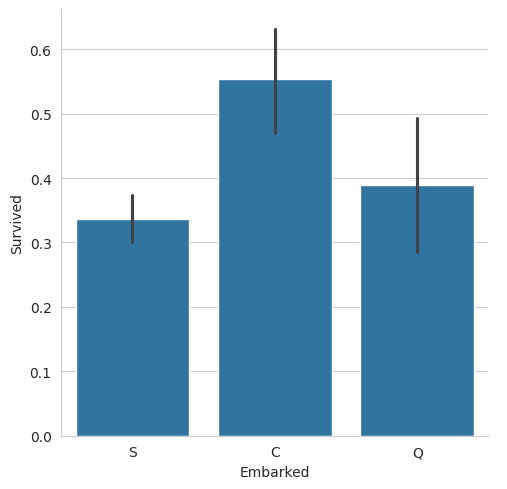

In [808]:
g = sns.displot(df_out, x="Age", hue="Survived", element="step", binwidth=5, palette="bright")
g = sns.catplot(df_out, x="AgeBin", y="Survived", kind="bar", aspect=1.5)
# g = sns.catplot(df_out, x="AgeMissing", y="Survived", kind="bar")
g = sns.displot(df_out.loc[df["Fare"] < 200], x="Fare", hue="Survived", binwidth=10, palette="bright", element="step")
g = sns.catplot(df_out, x="Survived", y="Fare", kind="bar")
g = sns.catplot(df_out, x="FareBin", y="Survived", kind="bar", aspect=2)
g = sns.catplot(df_out, x="Sex", y="Survived", kind="bar")
g = sns.catplot(df_out, x="Pclass", y="Survived", kind="bar")
g = sns.catplot(df_out, x="Title", y="Survived", kind="bar", order=df_out.Title.value_counts().sort_values(ascending=False).index)
g = sns.catplot(df_out, x="FamilySize", y="Survived", kind="bar")
# g = sns.displot(df_out, x="FamilySize", hue="Survived", element="step", discrete=True, palette="bright")
# g = sns.catplot(df_out, x="SibSp", y="Survived", kind="bar")
# g = sns.catplot(df_out, x="Parch", y="Survived", kind="bar")
g = sns.catplot(df_out, x="Deck", y="Survived", kind="bar", order=sorted(df_out.Deck.unique()))
g = sns.catplot(df_out, x="Embarked", y="Survived", kind="bar", order=df_out.Embarked.value_counts().sort_values(ascending=False).index)

## Age/Fare transformations

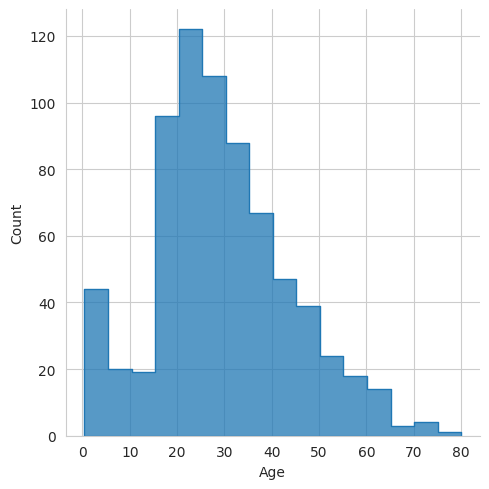

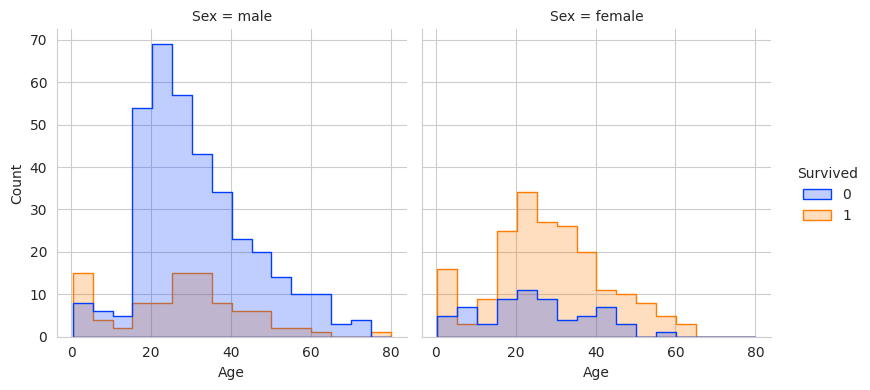

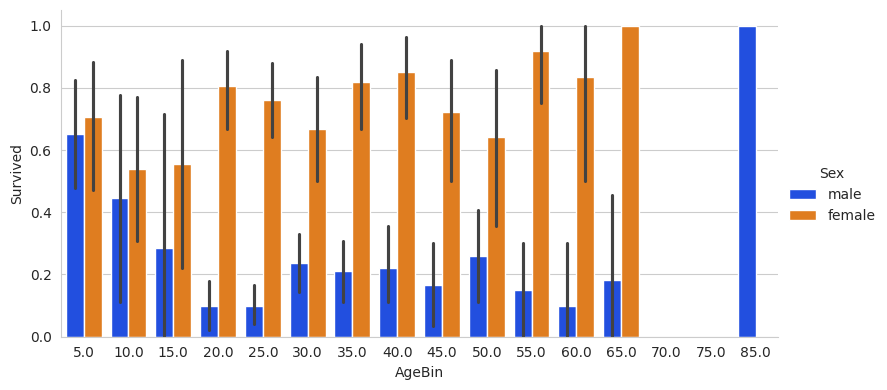

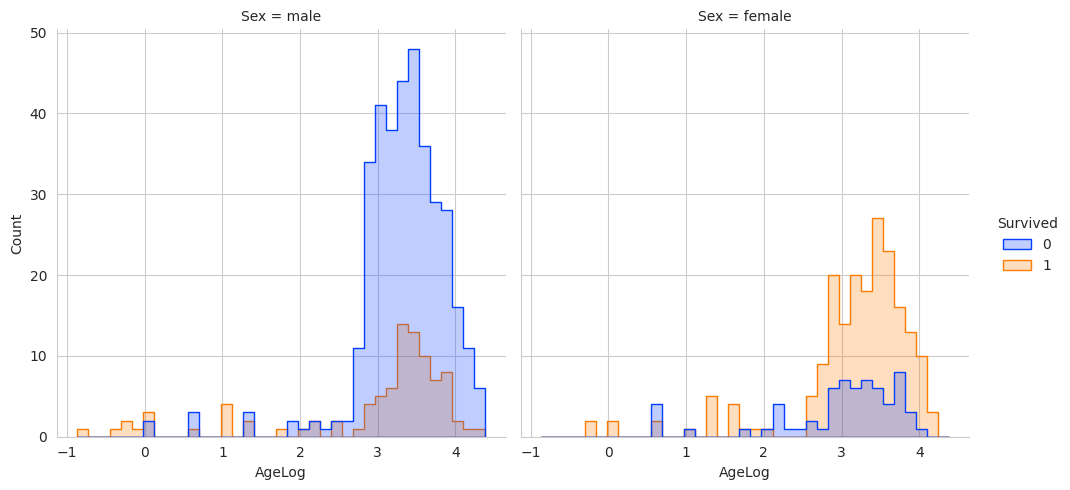

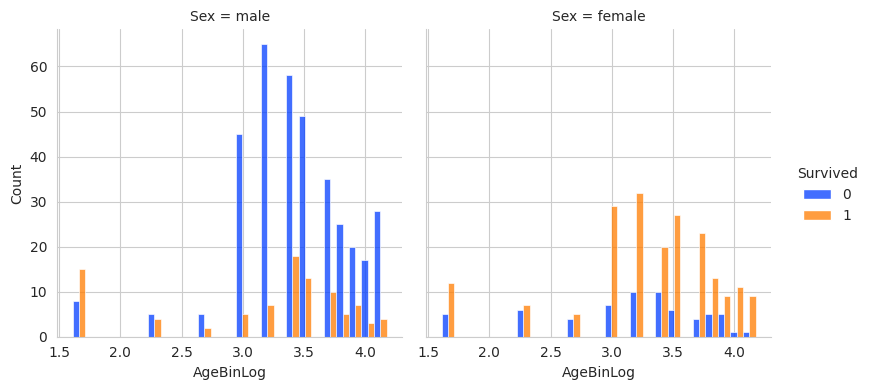

In [ ]:
# Transformation params: binwidth, clip, enable log transform (it should be after binning if binning is enabled)
# Before taking log, you may want to clip lower to 1
# For age, try binwidth=5, clip=65. If you bin and make the bins ordinal, it doesn't make sense to also log. If you keep numeric, then maybe it makes sense to take log.
# Perhaps just bin and clip and keep numeric?

binwidth = 5

df_out["AgeLog"] = np.log(df_out["Age"])
df_out["AgeBinLog"] = df_out["AgeBin"].astype("float")
df_out["AgeBinLog"] = np.log(df_out["AgeBinLog"].clip(upper=65))

g = sns.displot(df_out, kind="hist", x="Age", binwidth=binwidth, element="step")
g = sns.displot(df_out, kind="hist", x="Age", hue="Survived", col="Sex", binwidth=binwidth, palette="bright", element="step", height=4)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", hue="Sex", palette="bright", height=4, aspect=2)
g = sns.displot(df_out, kind="hist", x="AgeLog", hue="Survived", element="step", col="Sex", palette="bright")
g = sns.displot(df_out, kind="hist", x="AgeBinLog", hue="Survived", palette="bright", multiple="dodge", col="Sex", height=4)
# g = sns.catplot(df_out, kind="bar", x="AgeBinLog", y="Survived", hue="Sex", palette="bright", aspect=2)

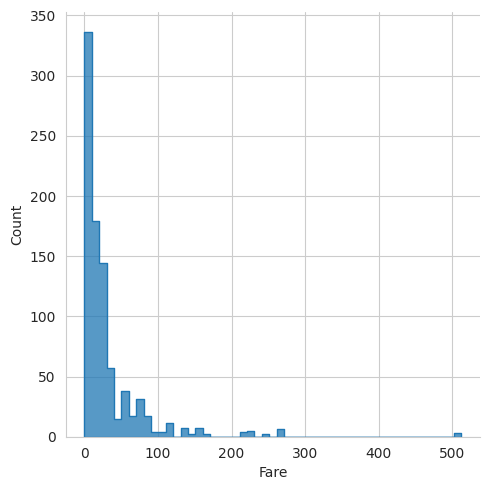

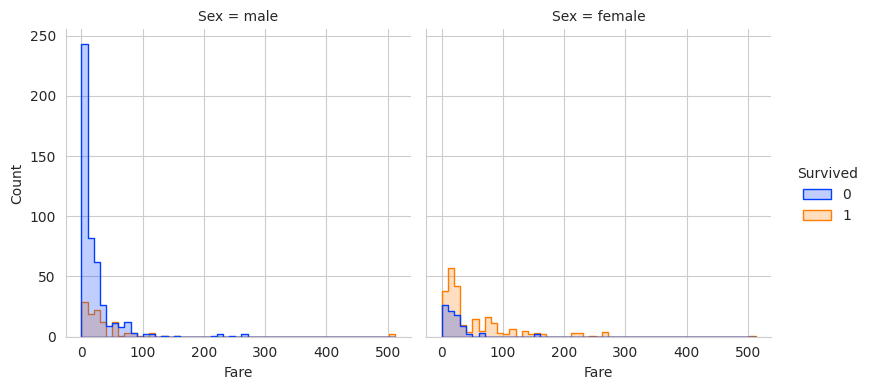

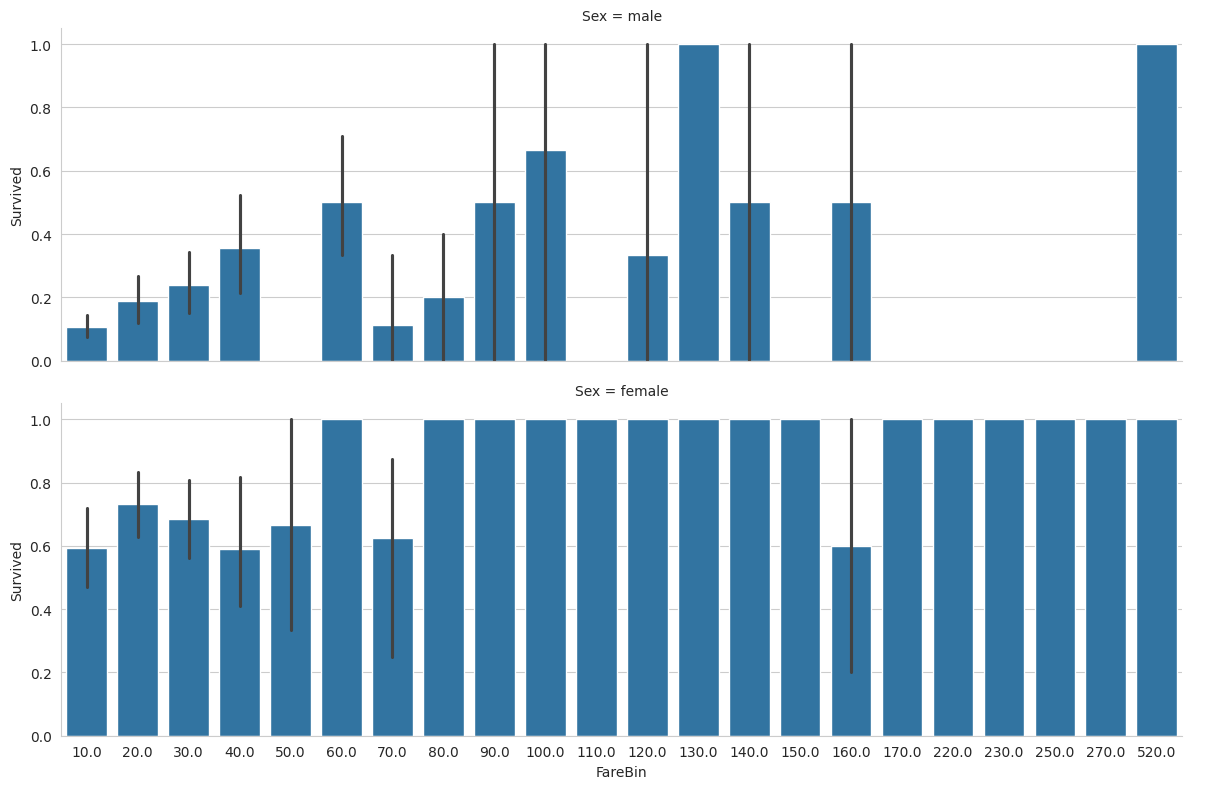

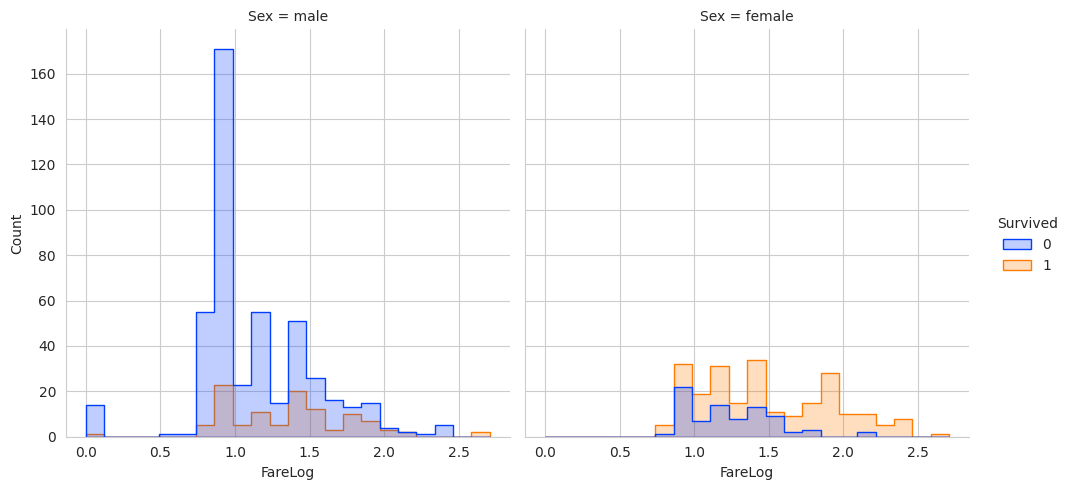

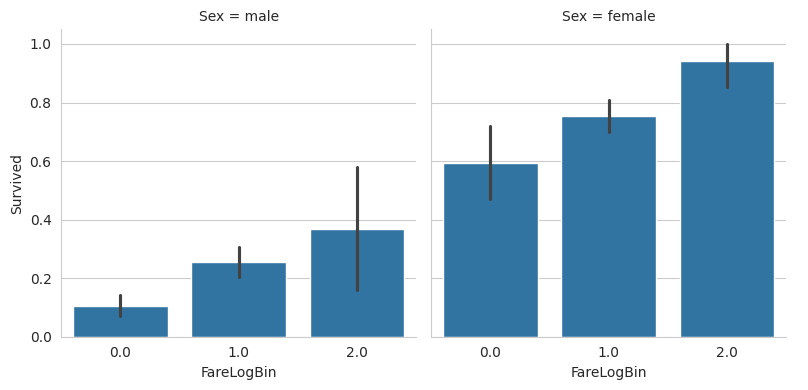

In [957]:
binwidth = 10

base = 10

df_out["FareLog"] = np.log10(df_out["Fare"].clip(lower=1))/np.log10(base)
df_out["FareLogBin"] = np.floor(np.log10(df_out["Fare"].clip(lower=1))/np.log10(base)).astype("category")
# df_out["FareBinLog"] = df_out["FareBin"].astype("float")
# df_out["FareBinLog"] = np.log(df_out["FareBinLog"].clip(upper=None))

g = sns.displot(df_out, kind="hist", x="Fare", binwidth=binwidth, element="step")
g = sns.displot(df_out, kind="hist", x="Fare", hue="Survived", col="Sex", binwidth=binwidth, palette="bright", element="step", height=4)
# g = sns.catplot(df_out, kind="bar", x="FareBin", y="Survived", hue="Sex", palette="bright", height=4, aspect=3)
g = sns.catplot(df_out, kind="bar", x="FareBin", y="Survived", row="Sex", height=4, aspect=3)
g = sns.displot(df_out, kind="hist", x="FareLog", hue="Survived", element="step", col="Sex", palette="bright")
g = sns.catplot(df_out, kind="bar", x="FareLogBin", y="Survived", col="Sex", height=4)
# g = sns.displot(df_out, kind="hist", x="FareBinLog", hue="Survived", palette="bright", multiple="dodge", col="Sex", height=4)

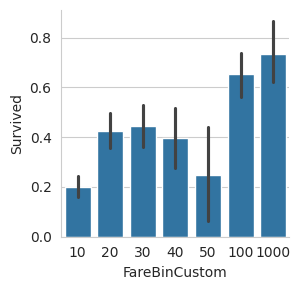

In [952]:
def custom_fare_bin(x):
    x = np.clip(x, a_min=0, a_max=1000)
    bins = np.array([10, 20, 30, 40, 50, 100, 1000])
    return bins[np.argmax(x <= bins)]

df_out["FareBinCustom"] = df_out["Fare"].map(custom_fare_bin).astype("category")
g = sns.catplot(df_out, kind="bar", x="FareBinCustom", y="Survived", height=3)

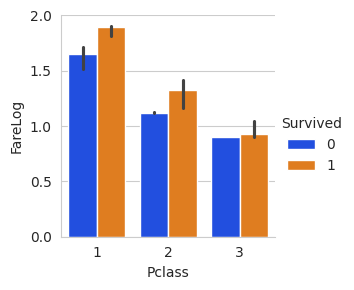

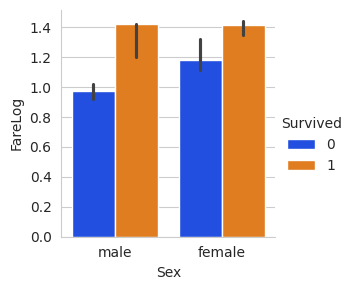

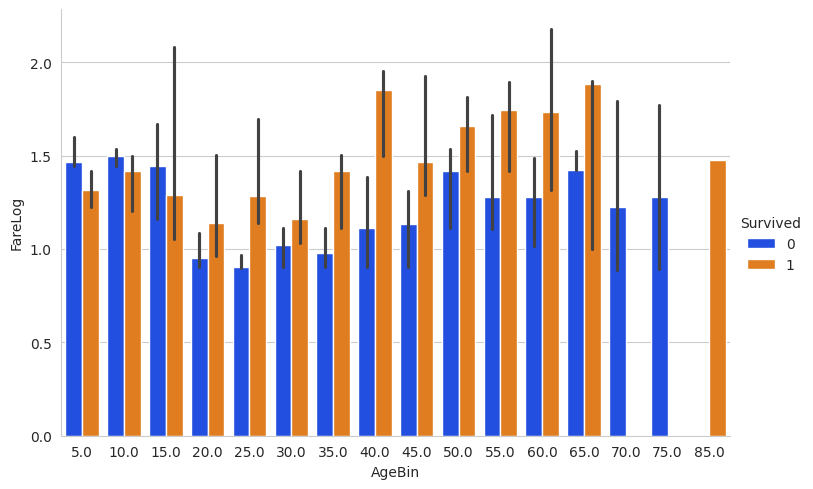

In [969]:
g = sns.catplot(df_out, kind="bar", x="Pclass", y="FareLog", estimator="median", hue="Survived", palette="bright", height=3) # Using median reduces outlier effect
g = sns.catplot(df_out, kind="bar", x="Sex", y="FareLog", estimator="median", hue="Survived", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="FareLog", estimator="median", hue="Survived", palette="bright", aspect=1.5)

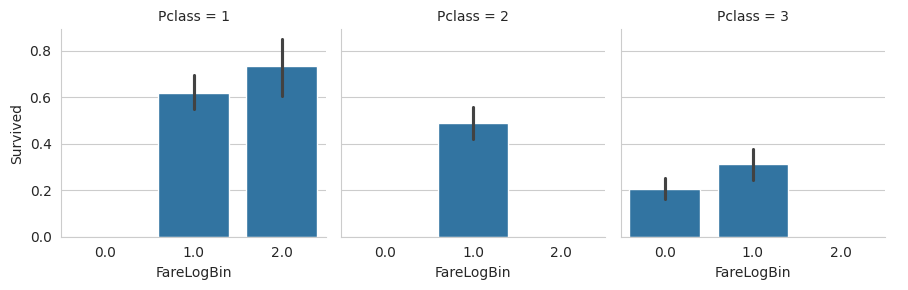

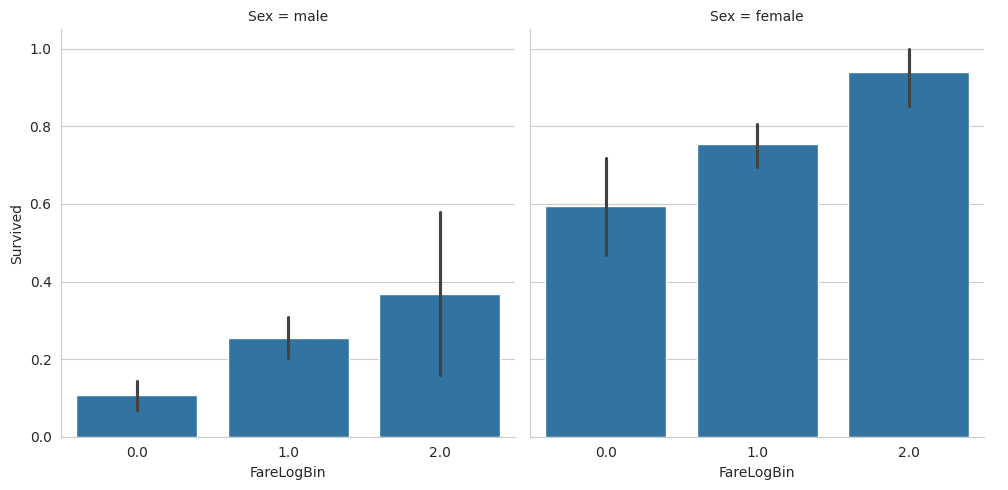

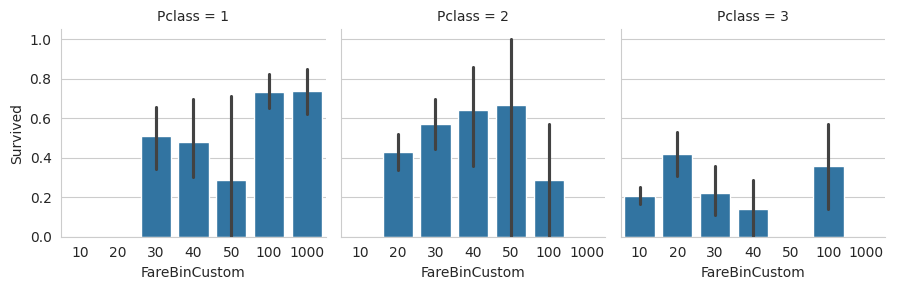

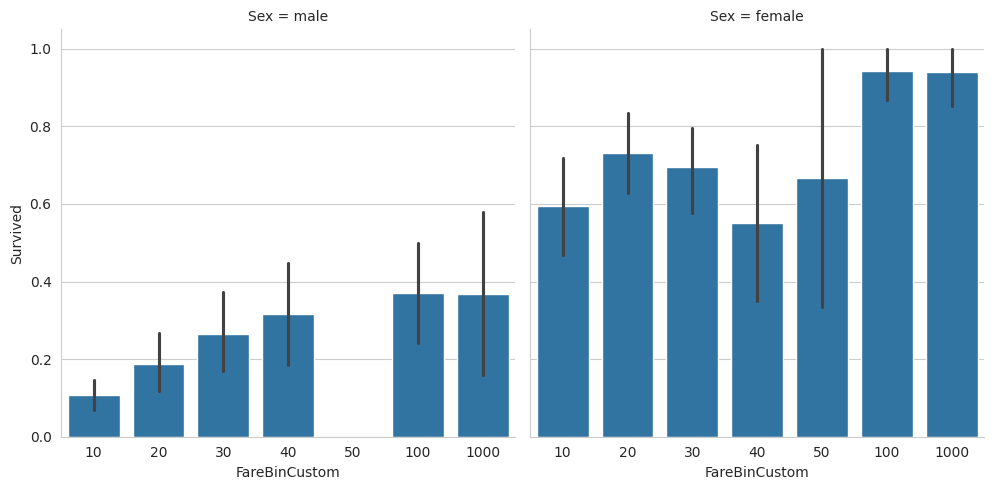

In [ ]:
g = sns.catplot(df_out, kind="bar", x="FareLogBin", y="Survived", col="Pclass", height=3)
g = sns.catplot(df_out, kind="bar", x="FareLogBin", y="Survived", col="Sex")
g = sns.catplot(df_out, kind="bar", x="FareBinCustom", y="Survived", col="Pclass", height=3)
g = sns.catplot(df_out, kind="bar", x="FareBinCustom", y="Survived", col="Sex")

# Multivariate

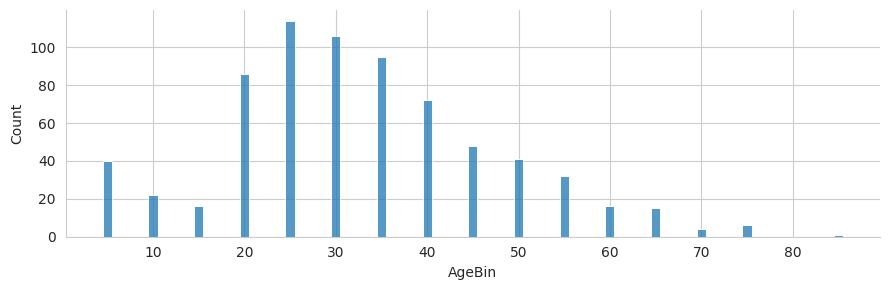

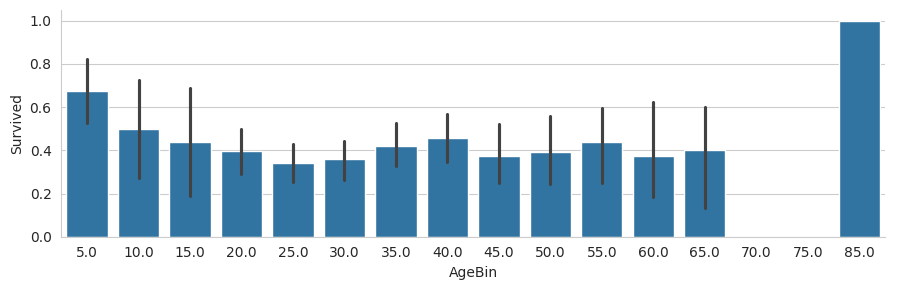

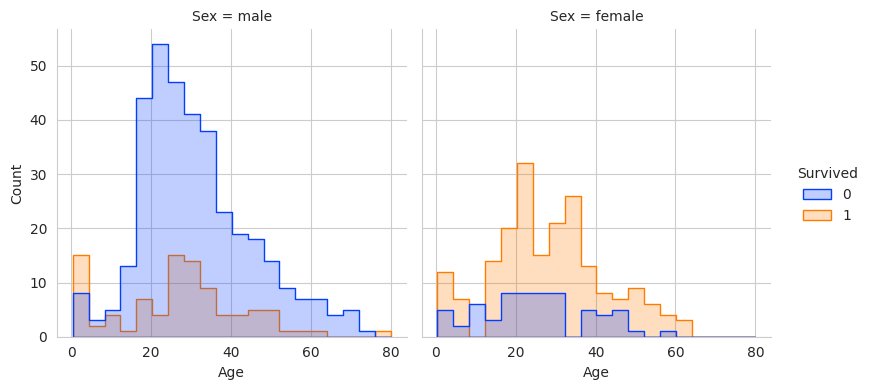

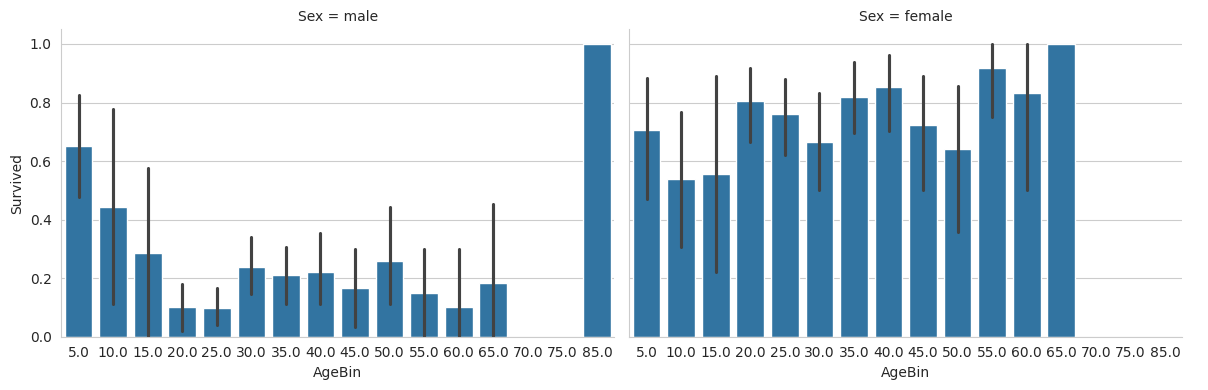

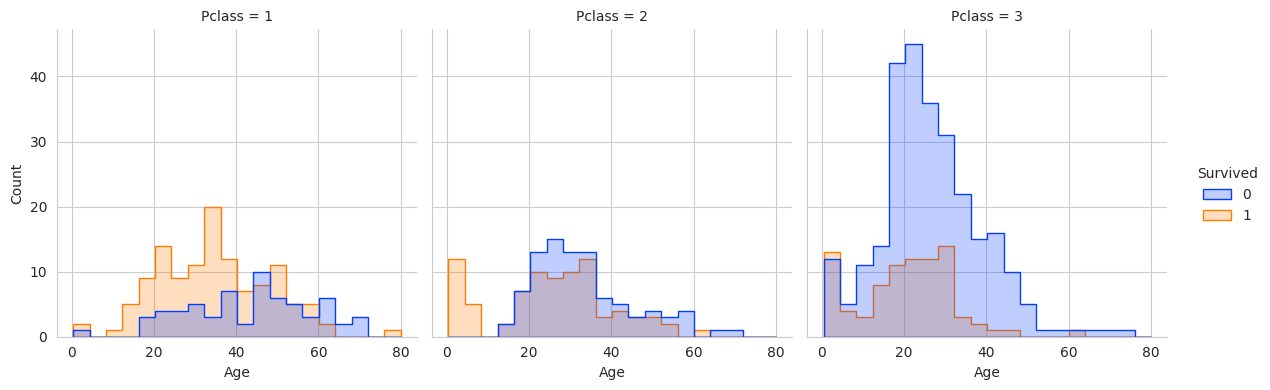

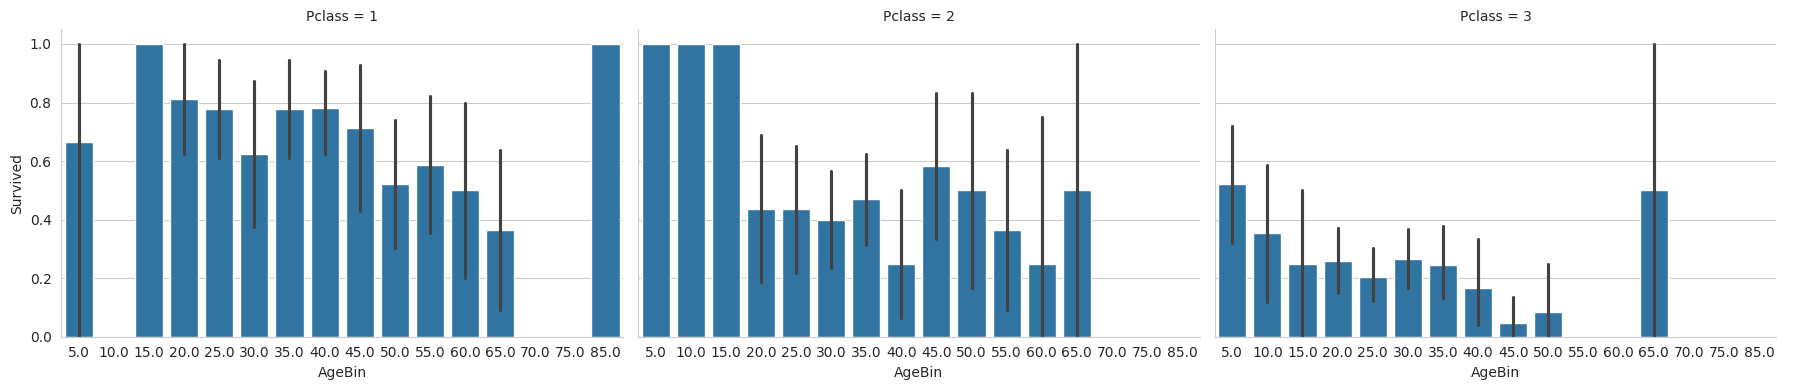

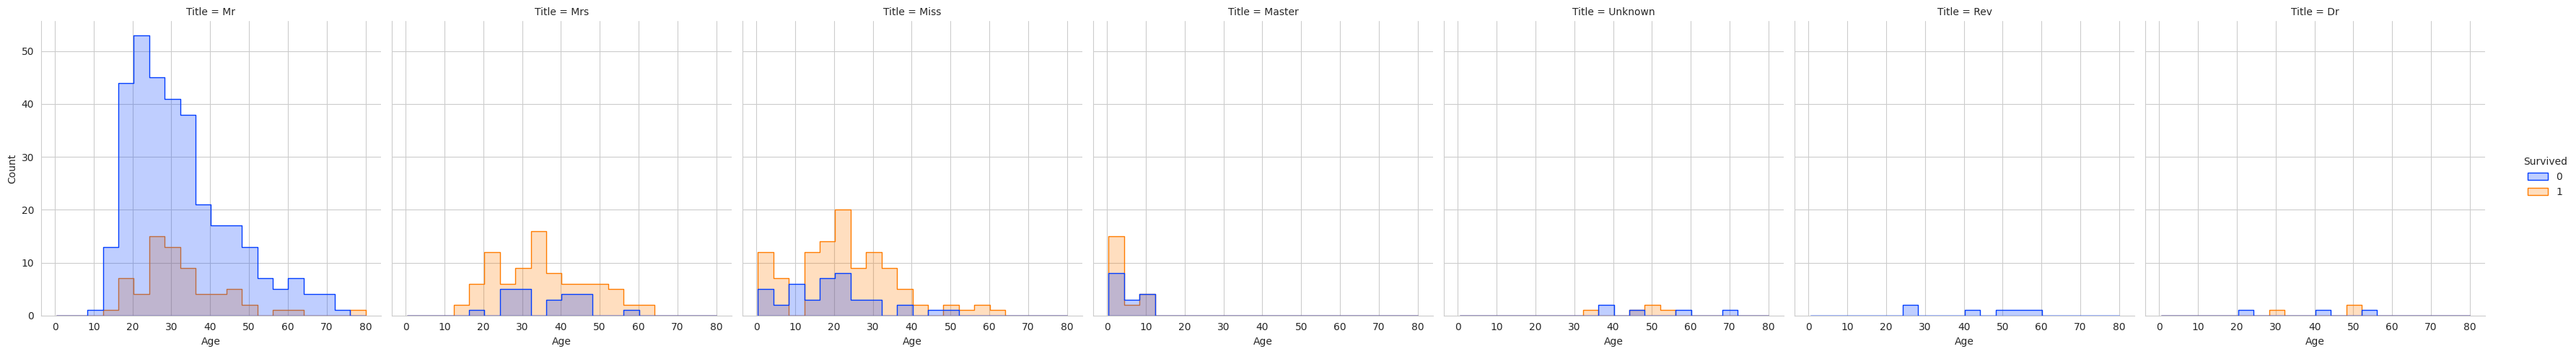

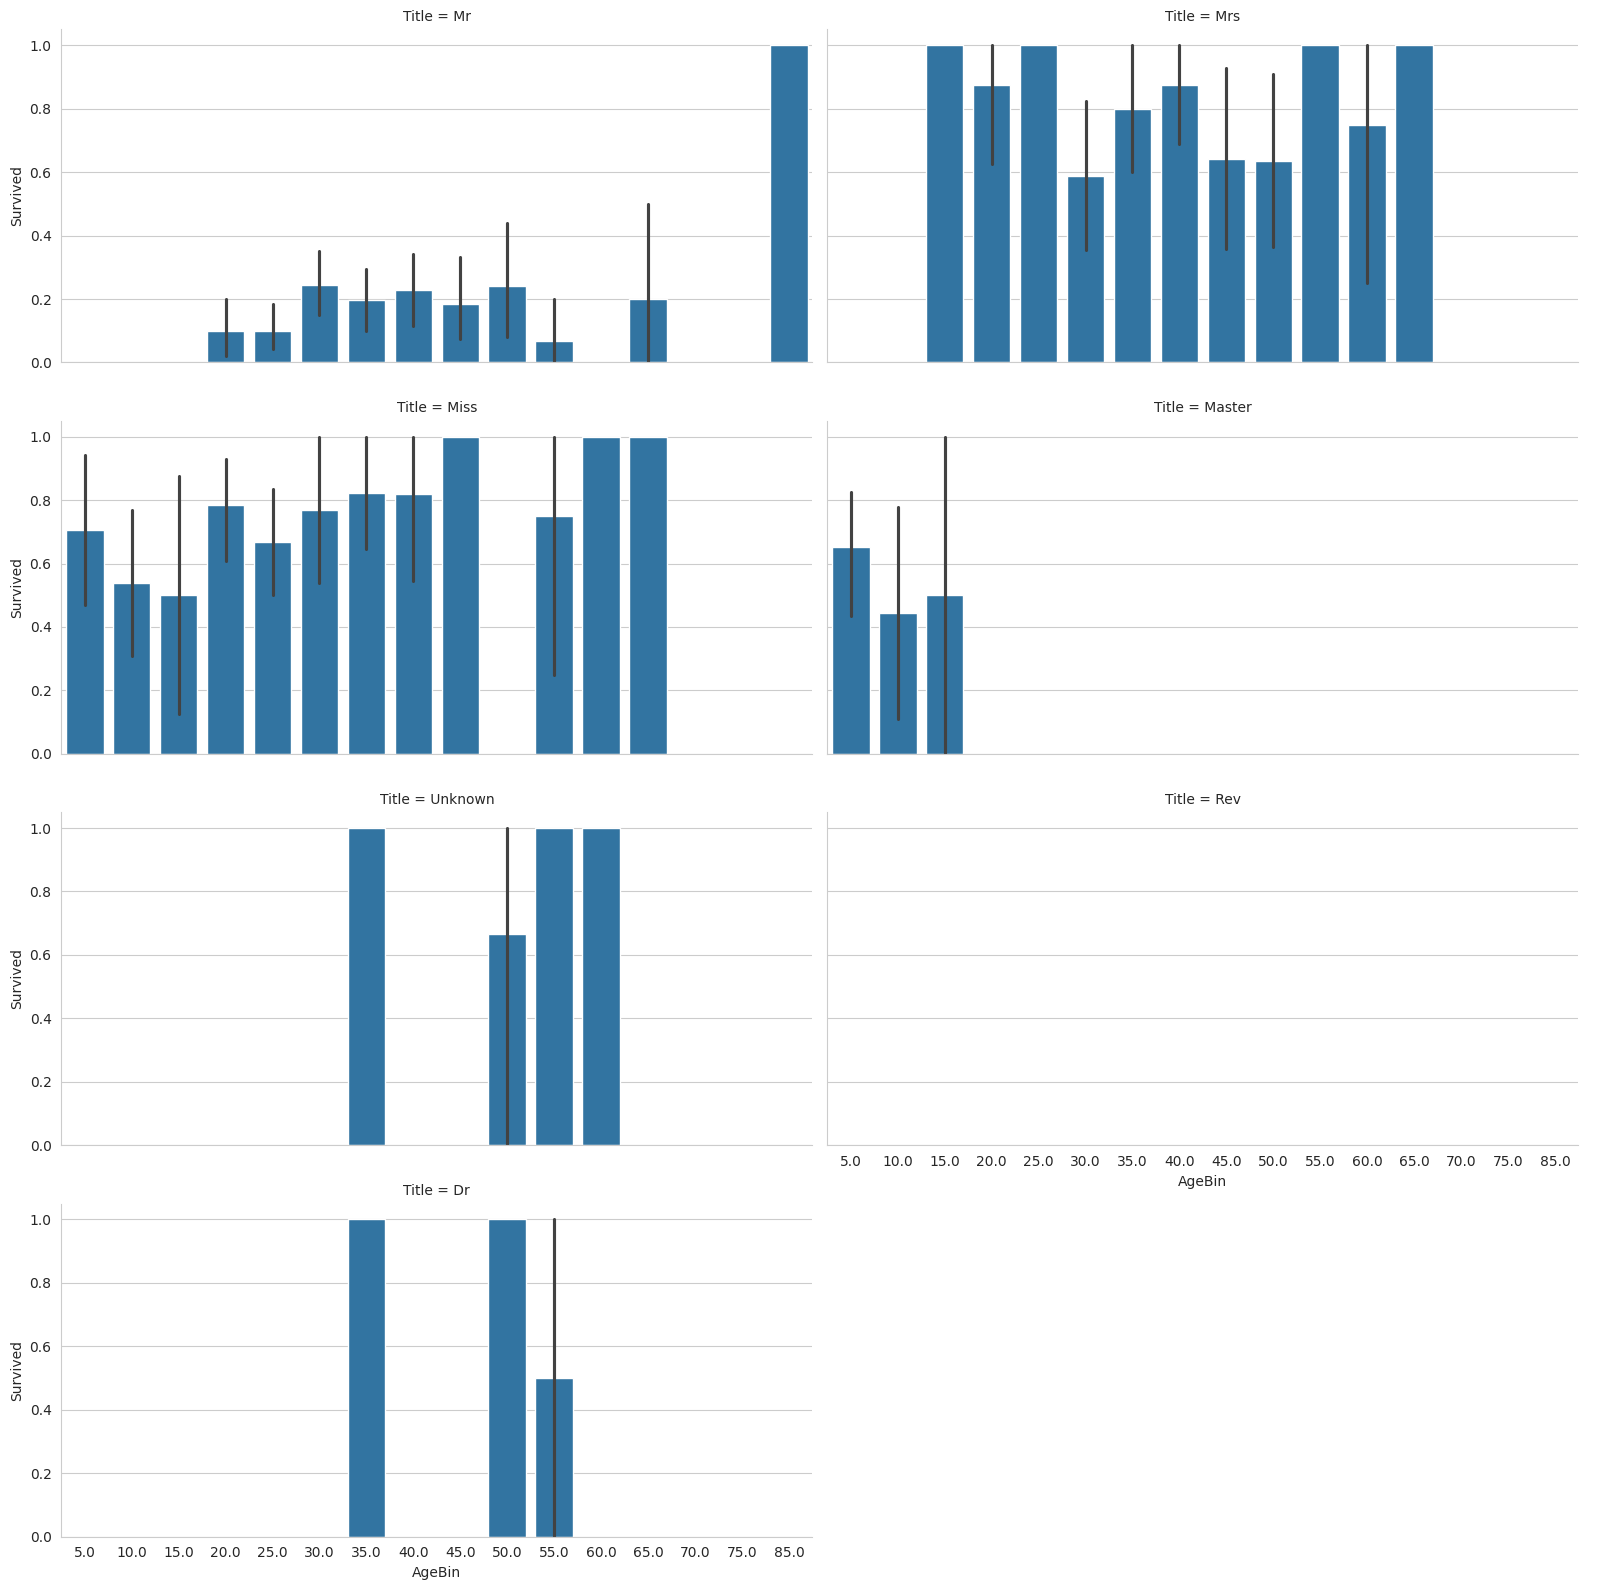

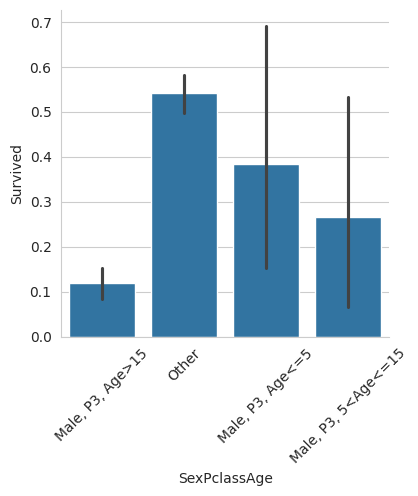

In [40]:
# Ah, To Be Young

g = sns.displot(df_out, kind="hist", x="AgeBin", discrete=True, height=3, aspect=3)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", height=3, aspect=3)
# g = sns.catplot(df_out, kind="bar", x="Survived", y="Age", estimator="median", height=4)
# g = sns.catplot(df_out, kind="boxen", x="Survived", y="Age", height=4)
# g = sns.displot(df_out, kind="hist", x="Age", hue="Sex", col="Survived", height=4, palette="bright", element="step")
g = sns.displot(df_out, kind="hist", x="Age", hue="Survived", palette="bright", col="Sex", element="step", height=4) # Survived vs. Age, controlling for Sex
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", col="Sex", height=4, aspect=1.5) # Survived vs. Age, controlling for Sex
g = sns.displot(df_out, kind="hist", x="Age", hue="Survived", palette="bright", col="Pclass", element="step", height=4)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", col="Pclass", height=4, aspect=1.5)
g = sns.displot(df_out, kind="hist", x="Age", col="Title", hue="Survived", element="step", palette="bright")
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", height=4, col="Title", aspect=2, col_wrap=2)
g = sns.catplot(df_out, kind="bar", x="SexPclassAge", y="Survived", height=4)
g.ax.tick_params(axis="x", labelrotation=45)

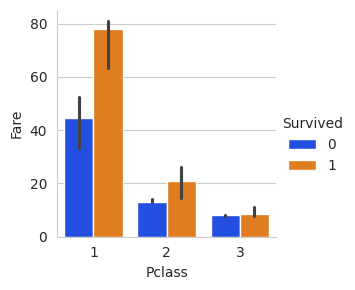

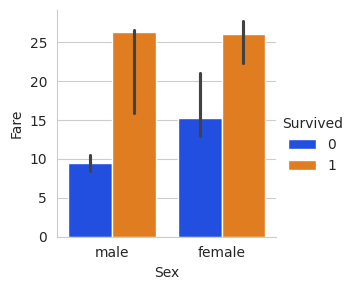

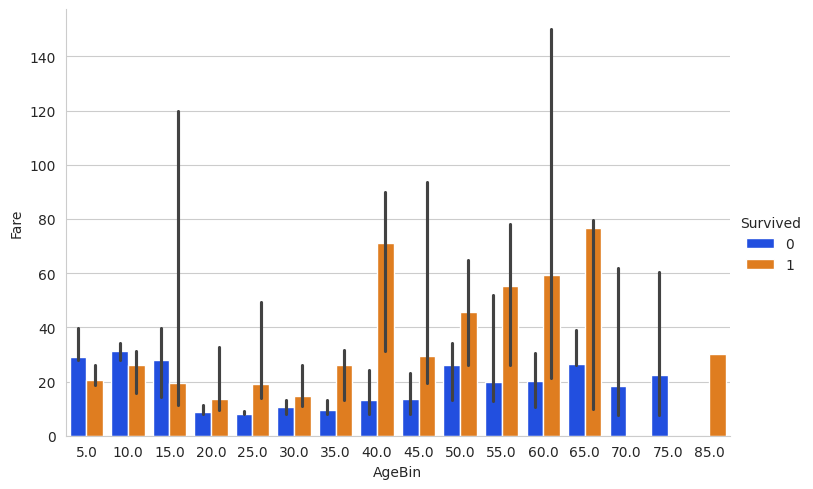

In [956]:
# Life Is Pay 2 Win

# Controlling for Pclass, does Fare affect survival? Yes, big difference in median (which is important when considering tree splits)
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Fare", estimator="median", hue="Survived", palette="bright", height=3) # Using median reduces outlier effect
g = sns.catplot(df_out, kind="bar", x="Sex", y="Fare", estimator="median", hue="Survived", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Fare", estimator="median", hue="Survived", palette="bright", aspect=1.5)

In [ ]:
# The Fairer Sex

g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", hue="Sex", palette="bright", height=3, aspect=2)
g = sns.catplot(df_out, kind="bar", x="FareBin", y="Survived", hue="Sex", palette="bright", height=3, aspect=3)
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Survived", hue="Sex", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Survived", hue="Sex", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="Deck", y="Survived", hue="Sex", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="Embarked", y="Survived", hue="Sex", palette="bright", height=3)

In [ ]:
# Priority Passenger, Coming Through!

g = sns.catplot(df_out, kind="bar", y="Survived", x="AgeBin", hue="Pclass", palette="bright", height=4, aspect=3)
g = sns.catplot(df_out, kind="bar", y="Survived", x="FareBin", hue="Pclass", palette="bright", height=4, aspect=3)
g = sns.catplot(df_out, kind="bar", y="Survived", x="Sex", hue="Pclass", palette="bright", height=4)
g = sns.catplot(df_out, kind="bar", y="Survived", x="Title", hue="Pclass", palette="bright", height=4)
g.ax.tick_params(axis="x", labelrotation=45)
g = sns.catplot(df_out, kind="bar", y="Survived", x="FamilySize", hue="Pclass", palette="bright", height=4)

In [ ]:
# Does Deck matter? Or is it Pclass?

print(df_out.groupby(["Pclass"]).Deck.value_counts().sort_index())
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Survived", hue="Deck", palette="bright", height=4, hue_order=sorted(df_out.Deck.unique()))

In [ ]:
# Embarked - does it really matter?

print(df_out.Embarked.value_counts().sort_values(ascending=False))
print(df_out.groupby("Pclass").Embarked.value_counts().sort_index())
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Survived", hue="Embarked", palette="bright", height=4, hue_order=df_out.Embarked.value_counts().sort_values(ascending=False).index)

In [ ]:
# Excuse Me, Miss

print(df_out.Title.value_counts().sort_values(ascending=False))
g = sns.catplot(df_out, kind="bar", x="Title", y="Survived", height=3, order=df_out.Title.value_counts().sort_values(ascending=False).index)
g.ax.tick_params(axis="x", labelrotation=45)
g = sns.catplot(df_out.loc[df_out["FareBin"] < 50], kind="bar", x="FareBin", y="Survived", hue="Title", palette="bright", height=4, aspect=1.5, hue_order=df_out.Title.value_counts().sort_values(ascending=False).index)
g = sns.catplot(df_out, kind="bar", x="Sex", y="Survived", hue="Title", palette="bright", hue_order=df_out.Title.value_counts().sort_values(ascending=False).index)
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Survived", hue="Title", palette="bright", hue_order=df_out.Title.value_counts().sort_values(ascending=False).index)
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Survived", hue="Title", palette="bright", hue_order=df_out.Title.value_counts().sort_values(ascending=False).index, aspect=3)
g = sns.catplot(df_out, kind="bar", x="Deck", y="Survived", hue="Title", 
                palette="bright", hue_order=df_out.Title.value_counts().sort_values(ascending=False).index, 
                order=sorted(df_out.Deck.unique()), aspect=3)

FamilySize
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64


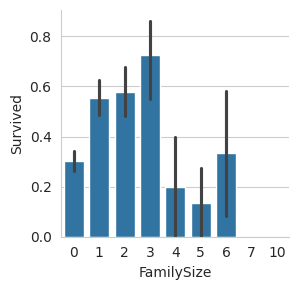

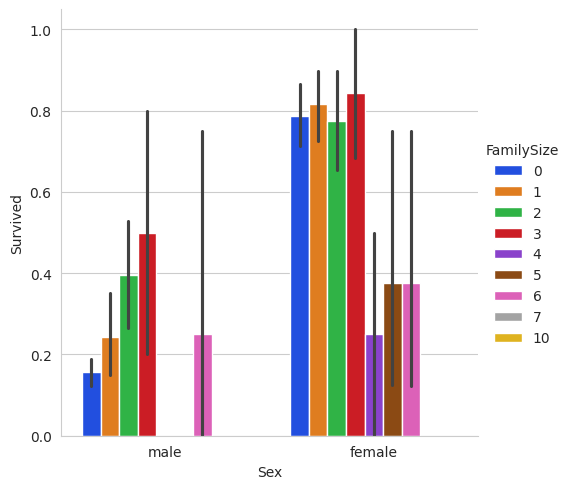

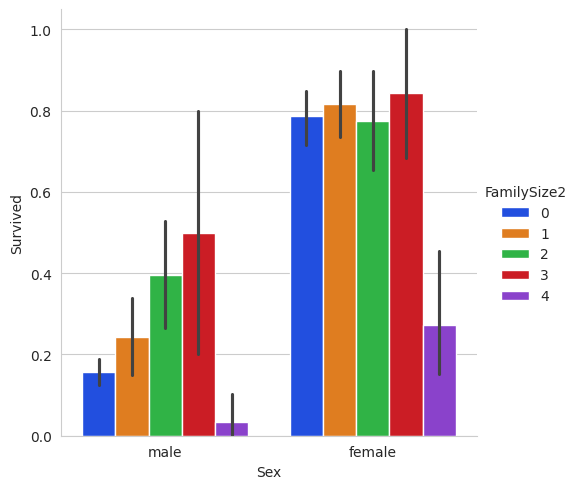

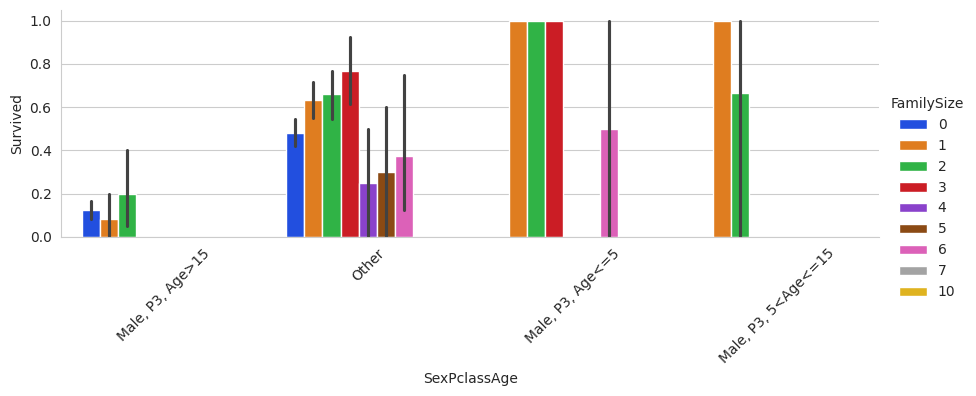

In [430]:
# Man + Small Family = Dead. Large Family? Also Dead.

print(df_out.FamilySize.value_counts().sort_index())
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Survived", height=3)
# print(df_out.groupby("Sex").FamilySize.value_counts().sort_index())
g = sns.catplot(df_out, kind="bar", x="Sex", y="Survived", hue="FamilySize", palette="bright")
df_out["FamilySize2"] = df_out["FamilySize"].clip(upper=4)
g = sns.catplot(df_out, kind="bar", x="Sex", y="Survived", hue="FamilySize2", palette="bright")
g = sns.catplot(df_out, kind="bar", x="SexPclassAge", y="Survived", hue="FamilySize", palette="bright", height=3, aspect=3)
g.ax.tick_params(axis="x", labelrotation=45)

# Who's Missing?

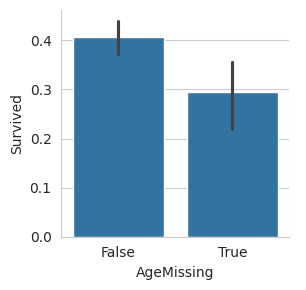

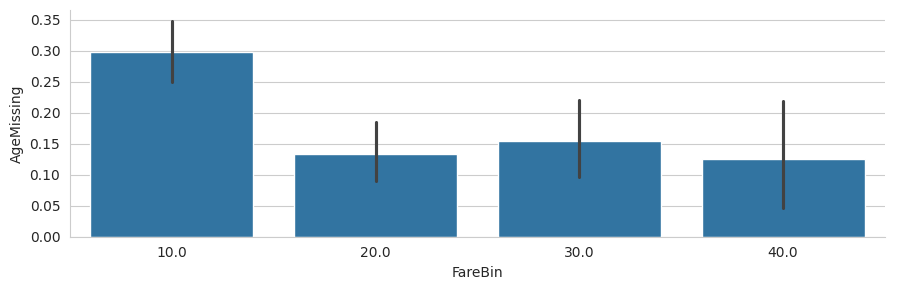

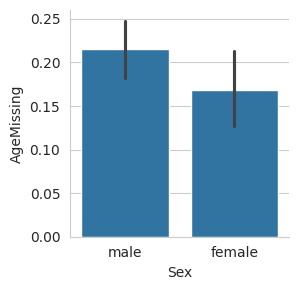

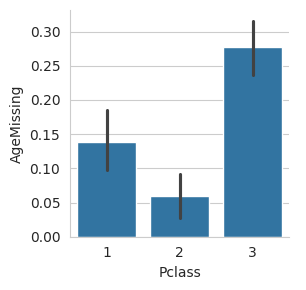

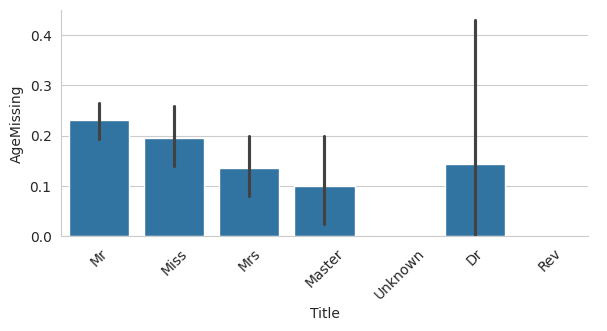

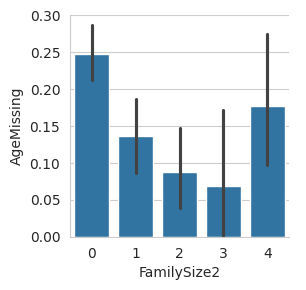

In [ ]:
# Age missing? You're dead.
# Age missing is probably covered by other features.

g = sns.catplot(df_out, kind="bar", x="AgeMissing", y="Survived", height=3)
g = sns.catplot(df_out.loc[df_out["FareBin"] < 50], kind="bar", x="FareBin", y="AgeMissing", height=3, aspect=3)
g = sns.catplot(df_out, kind="bar", x="Sex", y="AgeMissing", height=3)
g = sns.catplot(df_out, kind="bar", x="Pclass", y="AgeMissing", height=3)
g = sns.catplot(df_out, kind="bar", x="Title", y="AgeMissing", height=3, aspect=2, order=df_out.Title.value_counts().sort_values(ascending=False).index)
g.ax.tick_params(axis="x", labelrotation=45)
df_out["FamilySize2"] = df_out["FamilySize"].clip(upper=4)
g = sns.catplot(df_out, kind="bar", x="FamilySize2", y="AgeMissing", height=3)

## Predicting Age

* When training a model to predict Age, should you clip Age to 65? Hard to say. Not sure if it'll affect the survival prediction much.
* No pattern from Fare
* Sex doesn't matter too much on its own, but there's a bigger difference w/FamilySize interaction. In large families, the women tend to be older.
* Larger family (clipped at 4) = younger
* More siblings = younger (stronger predictor than family size)
* Higher class = older
* Title makes a big difference

Features to use: Sex, FamilySize, SibSp, Pclass, Title

I'm thinking my AgeImputer should take care of encoding the features and then drop after. Who cares if it takes more time. Much easier if it's standalone.

Can RandomForestRegressor predict/split based on median? If mean only, should I clip or transform Age so it's not so skewed?

In [39]:
iqr_times_1p5 = df_out.Age.quantile([0.25, 0.75]).diff().iloc[1]*1.5

print([df_out.Age.quantile([0.25])-iqr_times_1p5, df_out.Age.quantile([0.75])+iqr_times_1p5])

# df_out.loc[df_out.Age > (df_out.Age.quantile([0.75])+iqr_times_1p5).iloc[0].item()]
df_out.query("Age > 60").sort_values(by="Survived", ascending=False)

[0.25   -6.6875
Name: Age, dtype: float64, 0.75    64.8125
Name: Age, dtype: float64]


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title,Deck,SexPclassAge,FareTransformed,Survived,AgeMissing,AgeBin,FareBin
483,484,3,female,63.0,0,0,4134,9.5875,S,0,Mrs,U,Other,0.981705,1,False,65.0,10.0
829,830,1,female,62.0,0,0,113572,80.0000,NaN,0,Mrs,B,Other,1.903090,1,False,65.0,90.0
570,571,2,male,62.0,0,0,S.W./PP 752,10.5000,S,0,Mr,U,Other,1.021189,1,False,65.0,20.0
630,631,1,male,80.0,0,0,27042,30.0000,S,0,Mr,A,Other,1.477121,1,False,85.0,40.0
275,276,1,female,63.0,1,0,13502,77.9583,S,1,Miss,D,Other,1.891862,1,False,65.0,80.0
33,34,2,male,66.0,0,0,C.A. 24579,10.5000,S,0,Mr,U,Other,1.021189,0,False,70.0,20.0
252,253,1,male,62.0,0,0,113514,26.5500,S,0,Mr,C,Other,1.424065,0,False,65.0,30.0
170,171,1,male,61.0,0,0,111240,33.5000,S,0,Mr,B,Other,1.525045,0,False,65.0,40.0
116,117,3,male,70.5,0,0,370369,7.7500,Q,0,Mr,U,"Male, P3, Age>15",0.889302,0,False,75.0,10.0
96,97,1,male,71.0,0,0,PC 17754,34.6542,C,0,Mr,A,Other,1.539756,0,False,75.0,40.0


In [18]:
print(df_out[["Fare", "Age"]].corr())
print("")
print(df_out.groupby("Sex").Age.describe())
print("")
print(df_out.groupby("FamilySize").Age.describe())
print("")
print(df_out.groupby(["FamilySize", "Sex"]).Age.describe())
print("")
print(df_out.groupby("Pclass").Age.describe())
print("")

          Fare       Age
Fare  1.000000  0.096067
Age   0.096067  1.000000

        count       mean        std   min   25%   50%   75%   max
Sex                                                              
female  261.0  27.915709  14.110146  0.75  18.0  27.0  37.0  63.0
male    453.0  30.726645  14.678201  0.42  21.0  29.0  39.0  80.0

            count       mean        std   min   25%   50%   75%   max
FamilySize                                                           
0           404.0  32.220297  12.899871  5.00  22.0  29.5  39.0  80.0
1           139.0  31.391511  13.484379  0.42  22.0  29.0  42.0  65.0
2            93.0  26.035806  16.542123  0.67  15.0  27.0  37.0  70.0
3            27.0  18.274815  14.304131  0.75   3.5  23.0  28.0  48.0
4            51.0  17.843137  16.062842  1.00   5.5  11.0  24.0  64.0

                   count       mean        std    min    25%   50%    75%  \
FamilySize Sex                                                              
0          fem

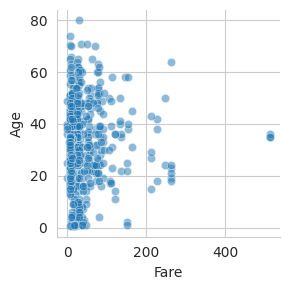

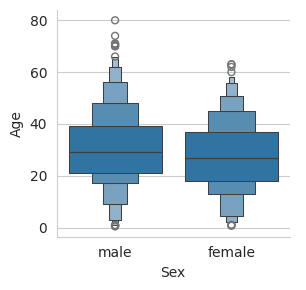

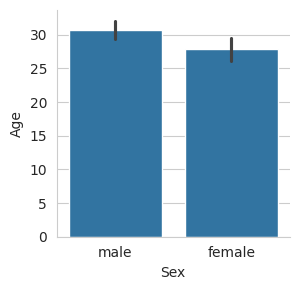

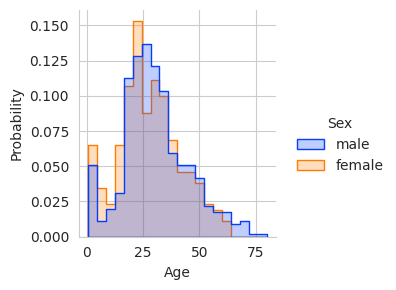

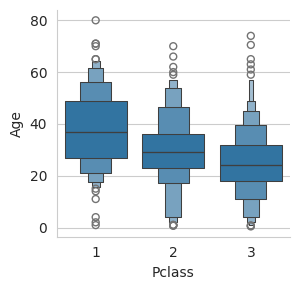

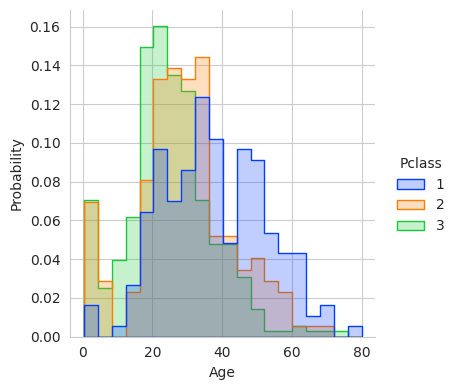

In [ ]:
g = sns.relplot(df_out, kind="scatter", x="Fare", y="Age", alpha=0.5, height=3)
g = sns.catplot(df_out, kind="boxen", x="Sex", y="Age", height=3)
g = sns.catplot(df_out, kind="bar", x="Sex", y="Age", height=3)
g = sns.displot(df_out, kind="hist", x="Age", hue="Sex", palette="bright", element="step", height=3, stat="probability", common_norm=False)
g = sns.catplot(df_out, kind="boxen", x="Pclass", y="Age", height=3)
g = sns.displot(df_out, kind="hist", x="Age", hue="Pclass", palette="bright", element="step", height=4, stat="probability", common_norm=False)
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Age", height=4)
g = sns.catplot(df_out, kind="boxen", x="FamilySize", y="Age", height=4)
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Age", hue="Sex", palette="bright", height=4)
g = sns.catplot(df_out, kind="boxen", x="FamilySize", y="Age", hue="Sex", palette="bright", height=4)
g = sns.catplot(df_out, kind="bar", x="SibSp", y="Age", height=4)
g = sns.catplot(df_out, kind="boxen", x="SibSp", y="Age", height=4)
g = sns.catplot(df_out, kind="bar", x="SibSp", y="Age", height=4, hue="Sex", palette="bright")
g = sns.catplot(df_out, kind="boxen", x="SibSp", y="Age", height=4, hue="Sex", palette="bright")
# g = sns.catplot(df_out, kind="bar", x="Parch", y="Age", height=4)
# g = sns.catplot(df_out, kind="boxen", x="Parch", y="Age", height=4)

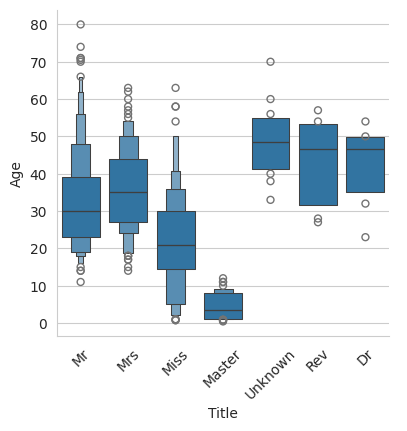

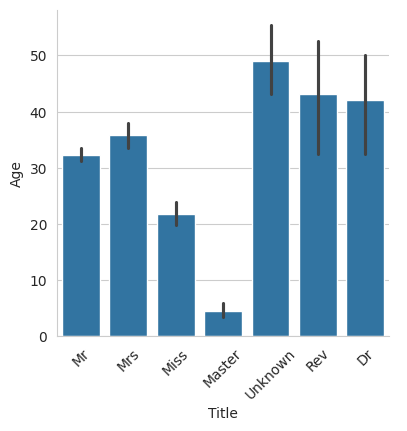

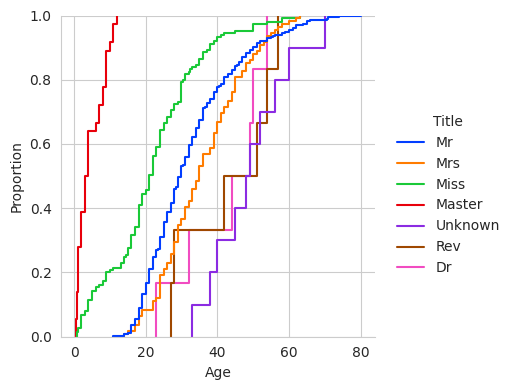

In [45]:
g = sns.catplot(df_out, kind="boxen", x="Title", y="Age", height=4)
g.ax.tick_params(axis="x", labelrotation=45)
g = sns.catplot(df_out, kind="bar", x="Title", y="Age", height=4)
g.ax.tick_params(axis="x", labelrotation=45)
g = sns.displot(df_out, kind="ecdf", x="Age", hue="Title", palette="bright", height=4)

# Training and evaluation

* Treat the test predictions as the labels and see if they make sense
    * I broke it - I used Pclass as the only feature, and indeed, train/val/test accuracy are all 67%
    * Double-check the train-test distributions again
* Other solutions
    * Prove that they leaked data and that it artificially inflates test performance
* Age imputation - customize the data prep pipeline
* Sample weighting? Weight by disjunct/target?
* Can you visualize how the random forest or decision tree is coming up with decisions?
* Gradient boosting?
* We're still overfitting on training data - is this affecting test generalization?

Features:
* Age: passthrough - imputation, what about log transform? Binning? Clipping or removing outliers?
* Fare: passthrough - what about log transform? Binning? Clipping or removing outliers?
* Sex (ord): passthrough
* Pclass: passthrough
* Title (onehot): valid = [Mr, Mrs, Miss, Master, Rev, Dr], valid = [Mr, Mrs, Miss, Master, Rev]
* SibSp/Parch: drop
* FamilySize: passthrough, clip upper 4
* Deck (ord): drop
* Embarked (onehot): drop
* SexPclassAge (onehot): passthrough

In [976]:
from custom_transformers import DynamicDataPrepPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

df = pd.read_csv("./dataset/train.csv")

In [1022]:
data_prep_pipe = DynamicDataPrepPipeline()
model = RandomForestClassifier(max_depth=12, random_state=0)

ml_pipe = Pipeline([
    ("data_prep", data_prep_pipe),
    ("model", model)
])

# 0 - model depth ~ 12
param_grid = [
    {
        "data_prep__numeric_columns": [{"Age", "Pclass", "Fare", "SibSp", "Parch"}],
        "model__max_depth": [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5],
    },
]

# 1 - title alone is the best
param_grid = [
    {
        "data_prep__extract_title": [False, True],
        "data_prep__extract_fam": [False, True],
        "data_prep__extract_deck": [False, True],
        "data_prep__extract_sexpclassage": [False, True],
    },
]

# 2 - reducing valid titles degrades performance, deck degrades performance
param_grid = [
    {
        "data_prep__extract_title": [True],
        "data_prep__title_kwargs": [{"valid": ["Mr", "Miss", "Mrs", "Master", "Rev"]}],
        "data_prep__extract_deck": [False, True],
    },
]

# 3 - SibSp, Parch, FamilySize all degrade performance
param_grid = [
    {
        "data_prep__numeric_columns": [{"Age", "Pclass", "Fare"}, {"Age", "Pclass", "Fare", "SibSp", "Parch"}],
        "data_prep__extract_title": [True],
        "data_prep__title_kwargs": [{}, {"valid": ["Mr", "Miss", "Mrs", "Master", "Rev"]}],
        "data_prep__extract_fam": [True],
        "data_prep__fam_kwargs": [{}, {"max_famsize": 4}]
    },
    {
        "data_prep__numeric_columns": [{"Age", "Pclass", "Fare"}, {"Age", "Pclass", "Fare", "SibSp", "Parch"}],
        "data_prep__extract_title": [True],
        "data_prep__title_kwargs": [{}, {"valid": ["Mr", "Miss", "Mrs", "Master", "Rev"]}],
    },
]

# 4 - depth ~ 8-12
param_grid = [
    {
        "data_prep__extract_title": [True],
        "model__max_depth": [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5],
    },
]

# 5 - remove one at a time: Fare, Sex, Age, Title, Pclass
# param_grid = [
#     {
#         "data_prep__extract_title": [True],
#         "model__max_depth": [8],
#         "data_prep__numeric_columns": [{"Age", "Pclass", "Fare"}],
#         "data_prep__ordinal_columns": [{"Sex"}],
#     },
#     {
#         "data_prep__extract_title": [True],
#         "model__max_depth": [8],
#         "data_prep__numeric_columns": [{"Age", "Pclass"}],
#         "data_prep__ordinal_columns": [{"Sex"}],
#     },
#     {
#         "data_prep__extract_title": [True],
#         "model__max_depth": [8],
#         "data_prep__numeric_columns": [{"Age", "Pclass", "Fare"}],
#         "data_prep__ordinal_columns": [set()],
#     },
#     {
#         "data_prep__extract_title": [True],
#         "model__max_depth": [8],
#         "data_prep__numeric_columns": [{"Pclass", "Fare"}],
#         "data_prep__ordinal_columns": [{"Sex"}],
#     },
#     {
#         "data_prep__extract_title": [False],
#         "model__max_depth": [8],
#         "data_prep__numeric_columns": [{"Age", "Pclass", "Fare"}],
#         "data_prep__ordinal_columns": [{"Sex"}],
#     },
#     {
#         "data_prep__extract_title": [True],
#         "model__max_depth": [8],
#         "data_prep__numeric_columns": [{"Age", "Fare"}],
#         "data_prep__ordinal_columns": [{"Sex"}],
#     },
# ]

# 6 - try with both Fare and FareTransformed - seemingly no improvement
param_grid = [
    {
        "data_prep__extract_title": [True],
        "data_prep__transform_fare": [True],
        "data_prep__fare_kwargs": [{}, {"bin": True}],
        "model__max_depth": [10, 9, 8],
        "model__n_estimators": [100, 150],
    },
]

# 7 - no reduction in performance with FareTransformed until you bin. After binning, significantly worse performance.
param_grid = [
    {
        "data_prep__numeric_columns": [{"Age", "Pclass"}],
        "data_prep__extract_title": [True],
        "data_prep__transform_fare": [True],
        "data_prep__fare_kwargs": [{}, {"bin": True}],
        "model__max_depth": [10, 9, 8],
        "model__n_estimators": [100, 150],
    },
]

# 8 - not much difference b/w 100 and 1000
param_grid = [
    {
        "data_prep__numeric_columns": [{"Age", "Pclass"}],
        "data_prep__extract_title": [True],
        "data_prep__transform_fare": [True],
        "model__max_depth": [8, 12, 15],
        "model__n_estimators": [10, 100, 1000],
    },
]

param_grid = [
    {
        "data_prep__numeric_columns": [{"Pclass"}],
        "data_prep__ordinal_columns": [set()],
        # "data_prep__extract_title": [True],
        # "data_prep__transform_fare": [True],
        "model__max_depth": [8],
    },
]

n_folds = 20
grid = GridSearchCV(ml_pipe, param_grid=param_grid, cv=n_folds, scoring="accuracy", return_train_score=True)
grid.fit(df.drop("Survived", axis=1), df["Survived"])

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('data_prep', DynamicDataPrepPipeline()),
                                       ('model',
                                        RandomForestClassifier(max_depth=12,
                                                               random_state=0))]),
             param_grid=[{'data_prep__numeric_columns': [{'Pclass'}],
                          'data_prep__ordinal_columns': [set()],
                          'model__max_depth': [8]}],
             return_train_score=True, scoring='accuracy')

In [1023]:
pd.set_option("display.max_colwidth", 1000)
test_results = pd.DataFrame({"Run": list(range(len(grid.cv_results_["mean_train_score"]))),
                             "Train (Mean)": (np.array(grid.cv_results_["mean_train_score"])*100).round(2),
                             "Train (Std)": (np.array(grid.cv_results_["std_train_score"])*100/np.sqrt(n_folds)).round(2),
                             "Test (Mean)": (np.array(grid.cv_results_["mean_test_score"])*100).round(2),
                             "Test (Std)": (np.array(grid.cv_results_["std_test_score"])*100/np.sqrt(n_folds)).round(2),
                             "Params": grid.cv_results_["params"]})

test_results.sort_values(by="Test (Mean)", ascending=False)

,Run,Train (Mean),Train (Std),Test (Mean),Test (Std),Params
0,0,67.9,0.08,66.94,1.57,"{'data_prep__numeric_columns': {'Pclass'}, 'data_prep__ordinal_columns': {}, 'model__max_depth': 8}"


In [ ]:
from pathlib import Path

# filepath = "./cv/8_n_estimators.pkl"
# filepath = "./cv/5_remove_one_feature_per_iteration.pkl"

filepath = Path(filepath)

# test_results.to_pickle(filepath)

In [1007]:
filepath = "./cv/4_extract_title_only_sweep_depth.pkl"
test_results = pd.read_pickle(filepath)
# test_results.sort_values(by="Test (Mean)", ascending=False)
test_results.sort_values(by="Test (Mean)", ascending=False)

,Run,Train (Mean),Train (Std),Test (Mean),Test (Std),Params
7,7,91.39,0.10,84.96,1.42,"{'data_prep__extract_title': True, 'model__max_depth': 8}"
5,5,94.54,0.05,84.85,1.26,"{'data_prep__extract_title': True, 'model__max_depth': 10}"
6,6,93.09,0.09,84.74,1.46,"{'data_prep__extract_title': True, 'model__max_depth': 9}"
3,3,96.38,0.07,84.74,1.34,"{'data_prep__extract_title': True, 'model__max_depth': 12}"
4,4,95.48,0.07,84.52,1.46,"{'data_prep__extract_title': True, 'model__max_depth': 11}"
2,2,97.21,0.07,84.07,1.40,"{'data_prep__extract_title': True, 'model__max_depth': 13}"
8,8,89.76,0.09,84.07,1.39,"{'data_prep__extract_title': True, 'model__max_depth': 7}"
9,9,87.78,0.10,83.73,1.38,"{'data_prep__extract_title': True, 'model__max_depth': 6}"
1,1,97.78,0.05,83.62,1.36,"{'data_prep__extract_title': True, 'model__max_depth': 14}"
10,10,85.93,0.10,83.27,1.35,"{'data_prep__extract_title': True, 'model__max_depth': 5}"


In [1024]:
feature_importance = pd.DataFrame({"Feature": grid.best_estimator_.named_steps["data_prep"].get_feature_names_out(),
                                   "Importance": (grid.best_estimator_.named_steps["model"].feature_importances_*100).round(2)})

feature_importance.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,num__Pclass,100.0


# Testing

In [1025]:
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

In [1026]:
# Sanity check feature extraction

data_prep_pipe = TitleExtractor()

df_test_prep = data_prep_pipe.transform(df_test)

print(df_test_prep.columns)
print("")
print(df_test_prep.duplicated().sum())
print("")
print(df_test_prep.isna().sum())
print("")
df_test_prep.Title.value_counts().sort_values(ascending=False)

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

0

PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64



Title
Mr         240
Miss        79
Mrs         72
Master      21
Unknown      3
Rev          2
Dr           1
Name: count, dtype: int64

In [1027]:
# data_prep_pipe = DynamicDataPrepPipeline(extract_title=True)
data_prep_pipe = DynamicDataPrepPipeline(numeric_columns={"Pclass"}, ordinal_columns=set())
model = RandomForestClassifier(max_depth=8, random_state=0)

ml_pipe = Pipeline([
    ("data_prep", data_prep_pipe),
    ("model", model)
])

ml_pipe.fit(df_train.drop("Survived", axis=1), df_train["Survived"])

# Sanity check
y_pred = ml_pipe.predict(df_train.drop("Survived", axis=1))
(y_pred == df_train["Survived"].to_numpy()).sum()/len(y_pred)

np.float64(0.6790123456790124)

In [1028]:
y_pred = ml_pipe.predict(df_test)
sum(y_pred)/len(y_pred)

np.float64(0.25598086124401914)

In [1029]:
df_submit = pd.DataFrame({"PassengerId": df_test["PassengerId"],
                          "Survived": y_pred})

df_submit.to_csv("./dataset/submission.csv", index=False)

# First view of the training data

* Survival rate across all passengers is 38.38%

In [211]:
df = df_train
# df = df.astype({"Pclass": "category", "Sex": "category", "Embarked": "category", "Survived": "category"})
# print(df.info())
print(df.columns)
df.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [206]:
print(f"Number of samples = {df.shape[0]}, number of attributes = {df.shape[1]}\n")
# print(f"Attributes = {df.columns}\n")
print(f"Number of duplicates = {sum(df.duplicated())}\n")
print(f"Percentage of missing values = {round(df.isna().sum().sum() / df.size * 100, 1)}\n")

print("Data Types\n---------------------")
print(df.dtypes)
print("")

print("Missing Values\n---------------------------")
print(df.isna().sum())
print("")

# print(df.isna().sum().sum()

# df.describe()
# df.describe(include="object")


Number of samples = 891, number of attributes = 12

Number of duplicates = 0

Percentage of missing values = 8.1

Data Types
---------------------
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing Values
---------------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64



In [200]:
df.duplicated().sum()

np.int64(0)

In [254]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# Taking natural log

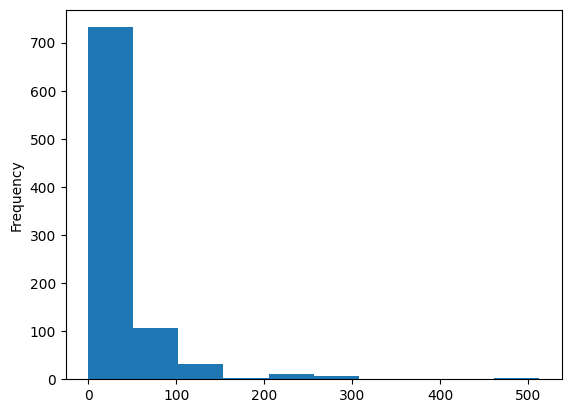

In [26]:
df_num = df.select_dtypes(include=["int64", "float64"]).drop(["PassengerId"], axis="columns").copy()
# df_num.columns
# df_num["Fare"] = np.log(df_num["Fare"].replace(0, np.nan))
df_num["Fare"].plot(kind="hist")
plt.show()
# for col in ["Fare"]:
#     df_num[col] = np.log(df_num[col])
# df_num.head()
# sum(df_num["Fare"] == 0) # 15 people got on for free

# PassengerId - drop

In [207]:
print(np.diff(df["PassengerId"]).min())
print(np.diff(df["PassengerId"]).max())

1
1


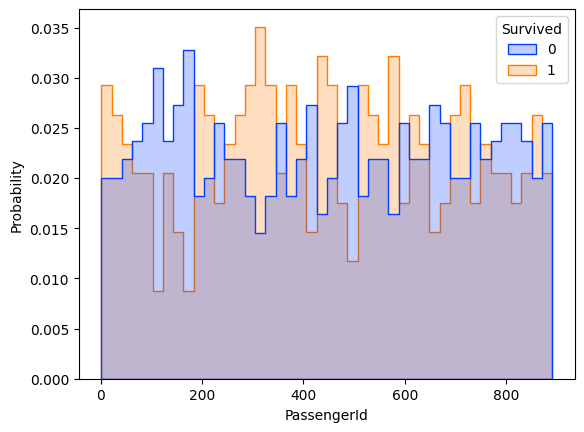

In [211]:
ax = sns.histplot(df, x="PassengerId", hue="Survived", stat="probability", \
                  binwidth=20, common_norm=False, multiple="layer", \
                  element="step", palette="bright")

# Pclass - passthrough

Analysis:
* Higher Pclass = higher rate of survival
* Pclass 1 and 2 have higher rates of survival than the overall; Pclass 3 has lower rate

In [389]:
df.Pclass.value_counts().sort_index()

Pclass
1    216
2    184
3    491
Name: count, dtype: int64

In [390]:
df.groupby(["Pclass"]).Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

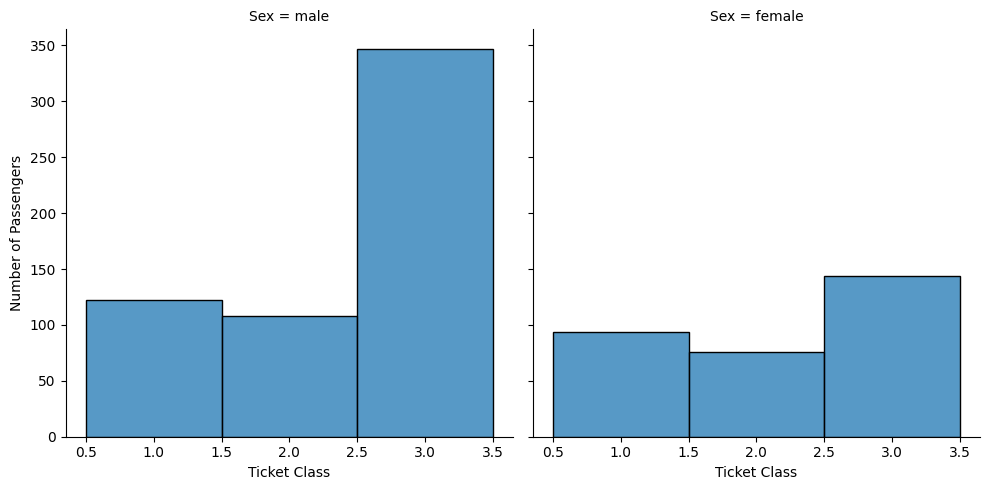

In [ ]:
g = sns.displot(df, x="Pclass", discrete=True, col="Sex")
g.set_axis_labels("Ticket Class", "Number of Passengers")

[3 1 2]
int64


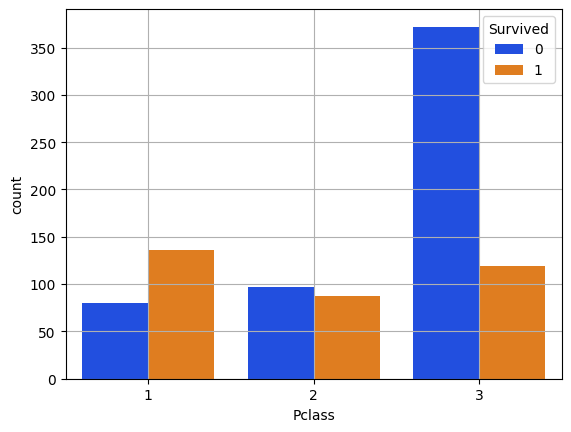

In [387]:
print(df["Pclass"].unique())
print(df["Pclass"].dtype)

ax = sns.countplot(df, x="Pclass", hue="Survived", palette="bright")
ax.grid()

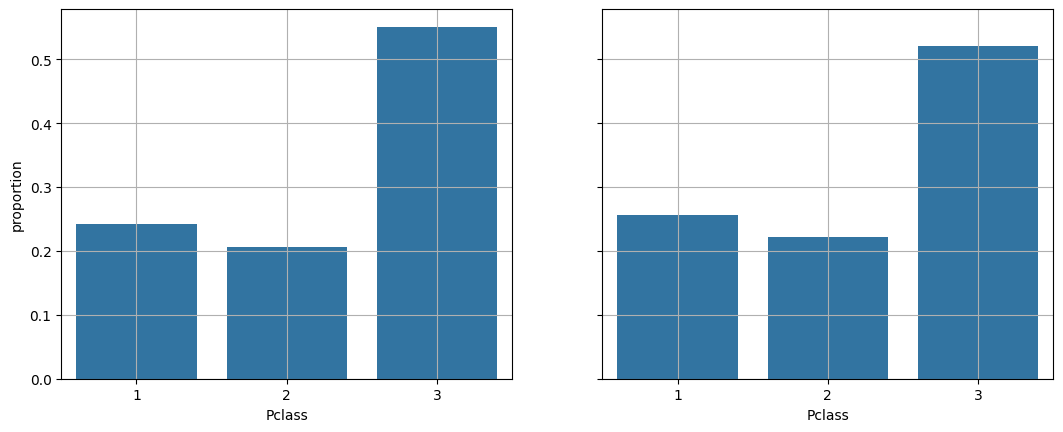

In [257]:
f, axs = plt.subplots(ncols=2, figsize=(12.8, 4.8), sharex=True, sharey=True)

sns.countplot(df, x="Pclass", ax=axs[0], stat="proportion")
sns.countplot(df_test, x="Pclass", ax=axs[1], stat="proportion")

axs[0].grid()
axs[1].grid()

# Sex - ordinal encoding

Analysis:
* More males than females on board
* You are much more likely to survive if you are female (double the overall rate). Males have roughly half the overall rate of survival.

In [370]:
df.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [386]:
df.groupby(["Sex"]).Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

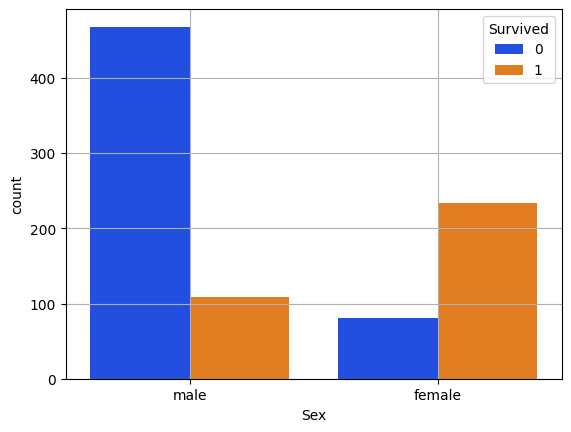

In [385]:
# ax = sns.countplot(df, x="Sex", hue="Survived", stat="probability", palette="bright")
ax = sns.countplot(df, x="Sex", hue="Survived", palette="bright")
ax.grid()

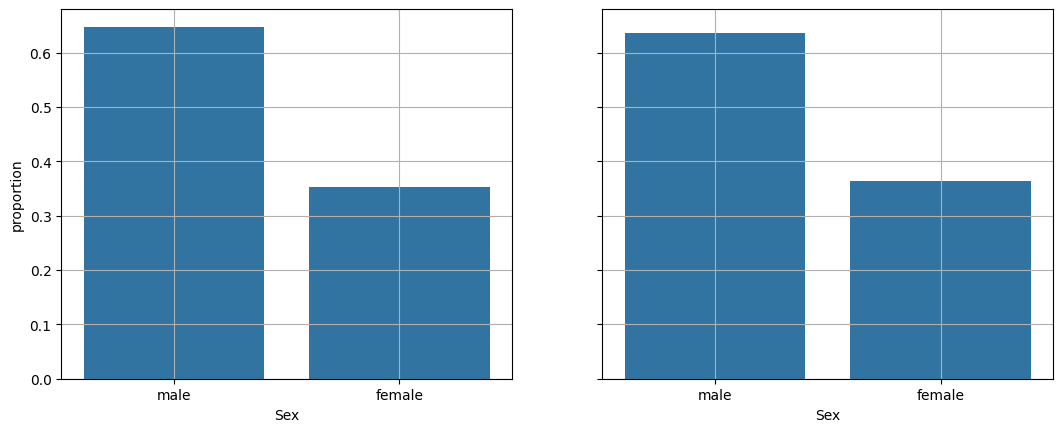

In [258]:
f, axs = plt.subplots(ncols=2, figsize=(12.8, 4.8), sharex=True, sharey=True)

sns.countplot(df, x="Sex", ax=axs[0], stat="proportion")
sns.countplot(df_test, x="Sex", ax=axs[1], stat="proportion")

axs[0].grid()
axs[1].grid()

# Age - passthrough, missing indicator/impute NaN

Analysis:
* Young Age = more likely to survive
* Age is correlated with Pclass - higher Pclass = higher Age

Analysis of missing Ages:
* 20% of Ages are missing
* If Age is missing, it's more likely the passenger died (70% vs. 60%)
* The missing Ages are not randomly distributed
    * Lower class (Pclass3) is more likely to be missing Ages
    * People without any family are more likely to be missing Ages
* Groupby Pclass, TotalFam, Fare (bracket), Titles, CabinMissing and calculate mean/median for each groupby - use this to impute
    * Most common missing groups
        * Titles = Mr., Pclass = 3, TotalFam = 0 -> median Age = 27
        * Titles = Mr., Pclass = 1, TotalFam = 0 -> median Age = 45
        * Titles = Miss., Pclass = 3, TotalFam = 0 -> median Age = 22


## Age univariate

In [331]:
df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

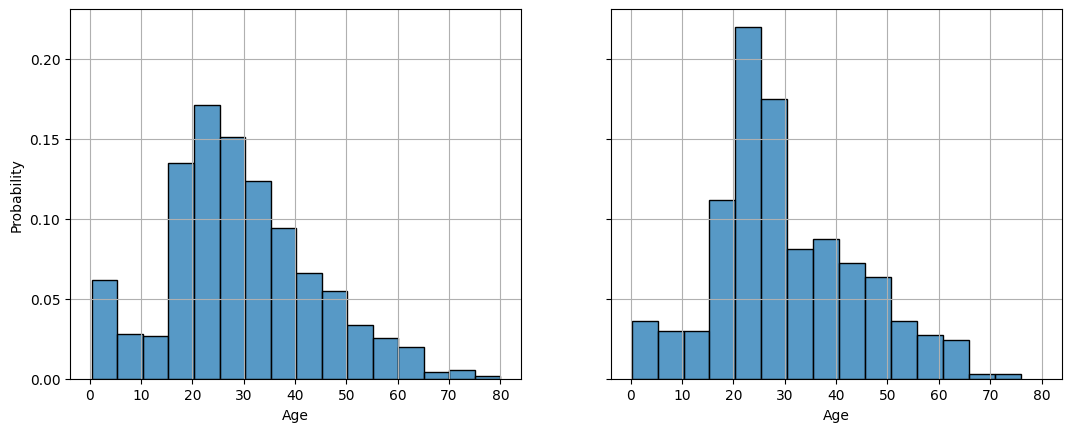

In [261]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.histplot(df, x="Age", binwidth=5, ax=axs[0], stat="probability")
sns.histplot(df_test, x="Age", binwidth=5, ax=axs[1], stat="probability")
axs[0].grid()
axs[1].grid()

## Age vs. Survived

In [249]:
print(df.groupby(["Survived"]).Age.describe())
print("")
print(df.groupby(["Survived"]).AgeImputed.describe())
print("")

          count       mean        std   min    25%   50%    75%   max
Survived                                                             
0         549.0  29.863843  13.290987  1.00  22.00  27.0  37.00  74.0
1         342.0  28.321404  14.433924  0.42  19.25  27.0  37.75  80.0



AttributeError: 'DataFrameGroupBy' object has no attribute 'AgeImputed'

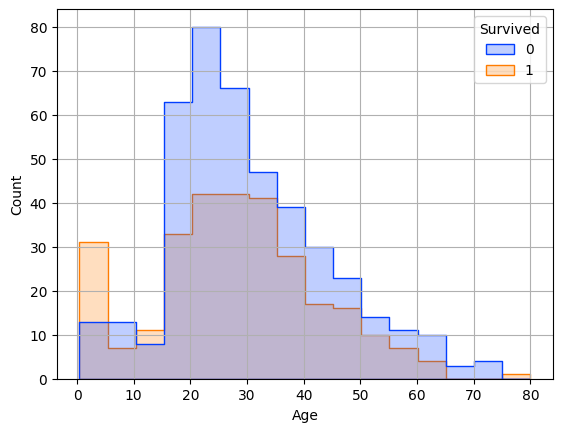

In [455]:
ax = sns.histplot(df, x="Age", hue="Survived", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

<Axes: xlabel='Survived', ylabel='Age'>

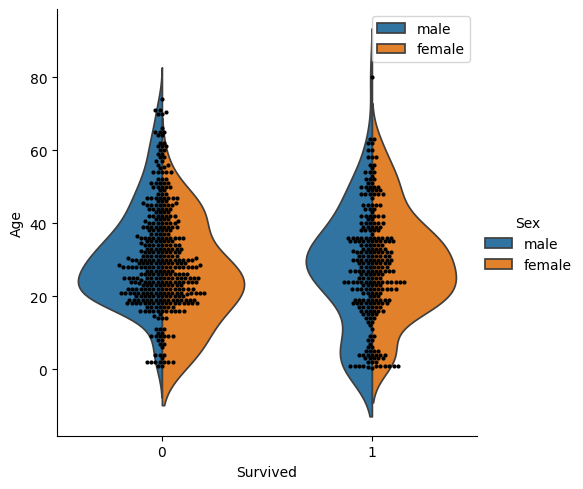

In [47]:
g = sns.catplot(df, kind="violin", x="Survived", y="Age", split=True, hue="Sex", inner=None)
sns.swarmplot(df, x="Survived", y="Age", ax=g.ax, color='k', size=3)

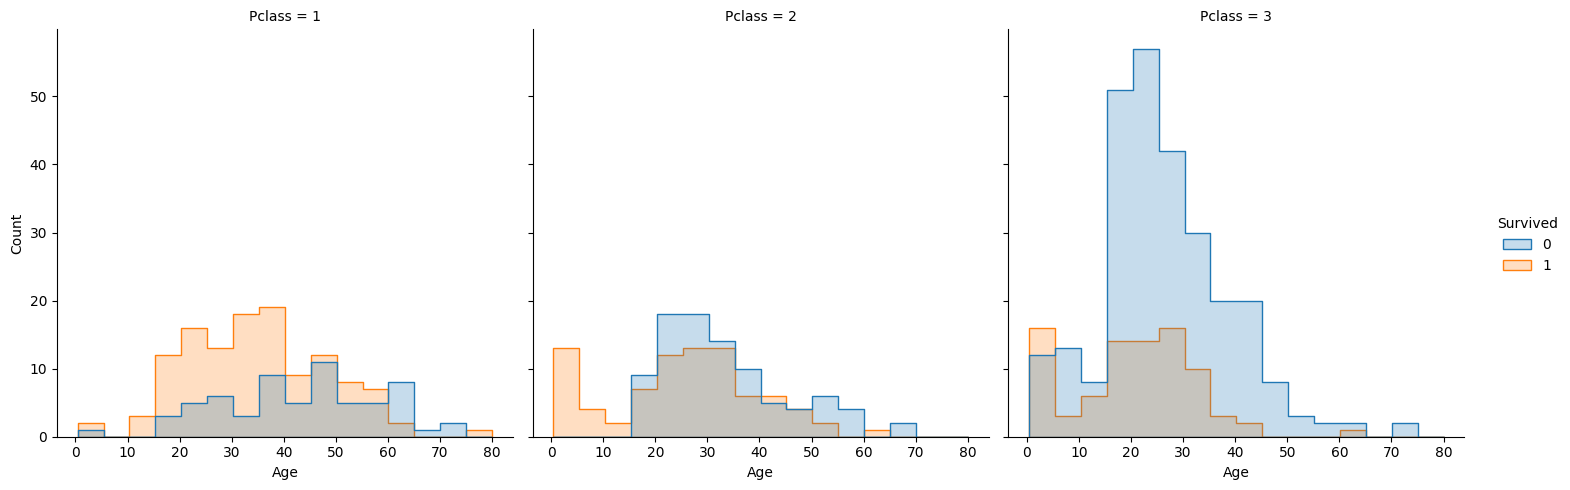

In [54]:
g = sns.displot(df, x="Age", hue="Survived", col="Pclass", binwidth=5, element="step")

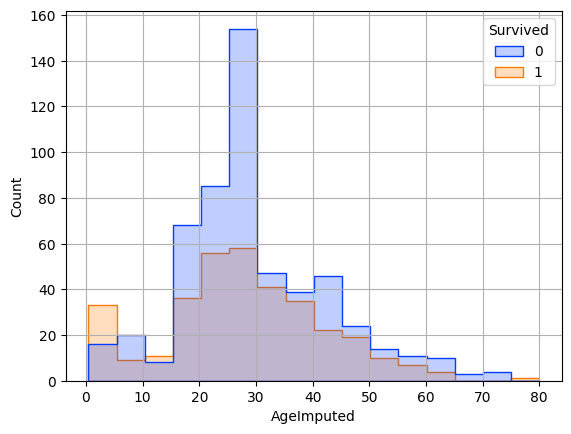

In [166]:
ax = sns.histplot(df, x="AgeImputed", hue="Survived", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

## Age vs. Pclass

In [167]:
print(df.groupby(["Pclass"]).Age.describe())
print("")
print(df.groupby(["Pclass"]).AgeImputed.describe())
print("")

        count       mean        std   min   25%   50%   75%   max
Pclass                                                           
1       186.0  38.233441  14.802856  0.92  27.0  37.0  49.0  80.0
2       173.0  29.877630  14.001077  0.67  23.0  29.0  36.0  70.0
3       355.0  25.140620  12.495398  0.42  18.0  24.0  32.0  74.0

        count       mean        std   min   25%   50%   75%   max
Pclass                                                           
1       216.0  38.923241  13.904000  0.92  29.0  39.0  48.0  80.0
2       184.0  29.884946  13.573790  0.67  23.0  30.0  36.0  70.0
3       491.0  24.796171  11.342772  0.42  19.0  26.0  29.0  74.0



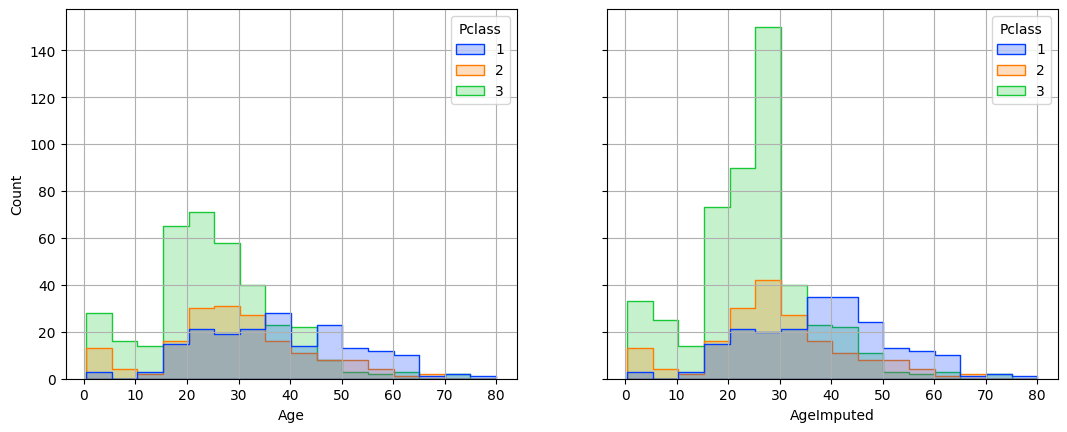

In [176]:
# ax = sns.histplot(df, x="Age", hue="Pclass", stat="probability", \
#                   binwidth=5, common_norm=False, multiple="layer", \
#                   element="step", palette="bright", \
#                     kde=False, kde_kws={"bw_adjust": 0.5})

f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.histplot(df, x="Age", hue="Pclass", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright", ax=axs[0])
sns.histplot(df, x="AgeImputed", hue="Pclass", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright", ax=axs[1])
axs[0].grid()
axs[1].grid()

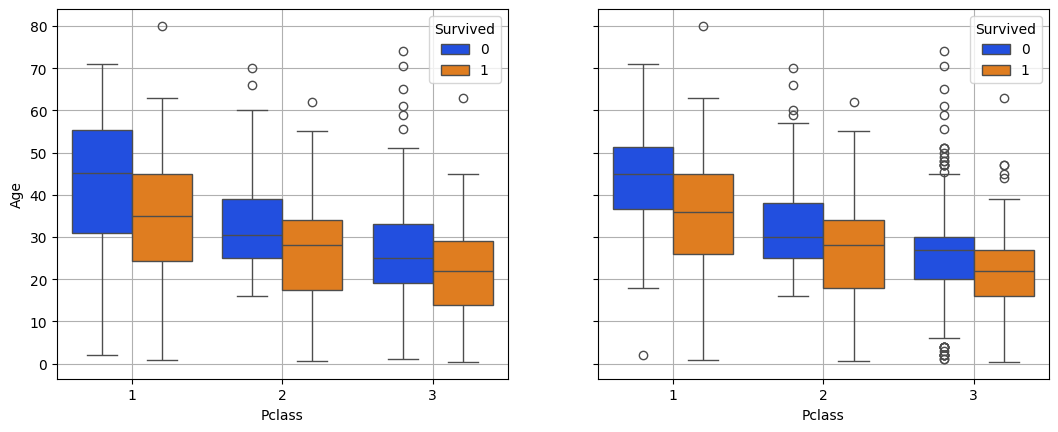

In [177]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.boxplot(df, x="Pclass", y="Age", hue="Survived", palette="bright", ax=axs[0])
sns.boxplot(df, x="Pclass", y="AgeImputed", hue="Survived", palette="bright", ax=axs[1])
axs[0].grid()
axs[1].grid()

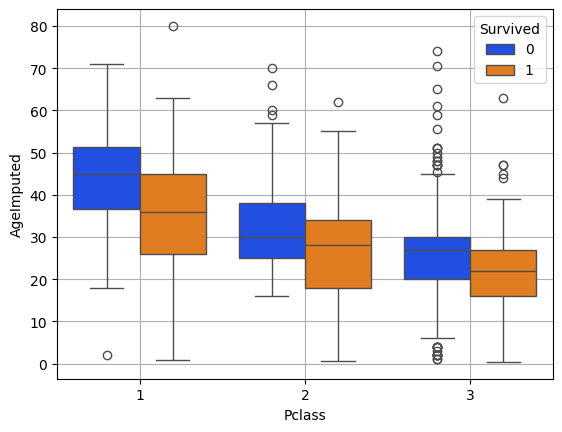

In [169]:
ax = sns.boxplot(df, x="Pclass", y="AgeImputed", hue="Survived", palette="bright")
ax.grid()

## Age vs. Sex

In [26]:
df.groupby(["Sex"]).Age.describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.0,27.915709,14.110146,0.75,18.0,27.0,37.0,63.0
male,453.0,30.726645,14.678201,0.42,21.0,29.0,39.0,80.0


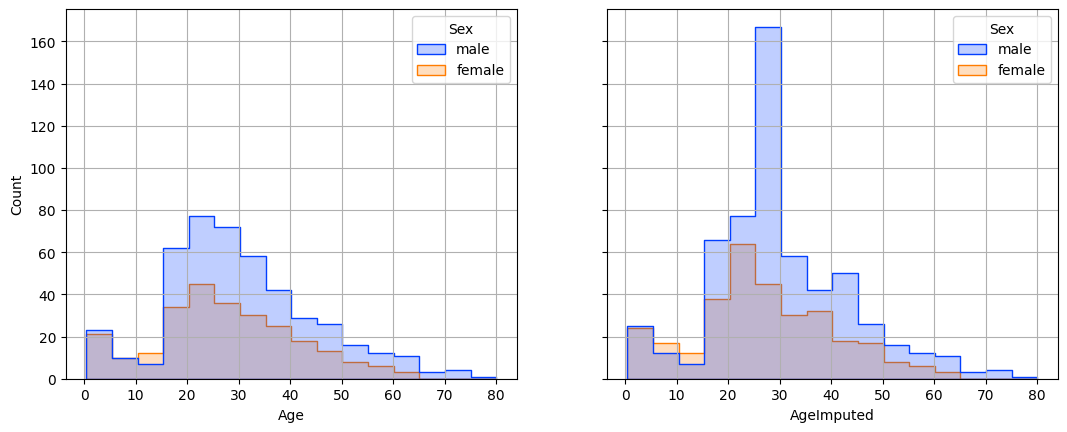

In [178]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))

sns.histplot(df, x="Age", hue="Sex", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright", ax=axs[0])
sns.histplot(df, x="AgeImputed", hue="Sex", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright", ax=axs[1])
axs[0].grid()
axs[1].grid()

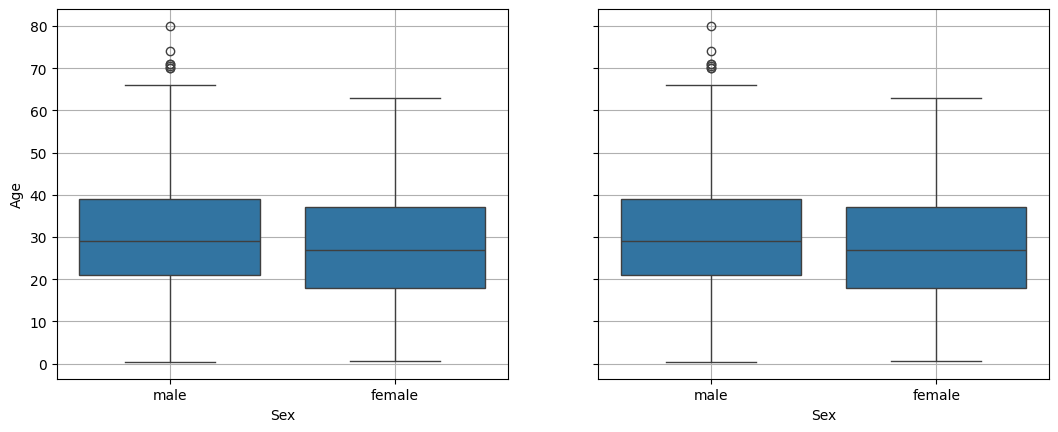

In [179]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.boxplot(df, x="Sex", y="Age", ax=axs[0])
sns.boxplot(df, x="Sex", y="Age", ax=axs[1])
axs[0].grid()
axs[1].grid()

## Age vs. TotalFam

In [36]:
famgroups = df["TotalFam"].map(lambda x: x if x <= 2 else 3)

In [38]:
# df.groupby(["TotalFam"]).Age.describe()
df.groupby(famgroups).Age.describe()

,count,mean,std,min,25%,50%,75%,max
TotalFam,,,,,,,,
0,404.0,32.220297,12.899871,5.00,22.00,29.5,39.00,80.0
1,139.0,31.391511,13.484379,0.42,22.00,29.0,42.00,65.0
2,93.0,26.035806,16.542123,0.67,15.00,27.0,37.00,70.0
3,78.0,17.992564,15.384191,0.75,4.25,14.0,25.75,64.0


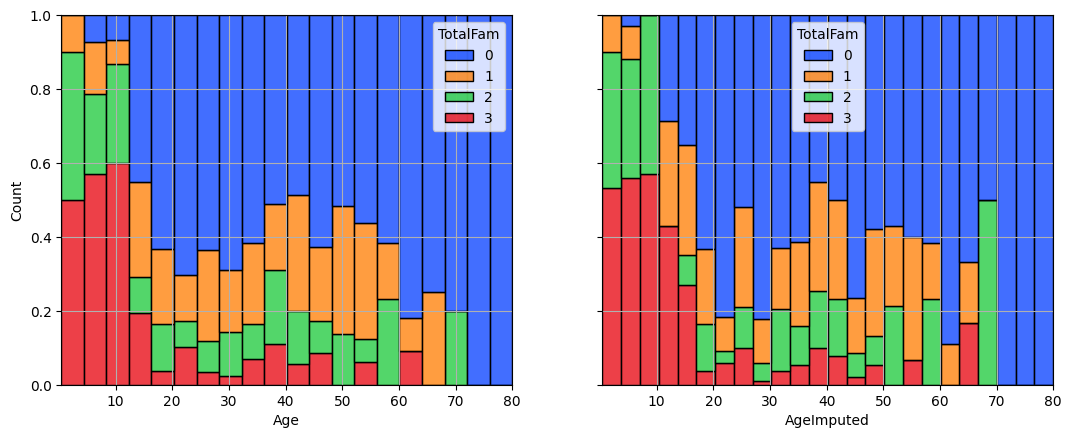

In [180]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))


sns.histplot(df, x="Age", hue=famgroups, palette="bright", multiple="fill", ax=axs[0])
sns.histplot(df, x="AgeImputed", hue=famgroups, palette="bright", multiple="fill", ax=axs[1])

axs[0].grid()
axs[1].grid()

## Age vs. Fare

In [ ]:
agebracket = (np.floor(df["Age"]/20)+1)*20

In [52]:
df.groupby(agebracket).Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
20.0,164.0,31.794741,42.632362,0.0000,9.316675,19.2583,31.3875,263.0000
40.0,387.0,32.931200,58.927518,0.0000,7.925000,13.0000,27.7500,512.3292
60.0,137.0,41.481784,45.653935,0.0000,13.000000,26.2500,52.5542,247.5208
80.0,25.0,44.006668,52.252063,6.2375,10.500000,26.5500,61.9792,263.0000
100.0,1.0,30.000000,NaN,30.0000,30.000000,30.0000,30.0000,30.0000


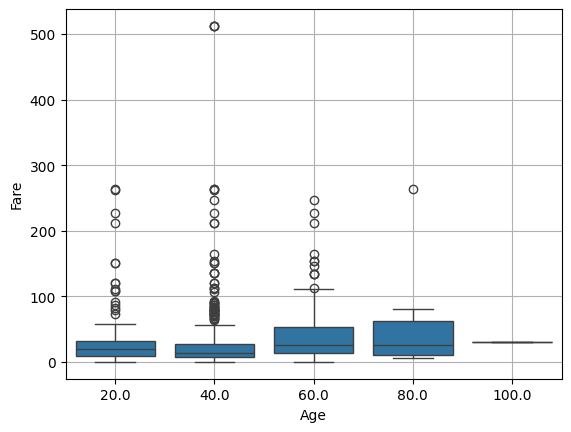

In [54]:
ax = sns.boxplot(df, x=agebracket, y="Fare")
ax.grid()

In [56]:
print(df["Fare"].describe())
print(np.quantile(df["Fare"], 0.9))
print(np.quantile(df["Fare"], 0.95))

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64
77.9583
112.07915


In [130]:
def get_farebracket(x):
    # if x <= 8:
    #     return 8
    # elif x <= 15:
    #     return 15
    # elif x <= 31:
    #     return 31
    # elif x <= 78:
    #     return 78
    # else:
    #     return 550
    if x <= 20:
        return 20
    else:
        return 550

farebrackets = df["Fare"].map(get_farebracket)

In [131]:
df.groupby(farebrackets).Age.describe()

,count,mean,std,min,25%,50%,75%,max
Fare,,,,,,,,
20,391.0,28.012583,12.244476,0.42,20.0,26.0,34.0,74.0
550,323.0,31.740712,16.674316,0.83,21.0,32.0,44.0,80.0


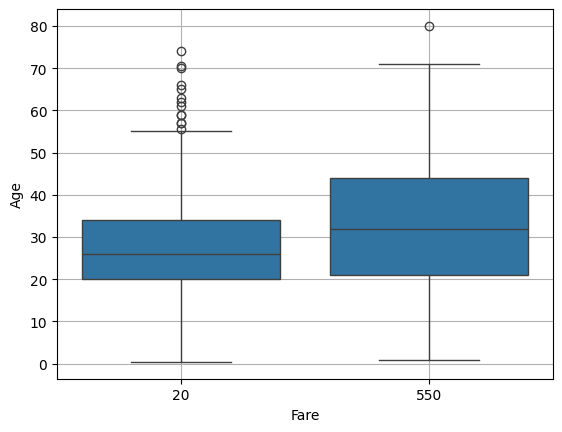

In [132]:
ax = sns.boxplot(df, x=farebrackets, y="Age")
ax.grid()

## Age imputation

In [95]:
def get_farebracket(x):
    if x <= 8:
        return 8
    elif x <= 15:
        return 15
    elif x <= 31:
        return 31
    elif x <= 78:
        return 78
    else:
        return 550

farebrackets = df["Fare"].map(get_farebracket)

In [163]:
import re
from sklearn.base import BaseEstimator, TransformerMixin

valid_titles = ["Mr", "Miss", "Mrs", "Master", "Dr", "Rev", "Unknown"]
# categories = None
to_replace = {
    "Mlle": "Miss",
    "Mme": "Mrs",
    "Ms": "Miss",
}

class TitleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, to_replace=None, valid_titles=None, fallback="Unknown"):
        self.to_replace = to_replace
        self.valid_titles = valid_titles
        self.fallback = fallback
        self.pattern = re.compile(r"\b([a-zA-Z]+?)\.")

    def _extract_one(self, name):
        if isinstance(name, str):
            match = self.pattern.search(name)
            if match:
                return match.group(1)
        return self.fallback

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_clean = X.map(self._extract_one).iloc[:, 0]
        if self.to_replace:
            X_clean = X_clean.replace(self.to_replace)
        if self.valid_titles:
            X_clean.loc[~X_clean.isin(self.valid_titles)] = self.fallback
        return X_clean.to_frame()

title_extractor = TitleExtractor(to_replace=to_replace, valid_titles=valid_titles)

In [165]:
df["Title"] = title_extractor.transform(df[["Name"]])
df["Title"].value_counts()

Title
Mr         517
Miss       185
Mrs        126
Master      40
Unknown     10
Dr           7
Rev          6
Name: count, dtype: int64

In [ ]:
print(df.groupby(["Sex"]).Age.describe())
print("")
print(df.groupby(["Title"]).Age.describe())
print("")
print(df.groupby(["Pclass"]).Age.describe())
print("")
print(df.groupby(["TotalFam"]).Age.describe())
print("")
print(df.groupby(["Pclass"]).Fare.describe())
print("")

        count       mean        std   min   25%   50%   75%   max
Sex                                                              
female  261.0  27.915709  14.110146  0.75  18.0  27.0  37.0  63.0
male    453.0  30.726645  14.678201  0.42  21.0  29.0  39.0  80.0

         count       mean        std    min    25%   50%    75%   max
Title                                                                
Dr         6.0  42.000000  12.016655  23.00  35.00  46.5  49.75  54.0
Master    36.0   4.574167   3.619872   0.42   1.00   3.5   8.00  12.0
Miss     149.0  21.845638  12.870542   0.75  14.50  21.0  30.00  63.0
Mr       398.0  32.368090  12.708793  11.00  23.00  30.0  39.00  80.0
Mrs      109.0  35.788991  11.437490  14.00  27.00  35.0  44.00  63.0
Rev        6.0  43.166667  13.136463  27.00  31.50  46.5  53.25  57.0
Unknown   10.0  49.100000  11.029758  33.00  41.25  48.5  55.00  70.0

        count       mean        std   min   25%   50%   75%   max
Pclass                                

In [176]:
print(df[["Age", "Fare"]].corr())
print("")
print(df[["Age", "Pclass"]].corr())
print("")
print(df[["Age", "TotalFam"]].corr())
print("")

           Age      Fare
Age   1.000000  0.096067
Fare  0.096067  1.000000

             Age    Pclass
Age     1.000000 -0.369226
Pclass -0.369226  1.000000

               Age  TotalFam
Age       1.000000 -0.301914
TotalFam -0.301914  1.000000



In [177]:
print(df[["Age", "Fare"]].corr(method="kendall"))
print("")
print(df[["Age", "Pclass"]].corr(method="kendall"))
print("")
print(df[["Age", "TotalFam"]].corr(method="kendall"))
print("")

           Age      Fare
Age   1.000000  0.093249
Fare  0.093249  1.000000

             Age    Pclass
Age     1.000000 -0.286081
Pclass -0.286081  1.000000

               Age  TotalFam
Age       1.000000 -0.172862
TotalFam -0.172862  1.000000



In [ ]:
print(df[["Age", "Fare"]].corr(method="spearman"))
print("")
print(df[["Age", "Pclass"]].corr(method="spearman"))
print("")
print(df[["Age", "TotalFam"]].corr(method="spearman"))
print("")

           Age      Fare
Age   1.000000  0.135051
Fare  0.135051  1.000000

             Age    Pclass
Age     1.000000 -0.361666
Pclass -0.361666  1.000000

               Age  TotalFam
Age       1.000000 -0.228168
TotalFam -0.228168  1.000000



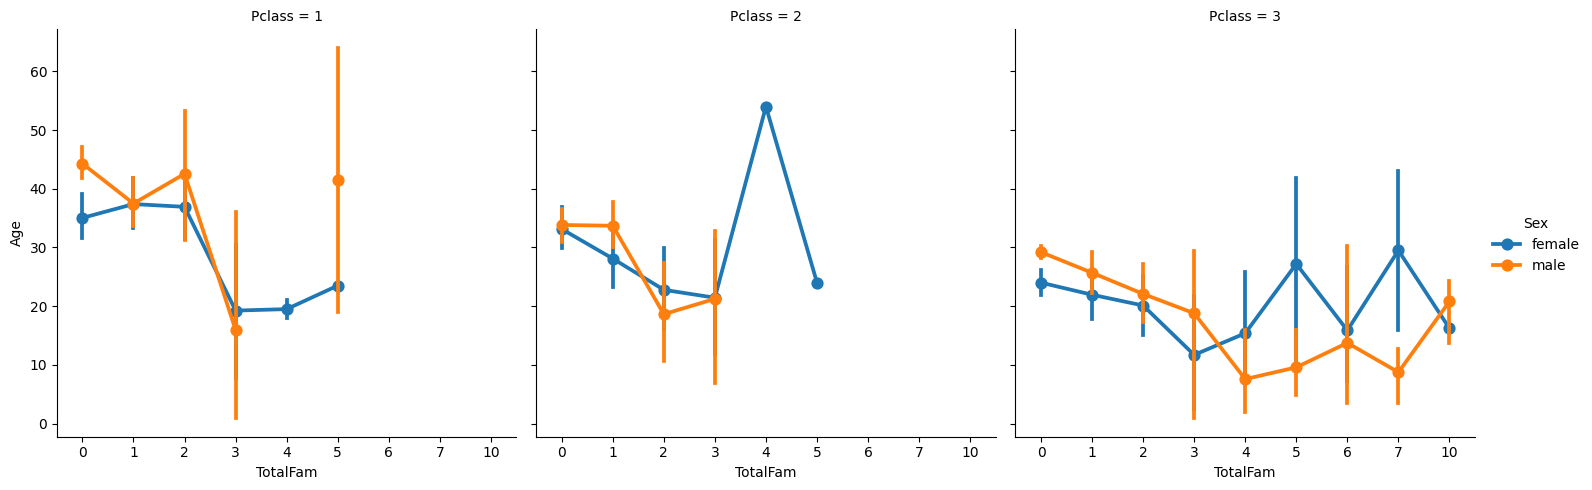

In [361]:
# sns.catplot(df, x="TotalFam", y="Age", hue="Sex", col="Pclass", kind="point")
sns.catplot(df_prep, x="TotalFam", y="Age", hue="Sex", col="Pclass", kind="point")
plt.show()

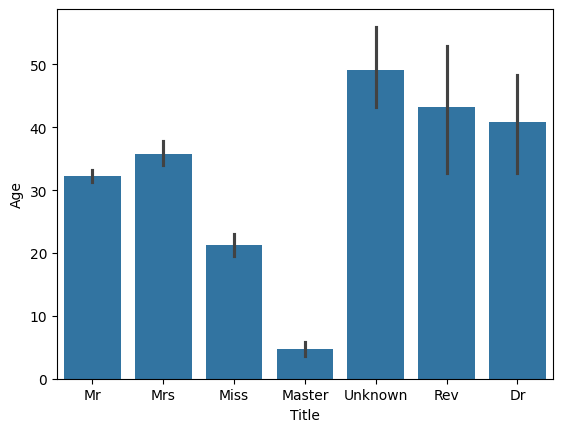

In [360]:
sns.barplot(df_prep, x="Title", y="Age")
plt.show()

In [201]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names: list[str], model):
        self.feature_names = feature_names
        self.model = model
    
    def fit(self, X, y=None):
        X = X.dropna(subset=["Age"])
        X_train = X[self.feature_names].copy()
        y_train = X["Age"].copy()
        self.model.fit(X_train, y_train)
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_pred = X_transformed.loc[X_transformed["Age"].isna(), [self.feature_names]]
        y_pred = self.model.predict(X_pred)
        X_transformed["Age"] = X_transformed["Age"].fillna(y_pred)
        return X_transformed


In [350]:
df["AgeImputed"] = df_prep["Age"]

In [352]:
df["AgeImputed"].isna().sum()

np.int64(0)

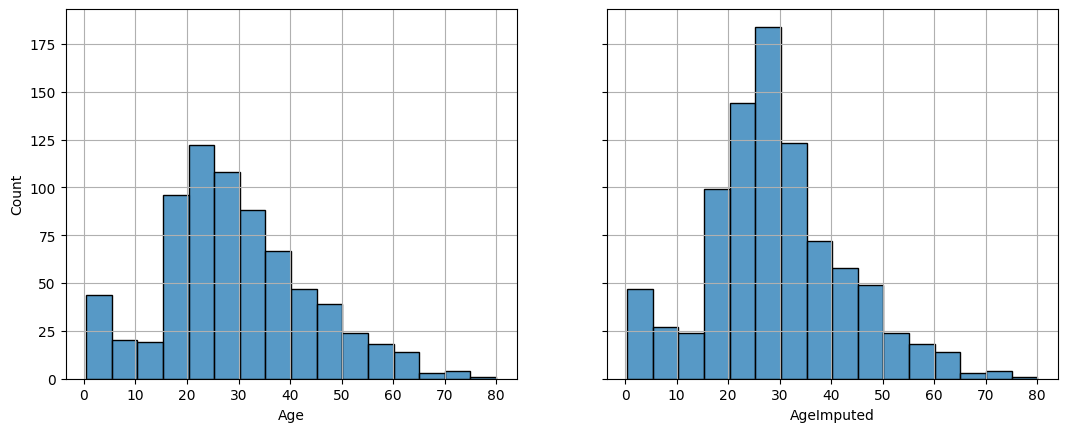

In [353]:
f, axs = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[12.8, 4.8])
sns.histplot(df, x="Age", binwidth=5, ax=axs[0])
sns.histplot(df, x="AgeImputed", ax=axs[1], binwidth=5)
axs[0].grid()
axs[1].grid()

In [157]:
pd.set_option('display.max_rows', None)
df.loc[df["AgeMissing"] == True].groupby(["Titles", "Pclass", famgroups]).AgeMissing.count().sort_values(ascending=False)

Titles   Pclass  TotalFam
Mr.      3       0           77
         1       0           21
Miss.    3       0           19
Mr.      2       0            9
Miss.    3       3            7
Mrs.     1       1            7
Mr.      3       1            7
Mrs.     3       1            4
Mr.      3       3            4
Miss.    3       1            4
Mrs.     3       0            3
Miss.    3       2            3
         2       0            2
Master.  3       2            2
                 3            2
Mrs.     3       2            2
Mr.      3       2            2
Miss.    1       0            1
Mrs.     1       0            1
Name: AgeMissing, dtype: int64

## Missing Age pattern

In [101]:
df["AgeMissing"] = df["Age"].isna()

print(df["AgeMissing"].mean())
print("")
print(df.groupby(["AgeMissing"]).Survived.mean())
print("")
print(df.groupby(["Pclass"]).AgeMissing.mean().sort_index())
print("")
print(df.groupby(["Sex"]).AgeMissing.mean().sort_index())
print("")
print(df.groupby(["TotalFam"]).AgeMissing.mean().sort_index())
print("")
print(df.groupby(["AgeMissing"]).Fare.agg(["min", lambda x: x.quantile(0.25), "median", lambda x: x.quantile(0.75), "max"]))
print("")

0.19865319865319866

AgeMissing
False    0.406162
True     0.293785
Name: Survived, dtype: float64

Pclass
1    0.138889
2    0.059783
3    0.276986
Name: AgeMissing, dtype: float64

Sex
female    0.168790
male      0.214905
Name: AgeMissing, dtype: float64

TotalFam
0     0.247672
1     0.136646
2     0.088235
3     0.068966
4     0.266667
5     0.000000
6     0.000000
7     0.000000
10    1.000000
Name: AgeMissing, dtype: float64

            min  <lambda_0>   median  <lambda_1>       max
AgeMissing                                                
False       0.0        8.05  15.7417      33.375  512.3292
True        0.0        7.75   8.0500      24.150  227.5250



In [263]:
df_test["AgeMissing"] = df_test["Age"].isna()

print(df_test["AgeMissing"].mean())
print("")
print(df_test.groupby(["Pclass"]).AgeMissing.mean().sort_index())
print("")
print(df_test.groupby(["Sex"]).AgeMissing.mean().sort_index())
print("")
print(df_test.groupby(["TotalFam"]).AgeMissing.mean().sort_index())
print("")
print(df_test.groupby(["AgeMissing"]).Fare.agg(["min", lambda x: x.quantile(0.25), "median", lambda x: x.quantile(0.75), "max"]))
print("")

0.20574162679425836

Pclass
1    0.084112
2    0.053763
3    0.330275
Name: AgeMissing, dtype: float64

Sex
female    0.164474
male      0.229323
Name: AgeMissing, dtype: float64

TotalFam
0     0.264822
1     0.094595
2     0.105263
3     0.142857
4     0.142857
5     0.000000
6     0.000000
7     0.000000
10    0.750000
Name: AgeMissing, dtype: float64

            min  <lambda_0>   median  <lambda_1>       max
AgeMissing                                                
False       0.0        8.05  16.0000    40.63335  512.3292
True        0.0        7.75   7.9729    15.55940   69.5500



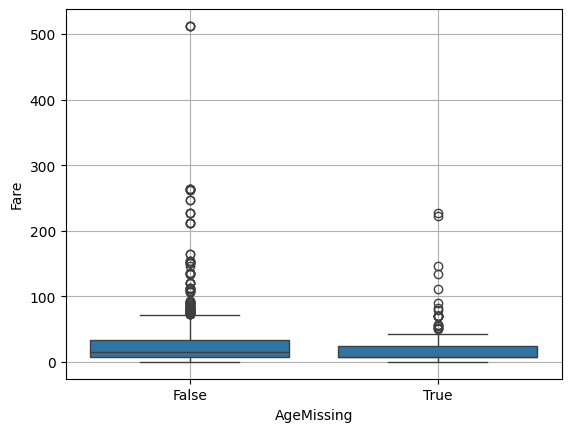

In [358]:
# ax = sns.countplot(df, x="AgeMissing", hue="Survived", stat="probability", palette="bright")
ax = sns.boxplot(df, x="AgeMissing", y="Fare")
ax.grid()

# SibSp, Parch - passthrough, and also add together to create TotalFam

Analysis:
* Most people have 0 to 2 family members on board. If you have 0 family members on board, your rate of survival is much less.

In [259]:
df["TotalFam"] = df["SibSp"] + df["Parch"]
df_test["TotalFam"] = df_test["SibSp"] + df_test["Parch"]
df["TotalFam"].value_counts().sort_index()

TotalFam
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64

In [5]:
df["SibSp"].value_counts().sort_index()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: count, dtype: int64

In [396]:
df.groupby(["SibSp"]).Survived.mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

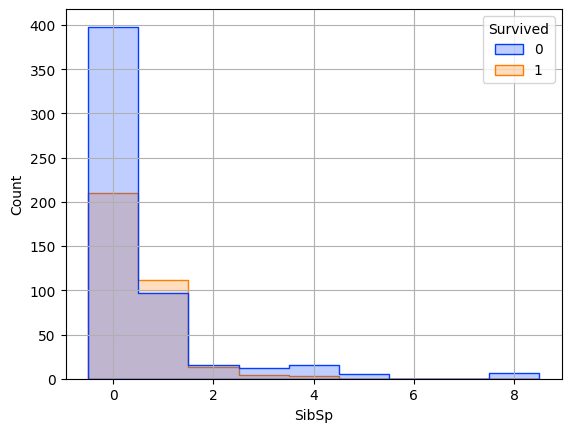

In [391]:
ax = sns.histplot(df, x="SibSp", hue="Survived", \
                  discrete=True, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

In [260]:
df["Parch"].value_counts().sort_index()

Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: count, dtype: int64

In [397]:
df.groupby(["Parch"]).Survived.mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

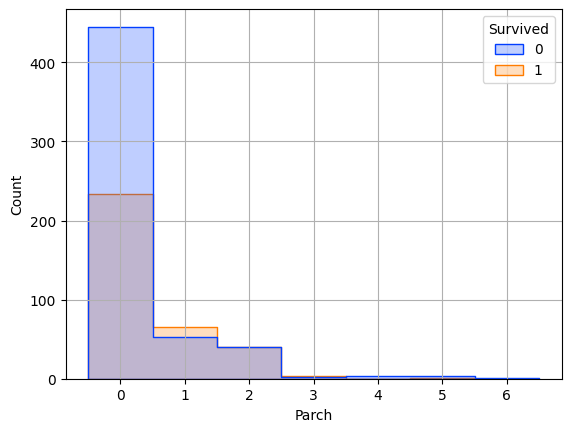

In [392]:
ax = sns.histplot(df, x="Parch", hue="Survived", \
                  discrete=True, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

In [ ]:
df.groupby(["TotalFam"]).Survived.mean()

TotalFam
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

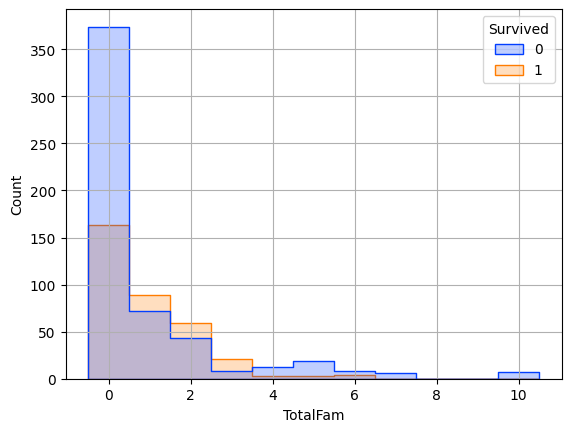

In [393]:
ax = sns.histplot(df, x="TotalFam", hue="Survived", \
                  discrete=True, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

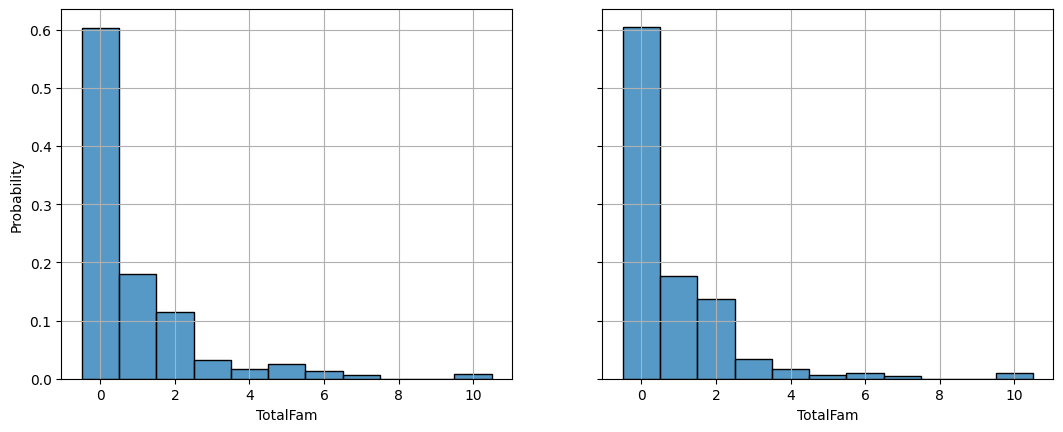

In [264]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.histplot(df, x="TotalFam", discrete=True, ax=axs[0], stat="probability")
sns.histplot(df_test, x="TotalFam", discrete=True, ax=axs[1], stat="probability")
axs[0].grid()
axs[1].grid()

## TotalFam vs. other features

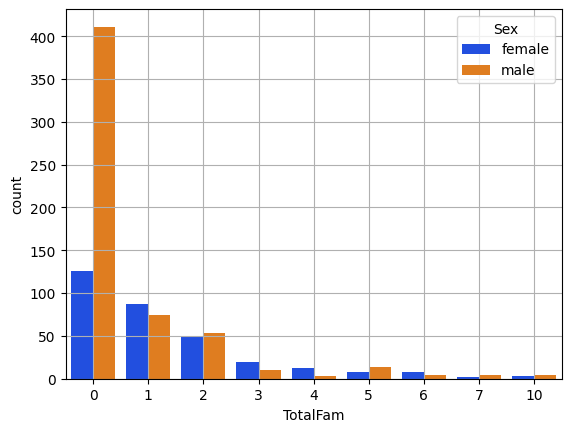

In [24]:
ax = sns.countplot(df, x="TotalFam", hue="Sex", palette="bright")
ax.grid()

# Fare - passthrough

Analysis:
* Lower Fare = lower rate of survival (I imagine it's similar to Pclass)

In [271]:
df["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

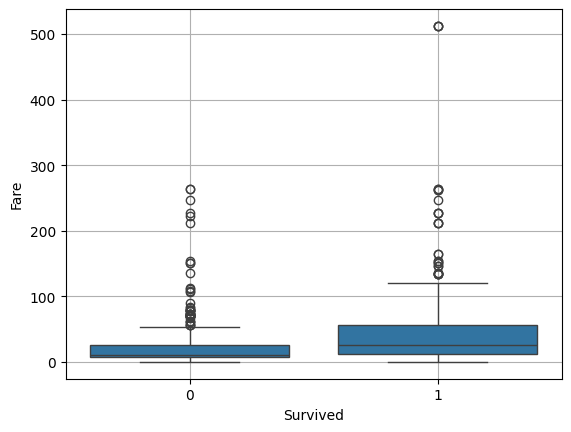

In [279]:
ax = sns.boxplot(df, y="Fare", x="Survived")
ax.grid()

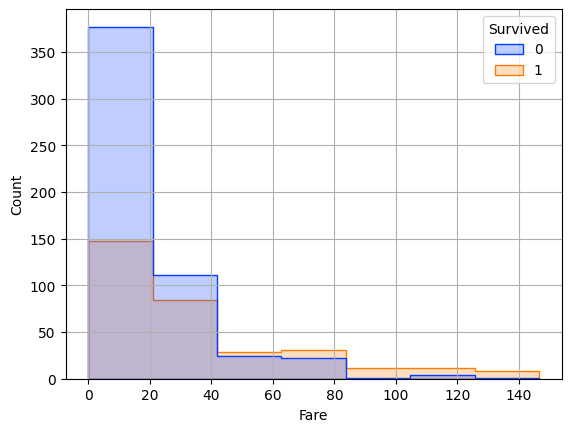

In [399]:
ax = sns.histplot(df.loc[df["Fare"] <= 150], x="Fare", hue="Survived", \
                  multiple="layer", binwidth=20, \
                  element="step", palette="bright")
ax.grid()

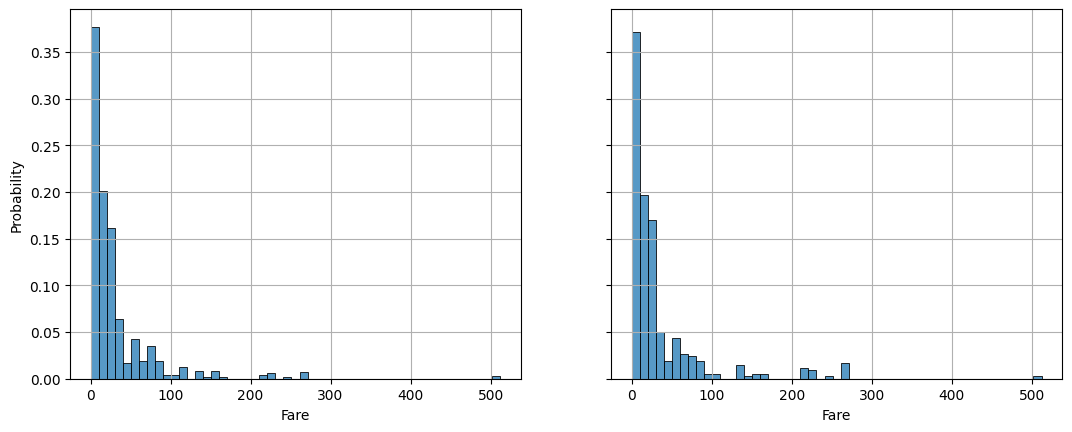

In [283]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.histplot(df, x="Fare", binwidth=10, ax=axs[0], stat="probability")
sns.histplot(df_test, x="Fare", binwidth=10, ax=axs[1], stat="probability")
axs[0].grid()
axs[1].grid()

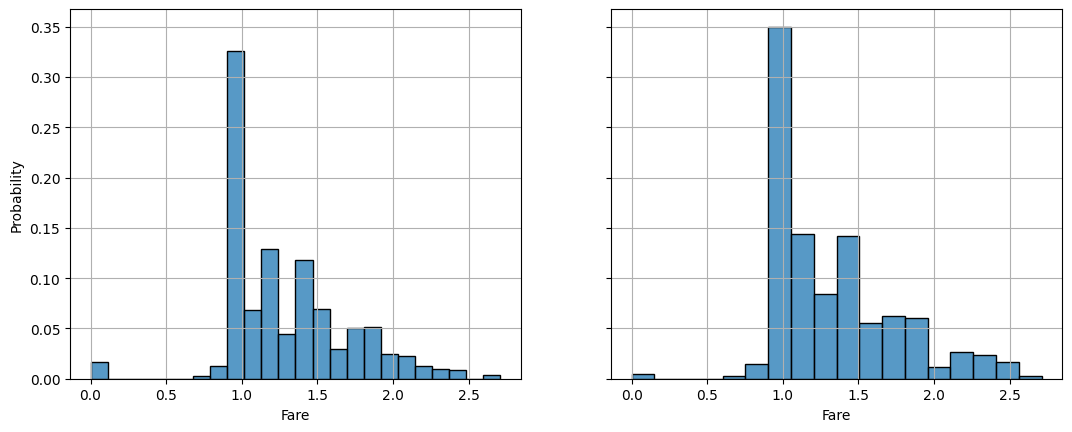

In [285]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.histplot(df, x=np.log10(df["Fare"]+1), ax=axs[0], stat="probability")
sns.histplot(df_test, x=np.log10(df_test["Fare"]+1), ax=axs[1], stat="probability")
axs[0].grid()
axs[1].grid()

# Name

Analysis:
* 4 main titles: Mr., Master., Mrs., Miss.
    * Master is for really young males
    * Mrs vs. Miss: Miss is younger, usually doesn't have family, and is much more likely to be in Pclass3
        * Set Miss = less than 30 years and no family

In [533]:
df["Name"].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [547]:
import re

pattern = r"\b([a-zA-Z]+?)\."
name_pattern = re.compile(pattern)

def name_proc(x):
    # return x.strip().split(",")[1].strip().split()[0]
    m = name_pattern.search(x)
    return m.group(1)

df["Title"] = df["Name"].map(name_proc)

df["Title"].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

In [584]:
# Mlle -> Miss
# Mme -> Mrs
# Ms -> Miss
categories = ["Mr", "Miss", "Mrs", "Master", "Dr", "Rev"]
to_replace = {
    "Mlle": "Miss",
    "Mme": "Mrs",
    "Ms": "Miss",
}

In [589]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class NameEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories: list[str] | None = None, to_replace: dict[str, str] | None = None):
        self.categories = [categories]
        self.to_replace = to_replace
        self.encoder = OneHotEncoder(categories=self.categories, handle_unknown="infrequent_if_exist")
        self.pattern = re.compile(r"\b([a-zA-Z]+?)\.")
    
    def _extract_title(self, X):
        return X.map(lambda x: self.pattern.search(x).group(1))

    def fit(self, X, y=None):
        X = self._extract_title(X.copy()).replace(self.to_replace)
        self.encoder.fit(X.to_frame())
        return self
    
    def transform(self, X):
        X = self._extract_title(X.copy()).replace(self.to_replace)
        return self.encoder.transform(X.to_frame())

In [595]:
categories = ["Mr", "Miss", "Mrs", "Master", "Dr", "Rev"]
to_replace = {
    "Mlle": "Miss",
    "Mme": "Mrs",
    "Ms": "Miss",
}

name_enc = NameEncoder(categories, to_replace)
name_enc.fit_transform(df["Name"])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 881 stored elements and shape (891, 6)>

In [549]:
df_test["Title"] = df_test["Name"].map(name_proc)

df_test["Title"].value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [270]:
titles_small_samples = df["Title"].value_counts().index[df["Title"].value_counts() < 10]
df.loc[(df["Title"].isin(titles_small_samples)) & \
       (df["Sex"] == "female") & (df["Age"] <= 30), "Title"] = "Miss."
df.loc[(df["Title"].isin(titles_small_samples)) & \
       (df["Sex"] == "female") & (df["Age"] > 30), "Title"] = "Mrs."
df.loc[(df["Title"].isin(titles_small_samples)) & \
       (df["Sex"] == "male") & (df["Age"] > 12), "Title"] = "Mr."
df.loc[(df["Title"] == "Dr.") & (df["Sex"] == "male"), "Title"] = "Mr."

df["Title"].value_counts()

Title
Mr.        537
Miss.      186
Mrs.       128
Master.     40
Name: count, dtype: int64

In [272]:
df_test.loc[(df_test["Title"].isin(titles_small_samples)) & \
       (df_test["Sex"] == "female") & (df_test["Age"] <= 30), "Title"] = "Miss."
df_test.loc[(df_test["Title"].isin(titles_small_samples)) & \
       (df_test["Sex"] == "female") & (df_test["Age"] > 30), "Title"] = "Mrs."
df_test.loc[(df_test["Title"].isin(titles_small_samples)) & \
       (df_test["Sex"] == "male") & (df_test["Age"] > 12), "Title"] = "Mr."
df_test.loc[(df_test["Title"] == "Dr.") & (df_test["Sex"] == "male"), "Title"] = "Mr."

df_test["Title"].value_counts()

Title
Mr.        245
Miss.       78
Mrs.        72
Master.     21
Ms.          1
Dona.        1
Name: count, dtype: int64

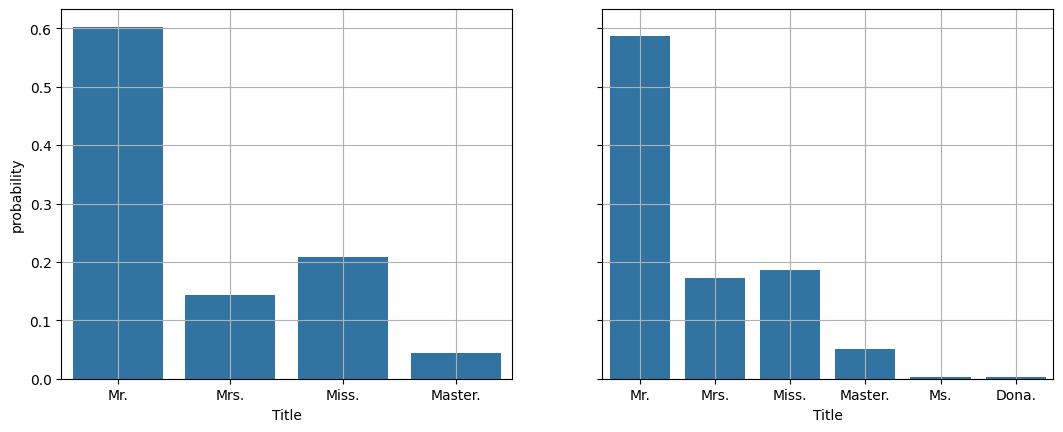

In [274]:
f, axs = plt.subplots(ncols=2, sharey=True, figsize=(12.8, 4.8))
sns.countplot(df, x="Title", ax=axs[0], stat="probability")
sns.countplot(df_test, x="Title", ax=axs[1], stat="probability")
axs[0].grid()
axs[1].grid()

In [ ]:
print(df.groupby(["Sex"]).Title.unique())
print("")
print(df.groupby(["Title"]).Age.describe().sort_values("count", ascending=False))
print("")
print(df.loc[df["Title"].isin(["Miss.", "Mrs."])].groupby(["TotalFam"]).Title.value_counts().sort_index())
print("")
print(df.loc[df["Title"].isin(["Miss.", "Mrs."])].groupby("Pclass").Title.value_counts().sort_index())

Sex
female     [Mrs., Miss.]
male      [Mr., Master.]
Name: Titles, dtype: object

         count       mean        std    min     25%   50%   75%   max
Titles                                                               
Mr.      417.0  32.984412  12.988220  11.00  23.000  30.0  40.0  80.0
Miss.    150.0  21.860000  12.828485   0.75  14.625  21.5  30.0  63.0
Mrs.     111.0  36.099099  11.405704  14.00  28.000  35.0  44.5  63.0
Master.   36.0   4.574167   3.619872   0.42   1.000   3.5   8.0  12.0

TotalFam  Titles
0         Miss.     104
          Mrs.       22
1         Miss.      27
          Mrs.       60
2         Miss.      22
          Mrs.       27
3         Miss.      10
          Mrs.        9
4         Miss.       9
          Mrs.        3
5         Miss.       4
          Mrs.        4
6         Miss.       6
          Mrs.        2
7         Miss.       1
          Mrs.        1
10        Miss.       3
Name: count, dtype: int64

Pclass  Titles
1       Miss.      49
       

## Investigate titles

In [ ]:
titles_small_samples = df["Title"].value_counts().index[df["Title"].value_counts() < 10]

In [ ]:
df.loc[(df["Title"].isin(titles_small_samples)) & (df["Sex"] == "female")].sort_values(by="Age")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam,Titles,AgeMissing
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C,0,Mme.,False
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,0,Mlle.,False
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C,0,Mlle.,False
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S,0,Ms.,False
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S,0,the,False
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,1,Lady.,False
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,0,Dr.,False


In [ ]:
df.loc[(df["Title"].isin(titles_small_samples)) & (df["Sex"] == "male")].sort_values(by="Age")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam,Titles,AgeMissing
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,0,Dr.,False
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Rev.,False
848,849,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S,1,Rev.,False
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,0,Dr.,False
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S,0,Jonkheer.,False
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,0,Don.,False
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S,0,Rev.,False
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,2,Dr.,False
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S,0,Major.,False
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,1,Sir.,False


# Ticket - drop

In [269]:
df["Ticket"].sample(20)

459             371060
252             113514
408             312992
357             237671
384             349227
795              28213
500             315086
176               4133
856              36928
391             350034
568               2686
870             349248
63              347088
310              11767
739             349218
11              113783
157    SOTON/OQ 392090
264             382649
471             315089
661               2623
Name: Ticket, dtype: object

# Cabin - ordinal encoding - passthrough, drop, missing indicator, or impute

Analysis:
* Non-missing Cabins is a very small sample size; survival rate is 67% which is much higher than overall. I'm not sure if you can infer anything from this.
* Some entries have multiple Cabins listed - for these, I will take the first one listed
* Some Cabins don't have numbers - put NaN for these
* PassengerId=340 - Cabin T (error). This is a first-class passenger, so this should be A through E. Set it to C as this is the mode of CabinLetter for first-class passengers.
* Survival distribution is exactly the same across CabinNumber (CabinNumber does not affect survival rate)

Missing analysis:
* Most Cabins are missing; survival rate for these is 30%, much lower than overall
* Mostly Pclass 2 or 3 passengers
* Having a Cabin is so strongly correlated with Pclass (which is correlated with Age and Fare); it may not add much information
* You should drop CabinNumber - no way to impute and most of the values are missing
* CabinLetter
    * Passthrough
    * Drop
    * Passthrough with additional missing category
    * Impute and add missing indicator feature
        * Impute by taking mode per Pclass - does this add any information on top of Pclass?
        * Impute using supervised learning with Pclass, Age, Fare

## CabinLetter, CabinNumber

In [275]:
def cab_letter(x):
    x = x.strip().split()[0][0]
    return x

def cab_number(x):
    x = x.strip().split()[0][1:]
    return x

df["CabinLetter"] = df["Cabin"].str[0].fillna("M")
df["CabinLetter"] = df["CabinLetter"].replace("T", "C")

print(df["CabinLetter"].value_counts().sort_index())
print("")
# df.loc[df["CabinNumber"] == "", "CabinNumber"] = np.nan
# df["CabinNumber"] = df["CabinNumber"].astype(float)
# df["CabinNumber"].describe()
df_test["CabinLetter"] = df_test["Cabin"].str[0].fillna("M")
print(df_test["CabinLetter"].value_counts().sort_index())

CabinLetter
A     15
B     47
C     60
D     33
E     32
F     13
G      4
M    687
Name: count, dtype: int64

CabinLetter
A      7
B     18
C     35
D     13
E      9
F      8
G      1
M    327
Name: count, dtype: int64


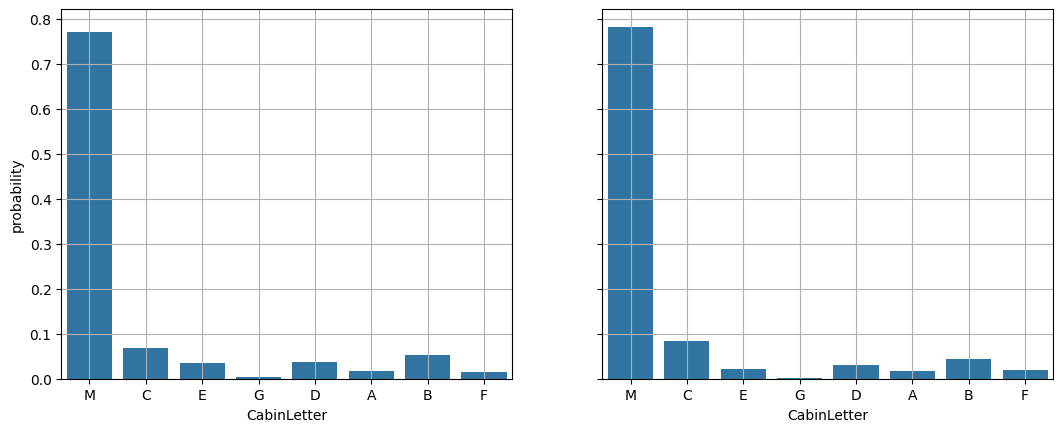

In [276]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.countplot(df, x="CabinLetter", ax=axs[0], stat="probability")
sns.countplot(df_test, x="CabinLetter", ax=axs[1], stat="probability")
axs[0].grid()
axs[1].grid()

In [28]:
print(df.groupby(["Pclass", "CabinLetter"]).PassengerId.count())
print(df.groupby(["CabinLetter"]).Survived.mean())
# print(df.groupby(["CabinLetter"]).Survived.value_counts())

Pclass  CabinLetter
1       A               15
        B               47
        C               60
        D               29
        E               25
        M               40
2       D                4
        E                4
        F                8
        M              168
3       E                3
        F                5
        G                4
        M              479
Name: PassengerId, dtype: int64
CabinLetter
A    0.466667
B    0.744681
C    0.583333
D    0.757576
E    0.750000
F    0.615385
G    0.500000
M    0.299854
Name: Survived, dtype: float64


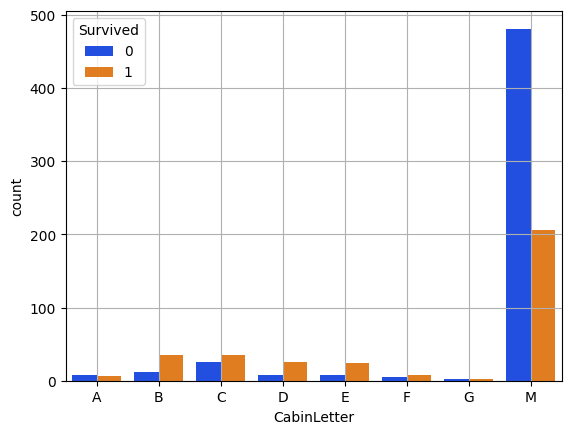

In [33]:
ax = sns.countplot(df, x="CabinLetter", order=sorted(df.CabinLetter.unique()), hue="Survived", palette="bright")
ax.grid()

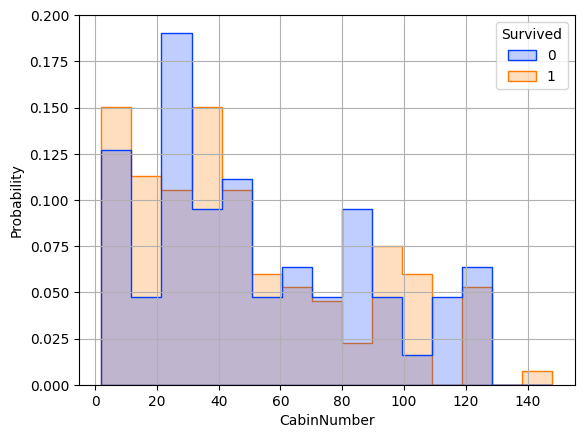

In [8]:
ax = sns.histplot(df, x="CabinNumber", binwidth=10, hue="Survived", palette="bright", multiple="layer", element="step", stat="probability", common_norm=False)
ax.grid()

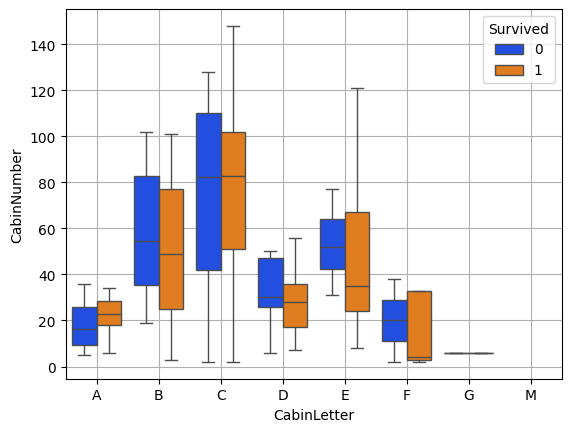

In [34]:
ax = sns.boxplot(df, x="CabinLetter", y="CabinNumber", hue="Survived", palette="bright", order=sorted(df.CabinLetter.unique()))
ax.grid()

## CabinLetter vs. other features

In [26]:
print(df.groupby(["Pclass"]).CabinLetter.value_counts().sort_index())
print("")
print(df.groupby(["CabinLetter"]).Age.describe())
print("")
# print(df.groupby(["TotalFam"]).CabinLetter.value_counts().sort_index())
print(df.groupby(["CabinLetter"]).TotalFam.describe())
print("")
print(df.groupby(["CabinLetter"]).Fare.describe())
print("")
# print(df.groupby(["Embarked"]).CabinLetter.value_counts().sort_index())
# print(df.groupby(["CabinLetter"]).Embarked.value_counts().sort_index())

Pclass  CabinLetter
1       A              15
        B              47
        C              60
        D              29
        E              25
2       D               4
        E               4
        F               8
3       E               3
        F               5
        G               4
Name: count, dtype: int64

             count       mean        std    min    25%   50%    75%   max
CabinLetter                                                              
A             12.0  44.833333  20.171237   4.00  34.75  44.0  56.00  80.0
B             45.0  34.955556  15.491868  11.00  24.00  33.0  44.00  70.0
C             52.0  36.258077  14.291361   0.92  25.75  36.5  47.25  64.0
D             31.0  39.032258  14.460253  16.00  25.00  37.0  50.00  63.0
E             30.0  38.116667  12.590146   6.00  30.50  39.0  47.00  65.0
F             11.0  19.954545  15.182975   1.00   3.50  24.0  31.50  42.0
G              4.0  14.750000  13.744696   2.00   3.50  14.0  25.25  29.0



,count,mean,std,min,25%,50%,75%,max
CabinLetter,,,,,,,,
A,12.0,44.833333,20.171237,4.00,34.75,44.0,56.00,80.0
B,45.0,34.955556,15.491868,11.00,24.00,33.0,44.00,70.0
C,52.0,36.258077,14.291361,0.92,25.75,36.5,47.25,64.0
D,31.0,39.032258,14.460253,16.00,25.00,37.0,50.00,63.0
E,30.0,38.116667,12.590146,6.00,30.50,39.0,47.00,65.0
F,11.0,19.954545,15.182975,1.00,3.50,24.0,31.50,42.0
G,4.0,14.750000,13.744696,2.00,3.50,14.0,25.25,29.0


## Missing Cabin

In [11]:
df["CabinMissing"] = df["Cabin"].isna()

print(df.groupby(["CabinMissing"]).Survived.mean())
df.groupby(["Pclass"]).CabinMissing.mean()

CabinMissing
False    0.666667
True     0.299854
Name: Survived, dtype: float64


Pclass
1    0.185185
2    0.913043
3    0.975560
Name: CabinMissing, dtype: float64

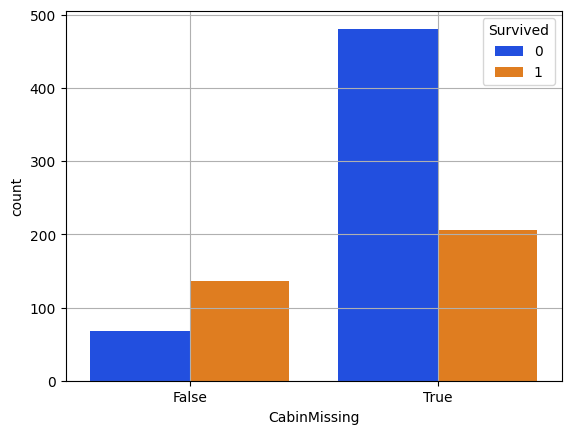

In [412]:
ax = sns.countplot(df, x="CabinMissing", hue="Survived", palette="bright")
ax.grid()

In [38]:
print(df.groupby(["CabinMissing"]).Age.describe())
print("")
print(df.groupby(["CabinMissing"]).Pclass.value_counts().sort_index())
print("")
print(df.groupby(["CabinMissing"]).Fare.describe())

              count       mean        std   min   25%   50%   75%   max
CabinMissing                                                           
False         185.0  35.829297  15.679356  0.92  24.0  36.0  48.0  80.0
True          529.0  27.555293  13.472634  0.42  19.0  26.0  35.0  74.0

CabinMissing  Pclass
False         1         176
              2          16
              3          12
True          1          40
              2         168
              3         479
Name: count, dtype: int64

              count       mean        std  min        25%       50%       75%  \
CabinMissing                                                                    
False         204.0  76.141504  74.391749  0.0  29.453125  55.22085  89.32815   
True          687.0  19.157325  28.663343  0.0   7.877100  10.50000  23.00000   

                   max  
CabinMissing            
False         512.3292  
True          512.3292  


# Embarked

In [182]:
df["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [183]:
df.groupby(["Embarked"]).Survived.mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

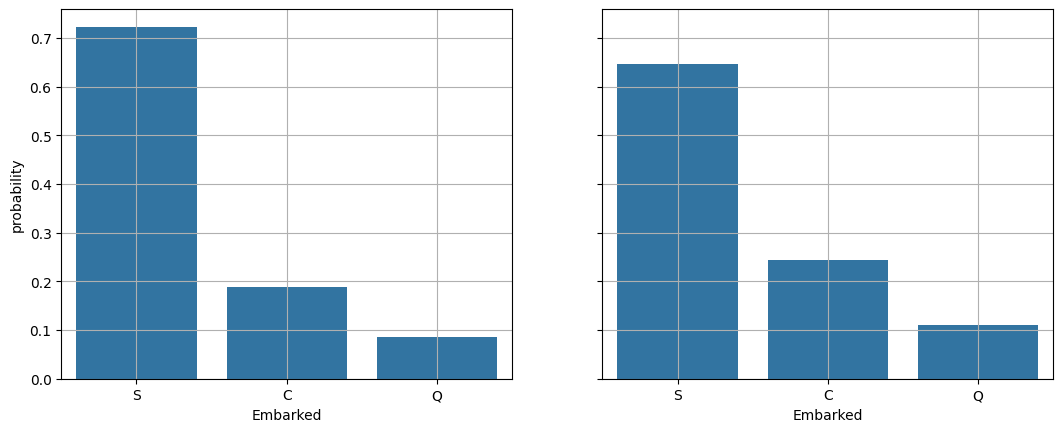

In [278]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.countplot(df, x="Embarked", ax=axs[0], stat="probability")
sns.countplot(df_test, x="Embarked", ax=axs[1], stat="probability")
axs[0].grid()
axs[1].grid()

# Training and validation

In [286]:
def prepare_dataframe(
    df,
    age_strategy=False,
    use_cabin=False,
    use_embarked=False,
    log_transform_fare=False,
    is_train=True,
    group_medians=None
):
    df = df.copy()

    if log_transform_fare:
        df["Fare"] = np.log10(df["Fare"]+1)

    # Process Title from Name
    df["Title"] = df["Name"].map(lambda x: x.strip().split(",")[1].strip().split()[0])

    if is_train:
        # Group rare titles
        titles_small_samples = df["Title"].value_counts().index[df["Title"].value_counts() < 10]
        df.loc[(df["Title"].isin(titles_small_samples)) & \
               (df["Sex"] == "female") & (df["Age"] <= 30), "Title"] = "Miss."
        df.loc[(df["Title"].isin(titles_small_samples)) & \
               (df["Sex"] == "female") & (df["Age"] > 30), "Title"] = "Mrs."
        df.loc[(df["Title"].isin(titles_small_samples)) & \
               (df["Sex"] == "male") & (df["Age"] > 12), "Title"] = "Mr."
        df.loc[(df["Title"] == "Dr.") & (df["Sex"] == "male"), "Title"] = "Mr."

    df["TotalFam"] = df["SibSp"] + df["Parch"]
    famgroups = df["TotalFam"].map(lambda x: x if x <= 2 else 3)

    # Age handling
    if age_strategy == "group_median":
        df["AgeMissing"] = df["Age"].isna().astype(int)

        if is_train:
            # compute group medians and store them
            df["GroupKey"] = list(zip(df["Title"], df["Pclass"], famgroups))
            group_medians = df.groupby("GroupKey")["Age"].median().to_dict()
        else:
            df["GroupKey"] = list(zip(df["Title"], df["Pclass"], famgroups))
            if group_medians is None:
                raise ValueError("Must provide group_medians during inference.")

        # fill missing ages using group medians
        df["Age"] = df.apply(
            lambda row: group_medians.get(row["GroupKey"], np.nan) if pd.isna(row["Age"]) else row["Age"],
            axis=1
        )

        df = df.drop("GroupKey", axis=1)

    # Cabin handling
    if use_cabin:
        df["CabinLetter"] = df["Cabin"].str[0].fillna("M")
        if is_train:
            df["CabinLetter"] = df["CabinLetter"].replace("T", "C")

    if not use_embarked and "Embarked" in df.columns:
        df = df.drop("Embarked", axis=1)

    # Drop unused
    drop_cols = ["PassengerId", "Ticket", "Name", "Cabin", "SibSp", "Parch"]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    return df, group_medians

In [144]:
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class NameEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories: list[str] | str = "auto", to_replace: dict[str, str] | None=None):
        self.categories = categories
        self.to_replace = to_replace
        if isinstance(self.categories, list):
            if "Unknown" not in self.categories:
                self.categories.append("Unknown")
            self.encoder = OneHotEncoder(categories=[self.categories])
        else:
            self.encoder = OneHotEncoder(categories=self.categories)
        self.pattern = re.compile(r"\b([a-zA-Z]+?)\.")

    def _extract_one(self, name):
        if isinstance(name, str):
            match = self.pattern.search(name)
            if match:
                return match.group(1)
        return "Unknown"

    def _extract_title(self, X):
        return X.map(self._extract_one)
    
    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out(input_features=input_features)

    def fit(self, X, y=None):
        X_clean = self._extract_title(X.copy()).replace(self.to_replace).iloc[:,0]
        if isinstance(self.categories, list):
            X_clean.loc[~X_clean.isin(self.categories)] = "Unknown"
        self.encoder.fit(X_clean.to_frame())
        return self

    def transform(self, X):
        X_clean = self._extract_title(X.copy()).replace(self.to_replace).iloc[:,0]
        if isinstance(self.categories, list):
            X_clean.loc[~X_clean.isin(self.categories)] = "Unknown"
        return self.encoder.transform(X_clean.to_frame())


In [271]:
valid_titles = ["Mr", "Miss", "Mrs", "Master", "Dr", "Rev", "Unknown"]
# categories = None
to_replace = {
    "Mlle": "Miss",
    "Mme": "Mrs",
    "Ms": "Miss",
}

class TitleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, extract_titles=True, to_replace=None, valid_titles=None, fallback="Unknown"):
        self.extract_titles = extract_titles
        self.to_replace = to_replace
        self.valid_titles = valid_titles
        self.fallback = fallback
        self.pattern = re.compile(r"\b([a-zA-Z]+?)\.")

    def _extract_one(self, name):
        if isinstance(name, str):
            match = self.pattern.search(name)
            if match:
                return match.group(1)
        return self.fallback

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_clean = X.drop("Name", axis=1)
        if self.extract_titles:
            titles = X["Name"].map(self._extract_one)
            if self.to_replace:
                titles = titles.replace(self.to_replace)
            if self.valid_titles:
                titles.loc[~titles.isin(self.valid_titles)] = self.fallback
                X_clean["Title"] = titles
        return X_clean

In [384]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, model, feature_names: list[str] | None=None, target_name="Age"):
        self.feature_names = feature_names
        self.target_name = target_name
        self.model = model
        if self.feature_names:
            self.feature_names_in_ = self.feature_names
    
    def fit(self, X, y=None):
        X_train = X.dropna(subset=[self.target_name])
        if not self.feature_names:
            self.feature_names_in_ = X_train.select_dtypes(exclude=["object"]).columns.tolist()
            self.feature_names_in_.remove(self.target_name)
            # self.feature_names_in_.remove("Survived")
        
        self.model.fit(X_train[self.feature_names_in_], X_train[self.target_name])
        return self
    
    def transform(self, X):
        X_out = X.copy()
        missing_mask = X[self.target_name].isna()
        if missing_mask.any():
            y_pred = self.model.predict(X.loc[missing_mask, self.feature_names_in_])
            X_out[self.target_name] = X_out[self.target_name].fillna(pd.Series(y_pred, index=missing_mask.loc[missing_mask].index))
        return X_out

    def get_feature_names_out(self):
        return self.feature_names_in_

In [1]:
df = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")
df["TotalFam"] = df["SibSp"] + df["Parch"]
# df = df.drop(["Name", "PassengerId", "Ticket", "Cabin"], axis=1)
X = df.drop(["PassengerId", "Ticket", "Cabin", "Survived", "Parch", "SibSp", "Embarked"], axis=1)
y = df["Survived"].copy()
# df, _ = prepare_dataframe(df)

NameError: name 'pd' is not defined

In [104]:
print(X.select_dtypes(exclude="object").columns)
print(X.select_dtypes(include="object").columns)

Index(['Pclass', 'Age', 'Fare', 'TotalFam'], dtype='object')
Index(['Name', 'Sex'], dtype='object')


In [339]:
class ImputationEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        self.feature_names_in = None
    
    def fit(self, X, y=None):
        self.feature_names_in_ = X.select_dtypes(include=["object"]).columns
        self.encoder.fit(X.select_dtypes(include=["object"]))
        return self
    
    def transform(self, X):
        X_out = X.copy()
        X_tr = self.encoder.transform(X.select_dtypes(include=["object"]))
        X_out = pd.concat((X_out, pd.DataFrame(X_tr, columns=self.get_feature_names_out(), index=X_out.index)), axis=1)
        return X_out
    
    def get_feature_names_out(self):
        return [f"{name}_Ord" for name in self.feature_names_in_]

            

In [319]:
imp_enc = ImputationEncoder()
df_new = imp_enc.fit_transform(df)

In [297]:
df.select_dtypes(include=["object"]).columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [305]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TotalFam'],
      dtype='object')

In [306]:
df_in = df.copy()
df_in = df_in.drop(columns=["PassengerId", "SibSp", "Parch", "Ticket", "Cabin", "Embarked"])
df_in.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Fare', 'TotalFam'], dtype='object')

In [ ]:
ord_features = ["Sex"]
onehot_features = ["Embarked"] if "Embarked" in X.columns else []
num_features = X.select_dtypes(exclude=["object"]).columns

print(ord_features)
print(onehot_features)
print(num_features)

valid_titles = ["Mr", "Miss", "Mrs", "Master", "Dr", "Rev", "Unknown"]
to_replace = {
    "Mlle": "Miss",
    "Mme": "Mrs",
    "Ms": "Miss",
}

['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'TotalFam', 'Title',
       'Sex_Ord', 'Title_Ord']

title_extractor = TitleExtractor(to_replace=to_replace, valid_titles=valid_titles)
impute_encoder = ImputationEncoder()
age_imputer = AgeImputer(RandomForestRegressor(max_depth=5))
preprocessor = ColumnTransformer([
    ("drop", "drop", ["Sex_Ord", "Title_Ord"]),
    ("onehot", OneHotEncoder(handle_unknown="ignore"), ["Title"]),
    ("ordinal", OrdinalEncoder(), ["Sex"])
], remainder="passthrough")

data_prep_pipeline = Pipeline([
    ("title_extractor", title_extractor),
    ("impute_encoder", impute_encoder),
    ("age_imputer", age_imputer),
    ("prep", preprocessor),
])

['Sex']
[]
Index(['Pclass', 'Age', 'Fare', 'TotalFam'], dtype='object')


In [387]:
np_out = data_prep_pipeline.fit_transform(df_in)

In [391]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

y = df_in["Survived"]
X = df_in.drop(columns=["Survived"])

model = RandomForestClassifier(max_depth=5, random_state=0)
# model = RandomForestClassifier(random_state=0)

pipeline = Pipeline([
    ("data_prep", data_prep_pipeline),
    ("model", model)
])

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

training = {
    "train_score": np.zeros(10),
    "val_score": np.zeros(10),
    "feature_importances": [],
    "val_predictions": [],
}
for split, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    training["val_score"][split] = accuracy_score(y_val, y_pred)
    y_pred = pipeline.predict(X_train)
    training["train_score"][split] = accuracy_score(y_train, y_pred)
    training["feature_importances"].append(pipeline.named_steps.model.feature_importances_)

print(f"{"Train accuracy mean, std":30}: {(training["train_score"]*100).mean().round(1).item()}, {(training["train_score"]*100).std().round(1).item()}")
print(f"{"Val accuracy mean, std":30}: {(training["val_score"]*100).mean().round(1).item()}, {(training["val_score"]*100).std().round(1).item()}")
print("")
feature_importances = pd.Series((np.vstack(training["feature_importances"]).mean(axis=0)*100).round(1), index=pipeline.named_steps.data_prep.named_steps.prep.get_feature_names_out()).sort_values(ascending=False)
print(feature_importances)

Train accuracy mean, std      : 84.9, 0.7
Val accuracy mean, std        : 82.7, 3.8

ordinal__Sex             23.0
onehot__Title_Mr         20.3
remainder__Fare          12.8
remainder__Pclass        12.0
remainder__TotalFam       8.5
remainder__Age            8.3
onehot__Title_Miss        6.4
onehot__Title_Mrs         6.3
onehot__Title_Master      1.4
onehot__Title_Rev         0.6
onehot__Title_Unknown     0.3
onehot__Title_Dr          0.2
dtype: float64


In [381]:
pipeline.named_steps.data_prep.named_steps.prep.get_feature_names_out()

array(['onehot__Title_Dr', 'onehot__Title_Master', 'onehot__Title_Miss',
       'onehot__Title_Mr', 'onehot__Title_Mrs', 'onehot__Title_Rev',
       'onehot__Title_Unknown', 'ordinal__Sex', 'remainder__Survived',
       'remainder__Pclass', 'remainder__Age', 'remainder__Fare',
       'remainder__TotalFam'], dtype=object)

In [508]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(max_depth=5, random_state=0)
# model = RandomForestClassifier(random_state=0)

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", model)
])

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Setup: store results for each fold
training = {
    "train_score": np.zeros(n_splits),
    "val_score": np.zeros(n_splits),
    "feature_importances": [],
    "val_predictions": []  # NEW: store validation predictions per fold
}

for split, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    pipeline.fit(X_train, y_train)
    
    # Predict on val
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]  # P(survived=1)

    # Predict on train for reference
    y_pred_train = pipeline.predict(X_train)
    
    # Save scores
    training["val_score"][split] = accuracy_score(y_val, y_pred_val)
    training["train_score"][split] = accuracy_score(y_train, y_pred_train)
    
    # Save feature importances
    training["feature_importances"].append(
        pipeline.named_steps.model.feature_importances_
    )
    
    # Save detailed val predictions
    fold_df = pd.DataFrame({
        "Index": val_idx,
        "TrueLabel": y_val,
        "PredLabel": y_pred_val,
        "PredProba": y_proba_val
    })
    fold_df["Fold"] = split  # Optional: track which fold it came from
    training["val_predictions"].append(fold_df)

# Combine all folds into one DataFrame
val_predictions_df = pd.concat(training["val_predictions"], ignore_index=True)

# Merge back to your original data to inspect misclassified samples
df_with_preds = df.copy()
df_with_preds = df_with_preds.merge(
    val_predictions_df,
    left_index=True,
    right_on="Index",
    how="left"
)

# Now you can filter:
# misclassified samples in validation folds
misclassified = df_with_preds[df_with_preds["TrueLabel"] != df_with_preds["PredLabel"]]

# print(misclassified.head())

# Or look at highly confident mistakes:
high_confidence_errors = misclassified[
    (misclassified["PredProba"] > 0.9) | (misclassified["PredProba"] < 0.1)
]

# print(high_confidence_errors.head())

# Same stats
print(f"{'Train accuracy mean, std':30}: {(training['train_score']*100).mean():.1f}, {(training['train_score']*100).std():.1f}")
print(f"{'Val accuracy mean, std':30}: {(training['val_score']*100).mean():.1f}, {(training['val_score']*100).std():.1f}")

feature_importances = pd.Series(
    np.vstack(training["feature_importances"]).mean(axis=0) * 100,
    index=pipeline.named_steps.prep.get_feature_names_out()
).round(1).sort_values(ascending=False)

print(feature_importances)

Train accuracy mean, std      : 77.8, 0.6
Val accuracy mean, std        : 74.0, 4.7
num__Fare               30.7
num__Age                19.4
num__Pclass             19.1
num__TotalFam           11.7
num__SibSp               5.2
num__Parch               5.0
onehot__Embarked_S       3.4
onehot__Embarked_C       3.3
onehot__Embarked_Q       2.0
onehot__Embarked_nan     0.2
dtype: float64


## Analyze misclassified samples

In [381]:
df_with_preds["AgeMissing"] = df_with_preds["Age"].isna()
df_with_preds["CabinMissing"] = df_with_preds["Cabin"].isna()

In [435]:
misclassified = df_with_preds.loc[df_with_preds["TrueLabel"] != df_with_preds["PredLabel"]].copy()
misclassified = misclassified.sort_values("PredProba")
classified = df_with_preds.query("TrueLabel == PredLabel").sort_values("PredProba").copy()

In [445]:
axs.shape

(2, 3)

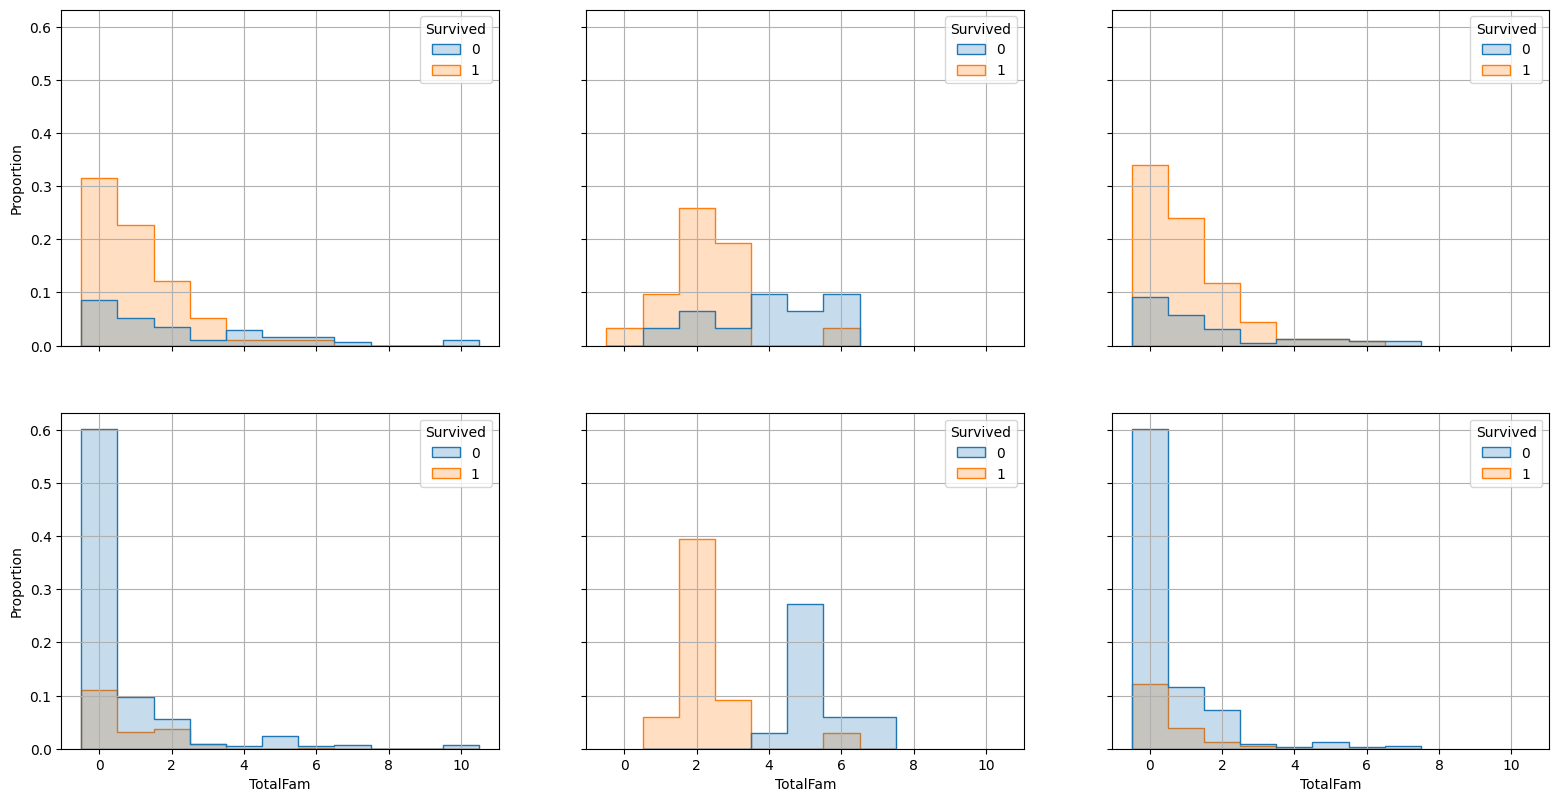

In [446]:
# ax = sns.boxenplot(df_with_preds, x="Survived", y="TotalFam")
# ax = sns.histplot(df_with_preds, x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True)
# ax = sns.histplot(df_with_preds.query('(Age <= 10) and (Sex == "female") and (Pclass == 3)'), x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True)
# ax = sns.histplot(df_with_preds.query('(Age <= 10)'), x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True)

# If you're older than 10, then you have a higher rate of survival if you have some family
# If you're younger, you have a higher rate of survival with less family

f, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6.4*3, 4.8*2))
sns.histplot(df_with_preds.query("Sex == 'female'"), x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True, ax=axs[0,0], stat="proportion")
sns.histplot(df_with_preds.query('(Age <= 10) and (Sex == "female")'), x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True, ax=axs[0,1], stat="proportion")
sns.histplot(df_with_preds.query('(Age > 10) and (Sex == "female")'), x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True, ax=axs[0,2], stat="proportion")
sns.histplot(df_with_preds.query("Sex == 'male'"), x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True, ax=axs[1,0], stat="proportion")
sns.histplot(df_with_preds.query('(Age <= 10) and (Sex == "male")'), x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True, ax=axs[1,1], stat="proportion")
sns.histplot(df_with_preds.query('(Age > 10) and (Sex == "male")'), x="TotalFam", hue="Survived", multiple="layer", element="step", discrete=True, ax=axs[1,2], stat="proportion")
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].grid()

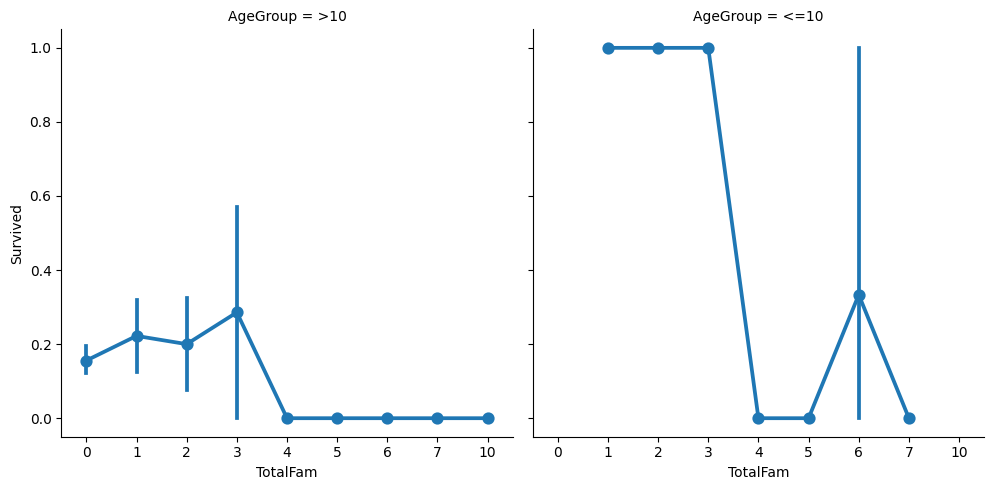

In [500]:
df_with_preds['AgeGroup'] = df_with_preds['Age'].map(lambda x: '<=10' if x <= 10 else '>10')

# Plot
# sns.catplot(
#     data=df_with_preds,
#     x='TotalFam',
#     y='Survived',
#     hue='Sex',
#     col='AgeGroup',
#     kind='point'
# )
sns.catplot(
    data=df_with_preds.query("Sex == 'male'"),
    x='TotalFam',
    y='Survived',
    # hue='Sex',
    col='AgeGroup',
    kind='point'
)
plt.show()

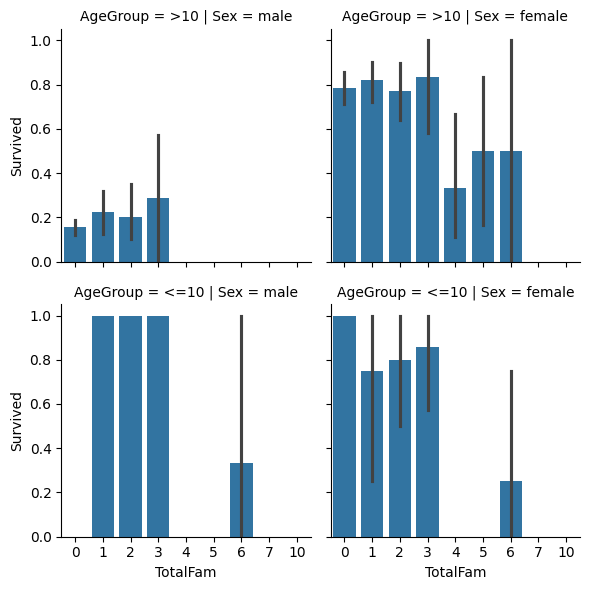

In [471]:
g = sns.FacetGrid(df_with_preds, col="Sex", row="AgeGroup")
g.map_dataframe(
    sns.barplot, x="TotalFam", y="Survived"
)

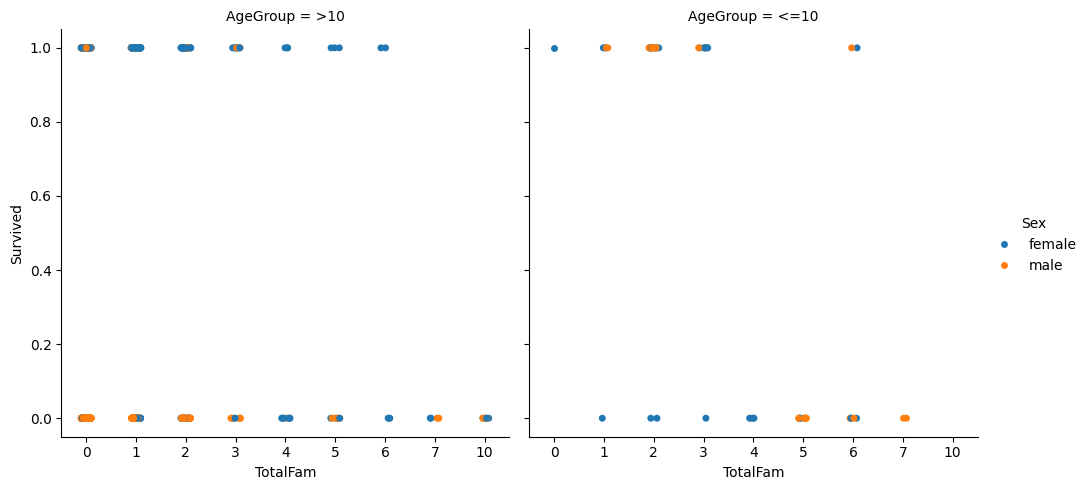

In [470]:
sns.catplot(
    data=df_with_preds,
    x='TotalFam',
    y='Survived',
    hue='Sex',
    col='AgeGroup',
    kind='strip',
    jitter=True
)

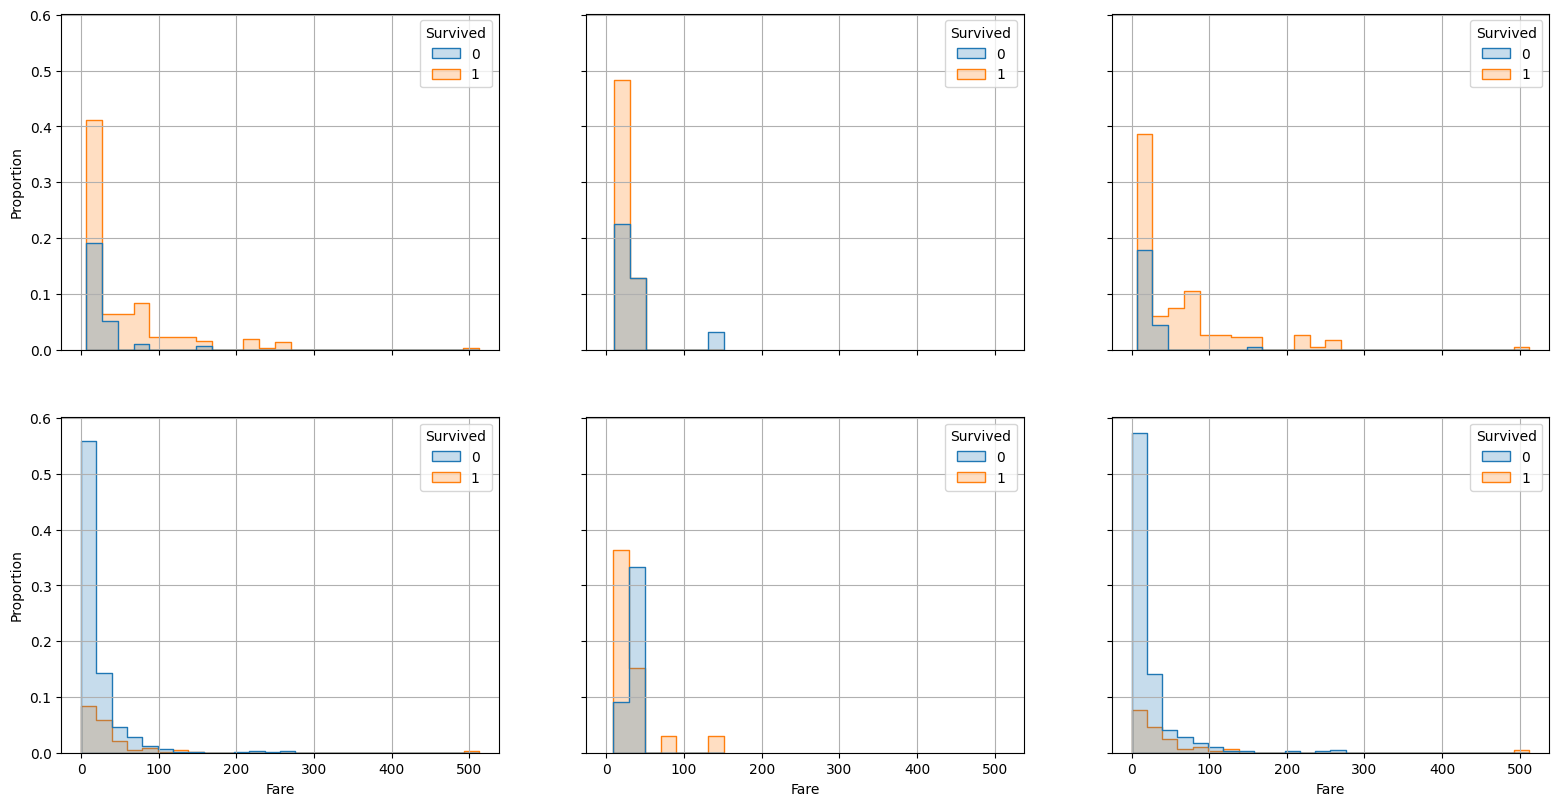

In [447]:
f, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6.4*3, 4.8*2))
sns.histplot(df_with_preds.query("Sex == 'female'"), x="Fare", hue="Survived", multiple="layer", element="step", ax=axs[0,0], stat="proportion", binwidth=20)
sns.histplot(df_with_preds.query('(Age <= 10) and (Sex == "female")'), x="Fare", hue="Survived", multiple="layer", element="step", ax=axs[0,1], stat="proportion", binwidth=20)
sns.histplot(df_with_preds.query('(Age > 10) and (Sex == "female")'), x="Fare", hue="Survived", multiple="layer", element="step", ax=axs[0,2], stat="proportion", binwidth=20)
sns.histplot(df_with_preds.query("Sex == 'male'"), x="Fare", hue="Survived", multiple="layer", element="step", ax=axs[1,0], stat="proportion", binwidth=20)
sns.histplot(df_with_preds.query('(Age <= 10) and (Sex == "male")'), x="Fare", hue="Survived", multiple="layer", element="step", ax=axs[1,1], stat="proportion", binwidth=20)
sns.histplot(df_with_preds.query('(Age > 10) and (Sex == "male")'), x="Fare", hue="Survived", multiple="layer", element="step", ax=axs[1,2], stat="proportion", binwidth=20)
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].grid()

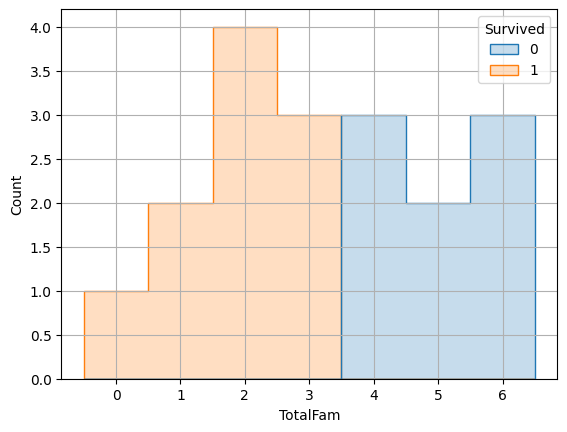

In [451]:
ax = sns.histplot(classified.query("(Sex == 'female') and (Age <= 10) and (Pclass == 3)"), x="TotalFam", discrete=True, hue="Survived", multiple="layer", element="step")
ax.grid()

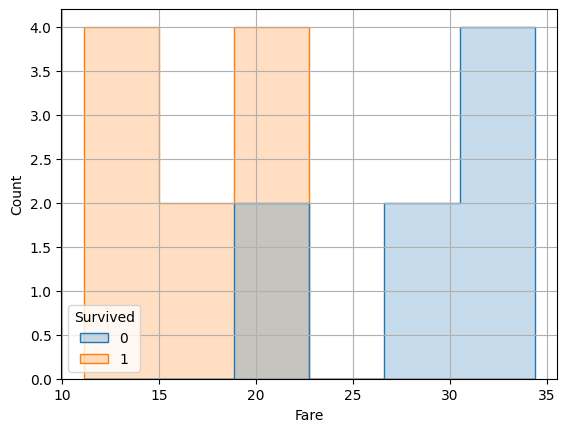

In [452]:
ax = sns.histplot(classified.query("(Sex == 'female') and (Age <= 10) and (Pclass == 3)"), x="Fare", hue="Survived", multiple="layer", element="step")
ax.grid()

In [464]:
df_with_preds.query("(Sex == 'male') and (Age > 15) and (Age <= 35) and (Pclass != 1) and (TotalFam <= 1)").Survived.mean()

np.float64(0.13488372093023257)

In [474]:
classified.query("(Sex == 'male') and (Age > 15) and (Age <= 35) and (Pclass != 1) and (TotalFam <= 1)").Survived.mean()

np.float64(0.0)

In [484]:
print(classified.query("(Sex == 'male') and (Age > 15) and (Age <= 35) and (Pclass != 1) and (TotalFam <= 1)").PredProba.mean())
print(misclassified.query("(Sex == 'male') and (Age > 15) and (Age <= 35) and (Pclass != 1) and (TotalFam <= 1)").PredProba.mean())

0.1553946509633022
0.1532260300933551


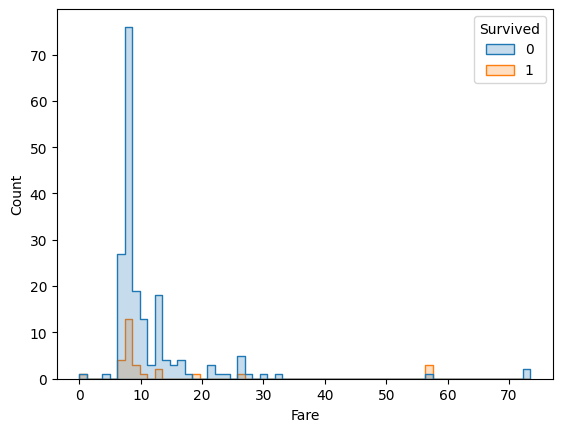

In [462]:
ax = sns.histplot(df_with_preds.query("(Age > 15) and (Age <= 35) and (Pclass != 1) and (TotalFam <= 1) and (Sex == 'male')"), x="Fare", hue="Survived", multiple="layer", element="step")

In [454]:
misclassified.query("(PredProba <= 0.2) and (Sex == 'male')").sort_values(by="Age")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam,Index,TrueLabel,PredLabel,PredProba,Fold,AgeMissing,CabinMissing
560,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S,6,261,1,0,0.088333,6,False,True
111,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,0,220,1,0,0.118189,1,False,True
109,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S,0,204,1,0,0.118189,1,False,True
833,284,1,3,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,0,283,1,0,0.114075,9,False,True
552,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S,0,226,1,0,0.134207,6,False,True
423,665,1,3,"Lindqvist, Mr. Eino William",male,20.0,1,0,STON/O 2. 3101285,7.9250,NaN,S,1,664,1,0,0.132353,4,False,True
700,763,1,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C,0,762,1,0,0.161537,7,False,True
132,392,1,3,"Jansson, Mr. Carl Olof",male,21.0,0,0,350034,7.7958,NaN,S,0,391,1,0,0.103676,1,False,True
410,554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C,0,553,1,0,0.161162,4,False,True
459,128,1,3,"Madsen, Mr. Fridtjof Arne",male,24.0,0,0,C 17369,7.1417,NaN,S,0,127,1,0,0.115782,5,False,True


In [499]:
misclassified.loc[misclassified["PredProba"] <= 0.2].sort_values(by=["PredProba", "Sex", "Age", "Pclass"], ascending=[True, True, True, True])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam,Index,TrueLabel,PredLabel,PredProba,Fold,AgeMissing,CabinMissing
84,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,0,828,1,0,0.086611,0,True,True
560,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S,6,261,1,0,0.088333,6,False,True
817,108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S,0,107,1,0,0.089634,9,True,True
132,392,1,3,"Jansson, Mr. Carl Olof",male,21.0,0,0,350034,7.7958,NaN,S,0,391,1,0,0.103676,1,False,True
47,445,1,3,"Johannesen-Bratthammer, Mr. Bernt",male,NaN,0,0,65306,8.1125,NaN,S,0,444,1,0,0.104737,0,True,True
861,570,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S,0,569,1,0,0.104882,9,False,True
746,339,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S,0,338,1,0,0.105597,8,False,True
26,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,0,271,1,0,0.108988,0,False,True
260,805,1,3,"Hedman, Mr. Oskar Arvid",male,27.0,0,0,347089,6.9750,NaN,S,0,804,1,0,0.113797,2,False,True
833,284,1,3,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,0,283,1,0,0.114075,9,False,True


In [489]:
classified.query("(Sex == 'female') and (TotalFam <= 3)").sort_values("PredProba").head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam,Index,TrueLabel,PredLabel,PredProba,Fold,AgeMissing,CabinMissing
629,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S,1,40,0,0,0.390230,7,False,True
727,101,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,NaN,S,0,100,0,0,0.435321,8,False,True
397,403,0,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,S,1,402,0,0,0.438151,4,False,True
292,294,0,3,"Haas, Miss. Aloisia",female,24.0,0,0,349236,8.8500,NaN,S,0,293,0,0,0.442051,3,False,True
676,535,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S,0,534,0,0,0.445374,7,False,True
219,416,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,343095,8.0500,NaN,S,0,415,0,0,0.445464,2,True,True
61,565,0,3,"Meanwell, Miss. (Marion Ogden)",female,NaN,0,0,SOTON/O.Q. 392087,8.0500,NaN,S,0,564,0,0,0.455792,0,True,True
100,114,0,3,"Jussila, Miss. Katriina",female,20.0,1,0,4136,9.8250,NaN,S,1,113,0,0,0.460402,1,False,True
556,252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S,2,251,0,0,0.475357,6,False,False
477,277,0,3,"Lindblom, Miss. Augusta Charlotta",female,45.0,0,0,347073,7.7500,NaN,S,0,276,0,0,0.476911,5,False,True


In [491]:
misclassified.loc[misclassified["PredProba"] >= 0.7].sort_values(by=["PredProba", "Sex", "Age", "Pclass"], ascending=[False, True, True, True])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam,Index,TrueLabel,PredLabel,PredProba,Fold,AgeMissing,CabinMissing
294,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S,3,297,0,1,0.893244,3,False,False
376,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C,0,177,0,1,0.879949,4,False,False
856,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S,3,498,0,1,0.871239,9,False,False
834,313,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,250651,26.0000,NaN,S,2,312,0,1,0.852468,9,False,True
736,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S,0,199,0,1,0.817247,8,False,True
718,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S,1,41,0,1,0.808605,8,False,True
444,855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0000,NaN,S,1,854,0,1,0.785651,4,False,True
40,358,0,2,"Funk, Miss. Annie Clemmer",female,38.0,0,0,237671,13.0000,NaN,S,0,357,0,1,0.751290,0,False,True
344,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S,0,772,0,1,0.737481,3,False,False
545,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C,2,140,0,1,0.705757,6,True,True


In [496]:
df_with_preds.query("(Sex == 'female') and (TotalFam <= 3) and (AgeGroup == '<=10') and (Pclass == 1)").PassengerId.count()

np.int64(1)

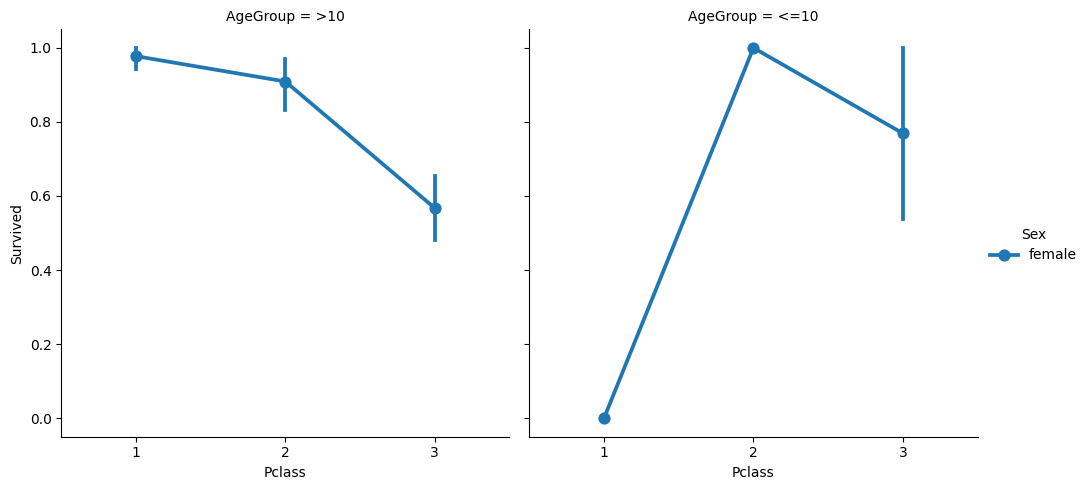

In [494]:
sns.catplot(
    data=df_with_preds.query("(Sex == 'female') and (TotalFam <= 3)"),
    x='Pclass',
    y='Survived',
    hue='Sex',
    col='AgeGroup',
    kind='point'
)
plt.show()

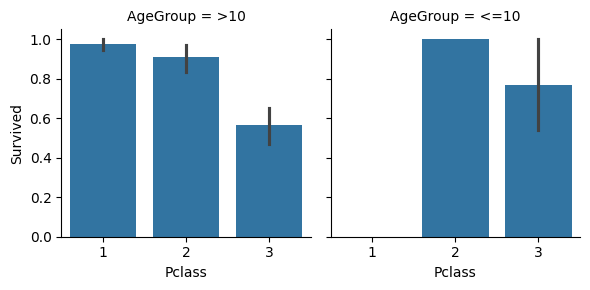

In [497]:
g = sns.FacetGrid(df_with_preds.query("(Sex == 'female') and (TotalFam <= 3)"), col="AgeGroup")
g.map_dataframe(
    sns.barplot, x="Pclass", y="Survived"
)